## Data and Statistical Calibration (Indirect Inference) on Model

### KLLN

In [6]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import statsmodels.api as sm
import seaborn as sns

import requests, zipfile, io
from pandas import ExcelWriter
from pandas import ExcelFile
from fredapi import Fred

import statistics as stats
from scipy import interpolate
from scipy.optimize import curve_fit

from itertools import product
import time

%matplotlib inline

In [7]:
# Instantiate Fred class as "fred", with personal own api_key 
# It can be registered through https://research.stlouisfed.org by searching api key
fred = Fred(api_key = 'cd6992c5ce004b0b4493fe2cf6c3fdab')

In [8]:
df = {}

In [9]:
#get data from Assets tab in Lucas-Nicolini excel file
data_LN_data = \
        pd.read_excel('Calibration_data.xlsx', 'data_consolidated')

In [10]:
# Store lists of data series and KEYs into dictionary df
df['Dates'] = data_LN_data['years'].tolist()
df['T-Bill Rate (3-month, annual)'] = (data_LN_data['tbills3m']/100.).tolist()
df['NewM1/GDP'] = (data_LN_data['new_m1']/100.).tolist()

# inflation
inflation = fred.get_series('CPIAUCNS', frequency='a')
inflation = inflation.reset_index()
inflation.columns = ['Dates', 'CPI (seasonal)']
inflation = inflation.set_index(inflation['Dates'])
start_year = '1915'
stop_year = '2016' 
inflation = inflation['CPI (seasonal)']/inflation['CPI (seasonal)'].shift(1) - 1

df['Inflation (CPI, raw)'] = inflation.loc[start_year+'-01-01':stop_year+'-01-01']

obslength = []
keys = []

for list_idx, list_key in enumerate(df):
    list_length = len(df[list_key])
    print(list_idx, list_key, "> Observations:", list_length)
    obslength.append(list_length)
    keys.append(list_key)
obslength_min = min(obslength)
print("Shortest data series is %s with data length of %i" %(keys[obslength==obslength_min], obslength_min))


0 Dates > Observations: 102
1 T-Bill Rate (3-month, annual) > Observations: 102
2 NewM1/GDP > Observations: 102
3 Inflation (CPI, raw) > Observations: 102
Shortest data series is Dates with data length of 102


In [11]:
# Truncate longer series to have the same length of: obslength_min
for list_idx, list_key in enumerate(df):
    df[list_key] = df[list_key][0:obslength_min]

In [12]:
# Convert df to Pandas dataframe
d = pd.DataFrame(df)
d = d.set_index(d['Dates'])

In [13]:
d

,Dates,"T-Bill Rate (3-month, annual)",NewM1/GDP,"Inflation (CPI, raw)"
Dates,,,,
1915,1915,0.0285,0.322164,0.009085
1916,1916,0.0325,0.295371,0.076672
1917,1917,0.0462,0.284928,0.178443
1918,1918,0.0419,0.248897,0.172865
1919,1919,0.0437,0.276148,0.152307
...,...,...,...,...
2012,2012,0.0009,0.416954,0.020694
2013,2013,NaN,0.428727,0.014648
2014,2014,NaN,0.437827,0.016222


## This notebook (below) uses truncated sample (1980-2007)


In [14]:
# Truncate data window
date_truncate_start = '1983' 
date_truncate_stop = '2007'

dcut = d.loc[date_truncate_start:date_truncate_stop]

### Visualization of data 

<AxesSubplot:xlabel='Dates'>

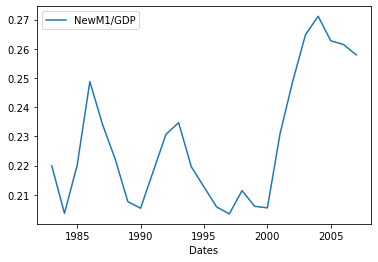

In [15]:
# M/PY using M1 (sweep adjusted) data for M, nominal GDP for PY
dcut.plot(y='NewM1/GDP')

<AxesSubplot:xlabel='Dates'>

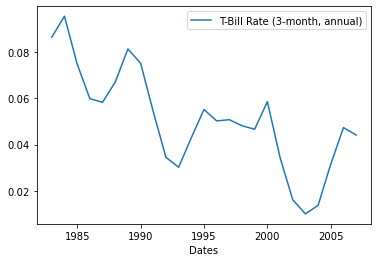

In [16]:
# T-Bill Rate (3-month, annual) 
dcut.plot(y='T-Bill Rate (3-month, annual)')

<AxesSubplot:xlabel='T-Bill Rate (3-month, annual)', ylabel='NewM1/GDP'>

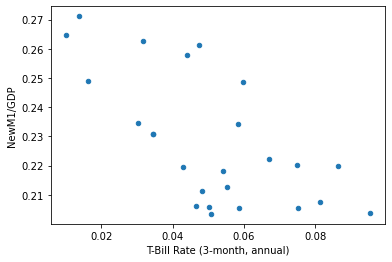

In [17]:
# Scatter plot M/PY vs. Federal Funds Rate
dcut.plot(x='T-Bill Rate (3-month, annual)', y='NewM1/GDP', kind='scatter')

<AxesSubplot:xlabel='T-Bill Rate (3-month, annual)', ylabel='Inflation (CPI, raw)'>

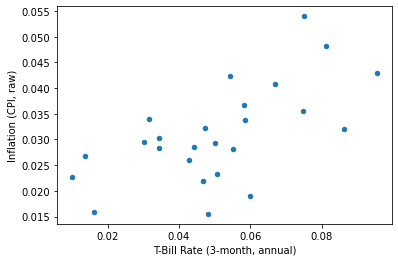

In [18]:
# Scatter plot Federal Funds Rate vs. inflation
dcut.plot(x='T-Bill Rate (3-month, annual)', y='Inflation (CPI, raw)', kind='scatter')

In [19]:
# Truncated sample (1980-2007) stats
dcut_mean = dcut.mean().to_frame()
dcut_mean.columns = ["sample mean"]
dcut_mean

,sample mean
Dates,1995.000000
"T-Bill Rate (3-month, annual)",0.050640
NewM1/GDP,0.228289
"Inflation (CPI, raw)",0.031108


In [20]:
T_bill_mean = 0.058154
τ_mean = 0.038494
#Use Fisher relation to back out the discount factor
β_data= (1.0+τ_mean)/(1.0+T_bill_mean)
print(β_data)

0.9814204737684685


### Visualization tool

In [21]:

def func(x, a, b, c):
    return a*np.exp(-b * x) + c 

def money_func_fit(x, y):
    data = np.asarray(sorted(zip(x,y)))
    i_set = np.linspace(data[:,0].min(), data[:,0].max())
    popt, pcov = curve_fit(func, x, y, bounds=(0.001, 10.0))
    fitted_func = func(i_set, *popt)
    return fitted_func

def markup_func_fit(x,y):
    data = np.asarray(sorted(zip(x,y)))
    i_set = np.linspace(data[:,0].min(), data[:,0].max())
    popt, pcov = curve_fit(func, x, y, bounds=(0.001, 10.0))
    fitted_func = func(i_set, *popt)
    return fitted_func

def visualization(x = dcut['T-Bill Rate (3-month, annual)'].tolist(),\
                  y = dcut['NewM1/GDP'].tolist(),\
                  x_label = 'T-Bill Rate (3-month, annual)',\
                  y_label = 'NewM1/GDP',\
                  model_x = np.linspace(0.0,0.0,1),\
                  model_y = np.linspace(0.0,0.0,1)
                 ):
    data = np.asarray(sorted(zip(x,y)))
   
    i_set = np.linspace(data[:,0].min(), data[:,0].max())
    i_mean = 0.050640
    

    if y_label == 'NewM1/GDP':
        popt, pcov = curve_fit(func, x, y, bounds=(0.001, 10.0))
    else:
        popt, pcov = curve_fit(func, x, y, bounds=(0.001, 10.0))
    fitted_func = func(i_set, *popt)
    if y_label == 'NewM1/GDP':
        plt.scatter(x, y, label='Data: 1983-2007')
        plt.plot(i_set, fitted_func, '--', color='r', label='Fitted spline')
        plt.plot(model_x, model_y, '-g', label="Model")
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xlim(0.0, 0.11)
        plt.ylim(0.15, 0.3)
        plt.legend()
        plt.show()
    else:
        plt.scatter(x, y, label='Data: 1983-2007')
        plt.plot(i_set, fitted_func, '--', color='r', label='Fitted spline')
        plt.plot(model_x, model_y, '-g', label="Model")
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xlim(0.0, 0.11)
        plt.ylim(1.0, 1.6)
        plt.legend()
        plt.show()    
    return fitted_func


In [22]:
y = dcut['NewM1/GDP'].tolist()
x = dcut['T-Bill Rate (3-month, annual)'].tolist()
data = np.asarray(sorted(zip(x,y)))
L_fit = interpolate.splrep(data[:,0], data[:,1], s=3)

# Scatter plot data
# Plot fitted spline function 
i_set = np.linspace(data[:,0].min(), data[:,0].max())
L_set = interpolate.splev(i_set, L_fit, der=0)
M1_fit_target=L_set
# Plot point where data at mean
i_mean = np.asarray(x).mean()
L_mean = interpolate.splev(i_mean, L_fit, der=0)
# L_mean = df_comb2['NewM1/GDP'].mean()
L_mean_slope = interpolate.splev(i_mean, L_fit, der=1)

Elasticity_L_i = L_mean_slope*i_mean/L_mean
print("L_mean = %6.4f" %(L_mean))
print("i_mean = %6.4f" %(i_mean))
print("Slope = %6.4f" %(L_mean_slope))
print("Elasticity of M1/GDP w.r.t. Nominal Interest Rate = %6.4f" %(Elasticity_L_i) )

L_mean = 0.2243
i_mean = 0.0506
Slope = -0.5389
Elasticity of M1/GDP w.r.t. Nominal Interest Rate = -0.1216


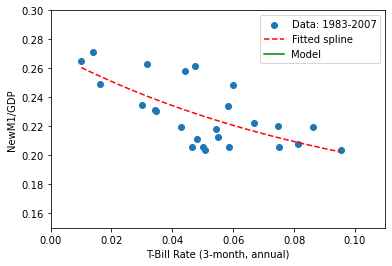

In [23]:
M1_GDP_fit_target =visualization(x = dcut['T-Bill Rate (3-month, annual)'].tolist(),\
                  y = dcut['NewM1/GDP'].tolist(),\
                  x_label = 'T-Bill Rate (3-month, annual)',\
                  y_label = 'NewM1/GDP',\
                  model_x = np.linspace(0.0,0.0,50),\
                  model_y = np.linspace(0.0,0.0,50))

### Store targets for calibration below

In [24]:
M1_GDP_target = M1_GDP_fit_target

In [25]:
def ols(x, y):
    # Linear best fit:
    deg = 1 # OLS for linear best fit equation
    bols = np.polyfit(x, y, deg, rcond=None, full=False)
    y = bols[1] + bols[0]*x
    return bols

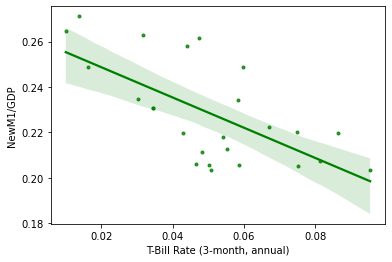

In [26]:
# Data
i_data = dcut['T-Bill Rate (3-month, annual)']
M1_GDP_data = dcut['NewM1/GDP']

plt.figure()
ax2 = sns.regplot(x=i_data, y=M1_GDP_data, 
                 data=None, 
                 fit_reg=True, 
                 x_estimator=None, 
                 marker=".", color="g") 

In [27]:
bols = ols(i_data, M1_GDP_data)
print("\nNow we approximate correlation: \n")
print("\t\tLinear Best Fit (Slope, Intercept) = ", str(bols), "\n")
    


Now we approximate correlation: 

		Linear Best Fit (Slope, Intercept) =  [-0.66693817  0.26206226] 



In [28]:
from datetime import date

today = date.today()

## Calibration 

In [29]:
import bj_bcw as klln

In [30]:
σ_DM_range = np.linspace(0.283, 0.283, 1)  
Ubar_CM_range = np.linspace(1.8, 1.8, 1)
α_1_range = np.linspace(0.05,0.05, 1)


#create a for-loop parameter value table
KLLN_class = np.array( [klln.baseline_mod(β=β_data, σ_CM=1.0, σ_DM=i, α_1=j,Ubar_CM=k,n=0.65,τ_min=β_data-1+1e-2,τ_max=0.08,chi=0.007, i_r=0) \
                            for (i, j, k) in product(σ_DM_range,\
                                                        α_1_range,\
                                                        Ubar_CM_range)]) 
    

print(KLLN_class.size)


1


In [31]:
print(β_data)

0.9814204737684685


* each index corresponds to a class with 1 possible combination of parameter values in the for-loop parameter table 

In [32]:
def L(M1_GDP_target):
    """distance function between model simulated stat vs. spline-fitted data target"""
    
    L_diff = np.zeros(KLLN_class.size)
    
    for idx, x in enumerate(KLLN_class):
        # each idx is a particular class instantiation with particular 
        # parameter values in the parameter for-loop table
        
        # get SME result (dictionary)
        # note: this solver has equilibrium conditions check
        z_guess, i_guess = 0.4, 0.01
        result = KLLN_class[idx].SME_stat(z_guess, i_guess)
        
        # extract model implied M/PY array 
        # note: model M/P = z, and Y = CM consumption + total DM consumption
        mpy_grid = result['stat_grid']['mpy_star']

        i_FFR_grid = result['stat_grid']['FFR']
        
        w_mpy = 1.0/(stats.variance(M1_GDP_target))

        diff_M1_GDP =  np.abs(mpy_grid - M1_GDP_target) 
       
        L_diff_func = np.sum( w_mpy*(diff_M1_GDP)**2.0 )
    
        L_diff[idx] = L_diff_func.min()

        print(KLLN_class[idx].σ_DM)
        print(KLLN_class[idx].α_1)
        print(KLLN_class[idx].Ubar_CM)
               
    L_diff_min = L_diff[L_diff.argmin()]
    # get the corresponding class instantiation 
    KLLN_model = KLLN_class[L_diff.argmin()]
    # pick the corresponding value with minimum distance between model and target    
    model_result = KLLN_model.SME_stat(z_guess, i_guess)
    
    M1_GDP_star = model_result['stat_grid']['mpy_star']
    τ_mean = 0.031108
    z_mean, i_mean = KLLN_model.solve_z_i(z_guess, i_guess, τ_mean)  
    markup_star = KLLN_model.markup_func(z_mean, i_mean, τ_mean) 
    mpy_star = z_mean/(KLLN_model.x_star+ KLLN_model.Total_q_func(z_mean, i_mean,τ_mean))
    i_policy_grid = model_result['stat_grid']['FFR']
    τ_grid = [τ_mean-1e-5, τ_mean, τ_mean+1e-5]
    mpy_star_grid =[]
    i_grid=[]
    for τ in τ_grid:
        z, i = KLLN_model.solve_z_i(z_guess, i_guess, τ)
        mpy_star = z/(KLLN_model.x_star+ KLLN_model.Total_q_func(z, i,τ))
        mpy_star_grid.append(mpy_star)
        i_grid.append(i)
    M1_elasticity = (i_grid[1]/mpy_star_grid[1])*((mpy_star_grid[-1]-mpy_star_grid[0])/(i_grid[-1]-i_grid[0]))
    
    
    #implied parameter values that achieve the shortest distance between model and target
    σ_DM = KLLN_model.σ_DM
    σ_CM = KLLN_model.σ_CM
    α_1 = KLLN_model.α_1
    Ubar_CM = KLLN_model.Ubar_CM    
    
    return  M1_GDP_star, M1_elasticity , markup_star, mpy_star,\
            i_policy_grid, σ_DM, σ_CM, α_1, Ubar_CM,\
            L_diff_min, KLLN_model
       

In [33]:
tic = time.time()
M1_GDP_star, M1_elasticity, markup_star, mpy_star,i_policy_grid, σ_DM, σ_CM, α_1, Ubar_CM,\
            L_diff_min, KLLN_model = L(M1_GDP_target)           
toc = time.time()-tic
print(toc, "seconds")

1.0000000000000033
-3.401893251100836e-15
0.9285714285714134
0.07142857142858663
0.8571428571428618
0.14285714285713813
0.7857142857142717
0.21428571428572815
0.7142857142857397
0.2857142857142604
0.6428571428571496
0.35714285714285043
0.5714285714285787
0.4285714285714212
0.500000000000008
0.49999999999999195
0.42857142857138586
0.571428571428614
0.35714285714285393
0.6428571428571461
0.28571428571426366
0.7142857142857363
0.21428571428569304
0.7857142857143069
0.1428571428571416
0.8571428571428584
0.07142857142855144
0.9285714285714485
0.0
1.0
0.9999999999999953
4.641773634051971e-15
0.9285714285714238
0.07142857142857617
0.857142857142833
0.142857142857167
0.7857142857142615
0.2142857142857385
0.71428571428569
0.28571428571431
0.6428571428571379
0.35714285714286226
0.5714285714285788
0.4285714285714211
0.5000000000000073
0.4999999999999927
0.4285714285714359
0.5714285714285642
0.357142857142845
0.642857142857155
0.2857142857142541
0.7142857142857458
0.21428571428573395
0.78571428571

0.9999999999999896
1.0262281091255306e-14
0.9333333333333458
0.06666666666665426
0.8666666666666657
0.13333333333333422
0.8000000000000038
0.19999999999999618
0.7333333333333598
0.2666666666666402
0.6666666666666318
0.3333333333333681
0.5999999999999879
0.4000000000000121
0.5333333333333439
0.4666666666666561
0.4666666666666639
0.5333333333333361
0.4000000000000019
0.5999999999999981
0.3333333333333399
0.6666666666666601
0.26666666666667793
0.7333333333333221
0.20000000000001592
0.7999999999999841
0.13333333333332398
0.866666666666676
0.06666666666668006
0.93333333333332
0.0
1.0
0.9999999999999896
1.0262281091255306e-14
0.9333333333333458
0.06666666666665426
0.8666666666666657
0.13333333333333422
0.8000000000000038
0.19999999999999618
0.7333333333333598
0.2666666666666402
0.6666666666666318
0.3333333333333681
0.5999999999999879
0.4000000000000121
0.5333333333333439
0.4666666666666561
0.4666666666666639
0.5333333333333361
0.4000000000000019
0.5999999999999981
0.3333333333333399
0.666666

1.0000000000000018
-1.5858024790672191e-15
0.9375000000000173
0.06249999999998264
0.874999999999988
0.12500000000001202
0.8125000000000038
0.18749999999999625
0.7500000000000026
0.24999999999999734
0.6874999999999901
0.3125000000000098
0.625000000000006
0.37499999999999406
0.5625000000000218
0.43749999999997824
0.4999999999999923
0.5000000000000077
0.4375000000000081
0.5624999999999919
0.37499999999997874
0.6250000000000212
0.3125000000000115
0.6874999999999886
0.24999999999996517
0.7500000000000347
0.18749999999999778
0.8125000000000022
0.12499999999999661
0.8750000000000033
0.06249999999998422
0.9375000000000158
0.0
1.0
1.0000000000000018
-1.5858024790672191e-15
0.9375000000000173
0.06249999999998264
0.874999999999988
0.12500000000001202
0.8125000000000038
0.18749999999999625
0.7500000000000026
0.24999999999999734
0.6874999999999901
0.3125000000000098
0.625000000000006
0.37499999999999406
0.5625000000000218
0.43749999999997824
0.4999999999999923
0.5000000000000077
0.4375000000000081


0.9999999999999981
1.80419831727142e-15
0.9411764705882278
0.05882352941177207
0.8823529411764577
0.11764705882354232
0.8235294117646714
0.1764705882353285
0.7647058823529173
0.23529411764708283
0.7058823529411896
0.29411764705881044
0.6470588235294034
0.3529411764705966
0.5882352941176492
0.4117647058823509
0.5294117647058629
0.47058823529413707
0.47058823529409266
0.5294117647059073
0.4117647058823224
0.5882352941176776
0.35294117647059486
0.6470588235294051
0.29411764705880855
0.7058823529411914
0.23529411764703836
0.7647058823529616
0.176470588235268
0.8235294117647319
0.11764705882349787
0.8823529411765021
0.05882352941172758
0.9411764705882724
0.0
1.0
0.9999999999999981
1.80419831727142e-15
0.9411764705882278
0.05882352941177207
0.8823529411764577
0.11764705882354232
0.8235294117646714
0.1764705882353285
0.7647058823529173
0.23529411764708283
0.7058823529411896
0.29411764705881044
0.6470588235294034
0.3529411764705966
0.5882352941176492
0.4117647058823509
0.5294117647058629
0.470

0.9999999999999976
2.4664486647787434e-15
0.9444444444444503
0.0555555555555495
0.888888888888893
0.111111111111107
0.8333333333333204
0.1666666666666795
0.7777777777777884
0.22222222222221152
0.722222222222231
0.27777777777776896
0.6666666666666735
0.3333333333333265
0.611111111111101
0.388888888888899
0.5555555555555689
0.44444444444443104
0.5000000000000114
0.4999999999999885
0.44444444444445413
0.5555555555555459
0.3888888888888663
0.6111111111111336
0.33333333333334947
0.6666666666666505
0.277777777777792
0.722222222222208
0.22222222222221955
0.7777777777777805
0.16666666666664678
0.8333333333333531
0.11111111111111485
0.8888888888888851
0.055555555555557426
0.9444444444444425
0.0
1.0
0.9999999999999976
2.4664486647787434e-15
0.9444444444444503
0.0555555555555495
0.888888888888893
0.111111111111107
0.8333333333333204
0.1666666666666795
0.7777777777777884
0.22222222222221152
0.722222222222231
0.27777777777776896
0.6666666666666735
0.3333333333333265
0.611111111111101
0.388888888888

0.9999999999999915
8.569652431919303e-15
0.9444444444444496
0.05555555555555023
0.8888888888888823
0.11111111111111756
0.8333333333333407
0.16666666666665922
0.7777777777777735
0.22222222222222654
0.722222222222191
0.27777777777780893
0.6666666666666644
0.33333333333333554
0.6111111111111227
0.3888888888888772
0.5555555555555706
0.4444444444444295
0.4999999999999882
0.5000000000000118
0.44444444444444636
0.5555555555555536
0.3888888888888943
0.6111111111111057
0.33333333333333737
0.6666666666666625
0.2777777777777702
0.7222222222222298
0.22222222222222843
0.7777777777777715
0.16666666666667618
0.8333333333333238
0.11111111111113457
0.8888888888888654
0.055555555555552145
0.9444444444444478
0.0
1.0
0.9999999999999915
8.569652431919303e-15
0.9444444444444496
0.05555555555555023
0.8888888888888823
0.11111111111111756
0.8333333333333407
0.16666666666665922
0.7777777777777735
0.22222222222222654
0.722222222222191
0.27777777777780893
0.6666666666666644
0.33333333333333554
0.6111111111111227


1.000000000000001
-1.0994836860376925e-15
0.9473684210526502
0.05263157894734988
0.8947368421052849
0.10526315789471513
0.842105263157934
0.1578947368420661
0.7894736842105442
0.21052631578945583
0.736842105263179
0.2631578947368211
0.6842105263158136
0.31578947368418636
0.6315789473684239
0.3684210526315761
0.5789473684210729
0.4210526315789271
0.5263157894737076
0.47368421052629234
0.47368421052631793
0.5263157894736821
0.42105263157896705
0.578947368421033
0.36842105263160174
0.6315789473683983
0.31578947368422633
0.6842105263157737
0.2631578947368611
0.736842105263139
0.21052631578949577
0.7894736842105042
0.1578947368421061
0.8421052631578939
0.10526315789474079
0.8947368421052592
0.0526315789474042
0.9473684210525959
0.0
1.0
1.000000000000001
-1.0994836860376925e-15
0.9473684210526502
0.05263157894734988
0.8947368421052849
0.10526315789471513
0.842105263157934
0.1578947368420661
0.7894736842105442
0.21052631578945583
0.736842105263179
0.2631578947368211
0.6842105263158136
0.31578

1.0000000000000036
-3.451607090417882e-15
0.9500000000000083
0.04999999999999162
0.9000000000000036
0.09999999999999651
0.8500000000000085
0.14999999999999158
0.7999999999999899
0.2000000000000101
0.7499999999999948
0.25000000000000516
0.69999999999999
0.30000000000001004
0.6500000000000086
0.34999999999999154
0.5999999999999998
0.4000000000000002
0.5499999999999948
0.45000000000000506
0.5000000000000134
0.4999999999999865
0.4499999999999949
0.550000000000005
0.40000000000001346
0.5999999999999865
0.3499999999999951
0.6500000000000049
0.2999999999999999
0.7000000000000001
0.2499999999999814
0.7500000000000185
0.19999999999999993
0.8
0.1499999999999952
0.8500000000000049
0.09999999999999996
0.9
0.050000000000018606
0.9499999999999814
0.0
1.0
1.0000000000000036
-3.451607090417882e-15
0.9500000000000083
0.04999999999999162
0.9000000000000036
0.09999999999999651
0.8500000000000085
0.14999999999999158
0.7999999999999899
0.2000000000000101
0.7499999999999948
0.25000000000000516
0.69999999999

0.999999999999997
2.9700735318746162e-15
0.9523809523809442
0.04761904761905576
0.904761904761908
0.0952380952380921
0.8571428571428551
0.1428571428571449
0.8095238095238154
0.1904761904761847
0.76190476190474
0.23809523809525995
0.7142857142857002
0.2857142857142998
0.6666666666666603
0.33333333333333964
0.6190476190476205
0.38095238095237943
0.5714285714285583
0.4285714285714417
0.5238095238095185
0.4761904761904815
0.4761904761904656
0.5238095238095343
0.4285714285714257
0.5714285714285742
0.38095238095237655
0.6190476190476235
0.33333333333333676
0.6666666666666633
0.28571428571428387
0.7142857142857161
0.23809523809525712
0.7619047619047429
0.19047619047618178
0.8095238095238182
0.142857142857142
0.857142857142858
0.09523809523810209
0.9047619047618979
0.04761904761902671
0.9523809523809732
0.0
1.0
0.999999999999997
2.9700735318746162e-15
0.9523809523809442
0.04761904761905576
0.904761904761908
0.0952380952380921
0.8571428571428551
0.1428571428571449
0.8095238095238154
0.190476190

1.000000000000003
-3.0510181362556555e-15
0.9545454545454352
0.04545454545456478
0.9090909090908923
0.09090909090910779
0.863636363636346
0.136363636363654
0.8181818181818121
0.1818181818181878
0.7727272727272692
0.2272727272727308
0.7272727272727139
0.2727272727272862
0.6818181818181674
0.31818181818183244
0.6363636363636246
0.36363636363637547
0.5909090909090908
0.4090909090909092
0.5454545454545229
0.454545454545477
0.5000000000000016
0.49999999999999845
0.4545454545454461
0.545454545454554
0.4090909090909124
0.5909090909090876
0.3636363636363444
0.6363636363636556
0.31818181818181057
0.6818181818181893
0.27272727272726777
0.7272727272727323
0.22727272727273384
0.7727272727272662
0.18181818181816603
0.8181818181818339
0.13636363636364468
0.8636363636363553
0.09090909090907676
0.9090909090909232
0.04545454545453388
0.9545454545454661
0.0
1.0
0.9999999999999981
1.918525242402132e-15
0.9545454545454588
0.04545454545454113
0.909090909090898
0.09090909090910197
0.8636363636363837
0.13636

0.9999999999999981
1.918525242402132e-15
0.9545454545454588
0.04545454545454113
0.909090909090898
0.09090909090910197
0.8636363636363837
0.13636363636361634
0.8181818181818102
0.1818181818181896
0.772727272727296
0.22727272727270398
0.7272727272727226
0.2727272727272772
0.6818181818182084
0.31818181818179164
0.6363636363636351
0.36363636363636487
0.5909090909091083
0.4090909090908917
0.5454545454545475
0.4545454545454525
0.49999999999999906
0.5000000000000009
0.4545454545454598
0.5454545454545402
0.4090909090909114
0.5909090909090886
0.36363636363637214
0.6363636363636278
0.3181818181818114
0.6818181818181885
0.27272727272728453
0.7272727272727154
0.22727272727273617
0.7727272727272638
0.18181818181819692
0.818181818181803
0.1363636363636486
0.8636363636363514
0.09090909090910933
0.9090909090908906
0.045454545454560874
0.9545454545454392
0.0
1.0
0.999999999999997
3.0379330025726804e-15
0.9545454545454369
0.04545454545456309
0.9090909090908991
0.0909090909091009
0.8636363636363612
0.136

1.0000000000000004
-2.9400853138266963e-16
0.9545454545454739
0.045454545454526075
0.9090909090909101
0.0909090909090898
0.8636363636363839
0.13636363636361618
0.8181818181818108
0.1818181818181892
0.7727272727272719
0.22727272727272804
0.7272727272727457
0.2727272727272544
0.6818181818181943
0.3181818181818057
0.6363636363636338
0.36363636363636626
0.5909090909090949
0.40909090909090506
0.5454545454545562
0.4545454545454439
0.5000000000000049
0.4999999999999951
0.45454545454544415
0.5454545454545559
0.4090909090909179
0.5909090909090822
0.3636363636363665
0.6363636363636335
0.3181818181818278
0.6818181818181722
0.27272727272725467
0.7272727272727453
0.22727272727272832
0.7727272727272717
0.1818181818181896
0.8181818181818105
0.13636363636363819
0.8636363636363618
0.0909090909090652
0.9090909090909347
0.04545454545455127
0.9545454545454488
0.0
1.0
1.0000000000000004
-2.9400853138266963e-16
0.9545454545454739
0.045454545454526075
0.9090909090909101
0.0909090909090898
0.8636363636363839


1.0000000000000009
-9.10931207125849e-16
0.9565217391304376
0.0434782608695625
0.9130434782608531
0.0869565217391469
0.8695652173912896
0.1304347826087103
0.8260869565217381
0.1739130434782618
0.7826086956521626
0.21739130434783716
0.7391304347826023
0.2608695652173977
0.6956521739130269
0.30434782608697303
0.6521739130434755
0.3478260869565245
0.6086956521738911
0.3913043478261089
0.5652173913043396
0.4347826086956604
0.5217391304347881
0.4782608695652119
0.47826086956521274
0.5217391304347873
0.4347826086956284
0.5652173913043715
0.3913043478260769
0.6086956521739231
0.34782608695650136
0.6521739130434985
0.30434782608695
0.6956521739130499
0.2608695652173656
0.7391304347826343
0.21739130434781415
0.7826086956521858
0.17391304347826264
0.8260869565217374
0.13043478260867827
0.8695652173913218
0.08695652173911493
0.913043478260885
0.043478260869551366
0.9565217391304486
0.0
1.0
1.0000000000000009
-9.10931207125849e-16
0.9565217391304376
0.0434782608695625
0.9130434782608531
0.08695652

0.9999999999999998
1.9341674731698884e-16
0.958333333333319
0.041666666666681
0.9166666666666496
0.08333333333335034
0.8749999999999803
0.12500000000001968
0.8333333333332995
0.1666666666667005
0.7916666666666503
0.20833333333334958
0.749999999999981
0.25000000000001893
0.7083333333333117
0.2916666666666882
0.6666666666666626
0.3333333333333373
0.6249999999999933
0.3750000000000066
0.5833333333333124
0.4166666666666875
0.5416666666666432
0.4583333333333568
0.5000000000000057
0.49999999999999434
0.45833333333333637
0.5416666666666637
0.4166666666666439
0.583333333333356
0.37499999999997463
0.6250000000000253
0.33333333333333703
0.666666666666663
0.2916666666666677
0.7083333333333324
0.24999999999998687
0.7500000000000131
0.20833333333332915
0.791666666666671
0.16666666666666843
0.8333333333333316
0.12499999999999917
0.8750000000000009
0.08333333333332989
0.9166666666666702
0.041666666666669266
0.9583333333333307
0.0
1.0
0.9999999999999998
1.9341674731698884e-16
0.958333333333319
0.04166

0.9999999999999986
1.4038670030829631e-15
0.9583333333333257
0.04166666666667423
0.9166666666666649
0.08333333333333508
0.8749999999999919
0.1250000000000079
0.8333333333333313
0.16666666666666874
0.7916666666666704
0.20833333333332962
0.7499999999999974
0.25000000000000244
0.7083333333333366
0.2916666666666633
0.6666666666666758
0.3333333333333241
0.6250000000000029
0.374999999999997
0.5833333333333541
0.41666666666664587
0.5416666666666813
0.45833333333331866
0.4999999999999993
0.5000000000000008
0.4583333333333264
0.5416666666666735
0.41666666666666563
0.5833333333333344
0.3750000000000048
0.6249999999999952
0.3333333333333318
0.6666666666666681
0.29166666666667107
0.7083333333333289
0.2500000000000102
0.7499999999999898
0.2083333333333374
0.7916666666666625
0.16666666666667657
0.8333333333333234
0.12500000000001574
0.8749999999999842
0.08333333333334272
0.9166666666666572
0.04166666666666071
0.9583333333333393
0.0
1.0
1.0000000000000064
-6.240613229762508e-15
0.9583333333333481
0.0

0.9999999999999956
4.349784522271541e-15
0.9583333333333309
0.04166666666666907
0.9166666666666546
0.0833333333333453
0.8750000000000104
0.12499999999998962
0.8333333333333457
0.16666666666665433
0.7916666666666694
0.20833333333333057
0.7500000000000047
0.24999999999999528
0.7083333333333284
0.2916666666666715
0.6666666666666637
0.33333333333333626
0.6249999999999875
0.3750000000000125
0.5833333333333227
0.41666666666667723
0.5416666666666464
0.45833333333335347
0.4999999999999934
0.5000000000000067
0.45833333333331716
0.5416666666666828
0.41666666666667285
0.5833333333333272
0.37499999999999656
0.6250000000000034
0.33333333333333176
0.6666666666666682
0.29166666666666724
0.7083333333333328
0.24999999999999087
0.7500000000000091
0.2083333333333263
0.7916666666666737
0.16666666666664995
0.83333333333335
0.12499999999998536
0.8750000000000147
0.08333333333330889
0.916666666666691
0.041666666666676226
0.9583333333333238
0.0
1.0
0.9999999999999956
4.349784522271541e-15
0.9583333333333309
0

0.9999999999999944
5.5960880727566564e-15
0.9599999999999872
0.04000000000001262
0.9200000000000111
0.07999999999998882
0.8799999999999845
0.1200000000000156
0.8400000000000082
0.15999999999999176
0.8000000000000123
0.19999999999998774
0.7600000000000053
0.23999999999999475
0.7199999999999982
0.28000000000000175
0.6799999999999912
0.32000000000000883
0.6399999999999952
0.36000000000000476
0.5999999999999882
0.40000000000001174
0.5599999999999923
0.4400000000000077
0.5199999999999964
0.4800000000000037
0.47999999999999793
0.520000000000002
0.43999999999998224
0.5600000000000177
0.40000000000000613
0.5999999999999939
0.35999999999999904
0.6400000000000009
0.319999999999992
0.6800000000000079
0.27999999999999614
0.7200000000000039
0.23999999999998908
0.7600000000000109
0.1999999999999931
0.8000000000000069
0.15999999999998613
0.8400000000000138
0.11999999999997896
0.880000000000021
0.07999999999998308
0.9200000000000169
0.040000000000006954
0.9599999999999931
0.0
1.0
0.9999999999999944
5.

0.9999999999999978
2.2845760416046776e-15
0.9599999999999989
0.04000000000000114
0.9199999999999801
0.0800000000000199
0.8799999999999814
0.12000000000001874
0.8399999999999823
0.1600000000000176
0.7999999999999835
0.20000000000001647
0.7599999999999959
0.24000000000000418
0.7199999999999858
0.2800000000000142
0.6799999999999982
0.3200000000000019
0.6399999999999991
0.36000000000000076
0.6000000000000004
0.3999999999999996
0.5600000000000128
0.4399999999999873
0.5200000000000027
0.47999999999999726
0.48000000000001497
0.519999999999985
0.440000000000005
0.559999999999995
0.3999999999999862
0.6000000000000137
0.35999999999999843
0.6400000000000016
0.32000000000001083
0.6799999999999893
0.28000000000000075
0.7199999999999992
0.24000000000000193
0.759999999999998
0.2000000000000142
0.7999999999999858
0.16000000000001538
0.8399999999999846
0.12000000000001655
0.8799999999999835
0.08000000000001763
0.9199999999999824
0.03999999999999882
0.9600000000000012
0.0
1.0
1.000000000000005
-5.259826

1.000000000000005
-5.259826169206588e-15
0.9600000000000001
0.039999999999999945
0.9200000000000059
0.07999999999999405
0.880000000000023
0.11999999999997704
0.8400000000000177
0.15999999999998224
0.8000000000000038
0.19999999999999624
0.7600000000000097
0.23999999999999033
0.7200000000000155
0.27999999999998443
0.6800000000000215
0.3199999999999785
0.6399999999999963
0.36000000000000365
0.6000000000000135
0.3999999999999866
0.5600000000000194
0.43999999999998074
0.5200000000000252
0.47999999999997484
0.4799999999999889
0.520000000000011
0.4400000000000059
0.5599999999999941
0.40000000000001185
0.5999999999999881
0.36000000000001775
0.6399999999999822
0.3200000000000038
0.6799999999999963
0.28000000000000974
0.7199999999999903
0.24000000000001567
0.7599999999999844
0.20000000000001023
0.7999999999999897
0.15999999999999645
0.8400000000000035
0.12000000000000217
0.8799999999999978
0.08000000000000804
0.9199999999999919
0.040000000000002804
0.9599999999999971
0.0
1.0
1.000000000000005
-5

1.0000000000000004
-4.237965282212032e-16
0.9615384615384615
0.03846153846153863
0.9230769230769331
0.07692307692306696
0.8846153846153746
0.11538461538462533
0.8461538461538464
0.15384615384615366
0.807692307692318
0.19230769230768197
0.769230769230768
0.23076923076923175
0.7307692307692205
0.2692307692307794
0.6923076923076815
0.3076923076923184
0.6538461538461532
0.34615384615384676
0.6153846153846249
0.3846153846153751
0.5769230769230663
0.4230769230769335
0.5384615384615381
0.4615384615384618
0.5000000000000099
0.4999999999999901
0.4615384615384515
0.5384615384615484
0.4230769230769232
0.5769230769230768
0.3846153846153841
0.6153846153846159
0.3461538461538558
0.6538461538461442
0.3076923076922866
0.6923076923077133
0.26923076923076916
0.7307692307692308
0.23076923076923
0.7692307692307699
0.19230769230770156
0.8076923076922984
0.15384615384614334
0.8461538461538566
0.11538461538461504
0.8846153846153849
0.07692307692308664
0.9230769230769134
0.038461538461547595
0.961538461538452

0.9999999999999953
4.533400822367519e-15
0.9615384615384515
0.03846153846154855
0.9230769230769291
0.07692307692307099
0.884615384615374
0.11538461538462579
0.8461538461538302
0.15384615384616981
0.8076923076923078
0.19230769230769226
0.7692307692307637
0.23076923076923628
0.7307692307692196
0.2692307692307803
0.6923076923076864
0.30769230769231354
0.6538461538461423
0.3461538461538576
0.6153846153845983
0.38461538461540157
0.5769230769230651
0.4230769230769348
0.538461538461532
0.46153846153846806
0.4999999999999879
0.5000000000000121
0.4615384615384439
0.5384615384615561
0.4230769230769107
0.5769230769230893
0.38461538461537753
0.6153846153846225
0.34615384615383354
0.6538461538461665
0.307692307692309
0.692307692307691
0.2692307692307649
0.7307692307692351
0.23076923076923167
0.7692307692307683
0.19230769230768754
0.8076923076923124
0.15384615384616535
0.8461538461538347
0.11538461538462122
0.8846153846153788
0.07692307692308817
0.9230769230769119
0.03846153846154402
0.9615384615384

1.0000000000000049
-4.8456781922528446e-15
0.9629629629629626
0.03703703703703735
0.925925925925912
0.07407407407408802
0.8888888888888697
0.11111111111113021
0.8518518518518483
0.1481481481481516
0.8148148148148061
0.1851851851851938
0.7777777777777848
0.22222222222221522
0.7407407407407237
0.2592592592592763
0.703703703703692
0.2962962962963081
0.6666666666666601
0.3333333333333399
0.6296296296296284
0.3703703703703717
0.5925925925925861
0.4074074074074138
0.5555555555555648
0.44444444444443526
0.5185185185185142
0.48148148148148595
0.4814814814814823
0.5185185185185178
0.4444444444444401
0.5555555555555599
0.4074074074074082
0.5925925925925918
0.37037037037037646
0.6296296296296235
0.3333333333333342
0.6666666666666657
0.296296296296294
0.703703703703706
0.2592592592592517
0.7407407407407482
0.22222222222221985
0.7777777777777801
0.18518518518518823
0.8148148148148118
0.14814814814815638
0.8518518518518436
0.11111111111110578
0.8888888888888943
0.07407407407407392
0.9259259259259262

0.9999999999999972
2.815554286240914e-15
0.9629629629629664
0.03703703703703363
0.9259259259259252
0.07407407407407489
0.8888888888888944
0.11111111111110569
0.8518518518518531
0.14814814814814695
0.8148148148148117
0.18518518518518823
0.7777777777777705
0.22222222222222945
0.7407407407407502
0.2592592592592498
0.7037037037037088
0.2962962962962911
0.6666666666666676
0.33333333333333237
0.6296296296296263
0.37037037037037357
0.5925925925925956
0.40740740740740444
0.5555555555555648
0.44444444444443526
0.5185185185185234
0.4814814814814765
0.4814814814814927
0.5185185185185073
0.44444444444445147
0.5555555555555485
0.40740740740742065
0.5925925925925793
0.37037037037037934
0.6296296296296207
0.33333333333333803
0.6666666666666619
0.29629629629628834
0.7037037037037116
0.25925925925924703
0.7407407407407529
0.2222222222222057
0.7777777777777942
0.18518518518517496
0.814814814814825
0.1481481481481336
0.8518518518518663
0.11111111111110289
0.888888888888897
0.07407407407406154
0.925925925

0.9999999999999986
1.4520058462290122e-15
0.9642857142857117
0.0357142857142883
0.9285714285714146
0.07142857142858526
0.8928571428571278
0.10714285714287212
0.857142857142841
0.14285714285715898
0.821428571428544
0.17857142857145591
0.7857142857142673
0.21428571428573268
0.749999999999999
0.25000000000000105
0.7142857142857019
0.285714285714298
0.6785714285714151
0.3214285714285849
0.6428571428571282
0.3571428571428717
0.6071428571428413
0.3928571428571586
0.5714285714285546
0.4285714285714454
0.5357142857142861
0.46428571428571386
0.49999999999999933
0.5000000000000007
0.4642857142857022
0.5357142857142977
0.4285714285714155
0.5714285714285845
0.39285714285713874
0.6071428571428613
0.3571428571428417
0.6428571428571582
0.32142857142854475
0.6785714285714551
0.28571428571425794
0.714285714285742
0.24999999999999967
0.7500000000000003
0.21428571428570256
0.7857142857142974
0.17857142857141586
0.821428571428584
0.14285714285712897
0.857142857142871
0.10714285714284208
0.8928571428571579

1.000000000000004
-3.8949937769238715e-15
0.9655172413793053
0.03448275862069482
0.9310344827586171
0.06896551724138288
0.8965517241379183
0.10344827586208158
0.8620689655172498
0.1379310344827502
0.8275862068965617
0.1724137931034383
0.7931034482758522
0.20689655172414764
0.758620689655175
0.24137931034482504
0.7241379310344762
0.27586206896552373
0.6896551724137882
0.31034482758621185
0.6551724137931088
0.34482758620689113
0.6206896551724208
0.3793103448275792
0.5862068965517329
0.4137931034482672
0.551724137931034
0.44827586206896597
0.517241379310346
0.482758620689654
0.48275862068964726
0.5172413793103527
0.44827586206895914
0.5517241379310408
0.41379310344827125
0.5862068965517288
0.3793103448275918
0.6206896551724082
0.3448275862069038
0.6551724137930962
0.3103448275862158
0.6896551724137843
0.27586206896552773
0.7241379310344723
0.24137931034481833
0.7586206896551816
0.20689655172414095
0.7931034482758591
0.17241379310347238
0.8275862068965277
0.13793103448277372
0.862068965517

0.9999999999999972
2.740517351740631e-15
0.9642857142857154
0.0357142857142845
0.9285714285714151
0.07142857142858483
0.8928571428571332
0.10714285714286659
0.8571428571428515
0.14285714285714834
0.8214285714285512
0.1785714285714487
0.7857142857142797
0.2142857142857203
0.749999999999998
0.25000000000000205
0.7142857142857162
0.2857142857142838
0.6785714285714344
0.32142857142856557
0.642857142857134
0.3571428571428659
0.6071428571428523
0.3928571428571477
0.5714285714285807
0.4285714285714193
0.5357142857142804
0.46428571428571963
0.49999999999999867
0.5000000000000013
0.4642857142857169
0.535714285714283
0.4285714285714453
0.5714285714285547
0.3928571428571348
0.6071428571428652
0.35714285714285293
0.642857142857147
0.32142857142858144
0.6785714285714186
0.2857142857142997
0.7142857142857003
0.24999999999999933
0.7500000000000007
0.2142857142857277
0.7857142857142724
0.1785714285714461
0.821428571428554
0.14285714285716425
0.8571428571428358
0.1071428571428536
0.8928571428571463
0.0

0.9999999999999946
5.294207281779953e-15
0.965517241379293
0.03448275862070686
0.9310344827586111
0.06896551724138877
0.8965517241379195
0.1034482758620805
0.8620689655172278
0.13793103448277225
0.827586206896536
0.172413793103464
0.7931034482758442
0.20689655172415572
0.7586206896551624
0.24137931034483762
0.7241379310344607
0.27586206896553916
0.689655172413769
0.31034482758623094
0.6551724137930871
0.34482758620691284
0.6206896551723955
0.37931034482760456
0.5862068965517137
0.41379310344828646
0.5517241379310119
0.448275862068988
0.5172413793103382
0.48275862068966174
0.48275862068965636
0.5172413793103436
0.4482758620689547
0.5517241379310452
0.4137931034482729
0.5862068965517271
0.3793103448275811
0.6206896551724189
0.34482758620688936
0.6551724137931106
0.31034482758619764
0.6896551724138024
0.275862068965506
0.724137931034494
0.24137931034481416
0.7586206896551858
0.2068965517241324
0.7931034482758677
0.17241379310344068
0.8275862068965594
0.13793103448274882
0.8620689655172512

1.0000000000000036
-3.464453590609495e-15
0.966666666666658
0.03333333333334201
0.9333333333333338
0.06666666666666628
0.8999999999999883
0.10000000000001175
0.8666666666666729
0.13333333333332714
0.833333333333338
0.166666666666662
0.8000000000000032
0.19999999999999685
0.7666666666666576
0.23333333333334233
0.7333333333333423
0.2666666666666578
0.7000000000000075
0.2999999999999926
0.6666666666666726
0.3333333333333275
0.6333333333333377
0.36666666666666237
0.5999999999999922
0.4000000000000078
0.5666666666666768
0.43333333333332325
0.533333333333342
0.46666666666665807
0.5000000000000071
0.49999999999999295
0.46666666666667234
0.5333333333333278
0.4333333333333462
0.5666666666666538
0.4000000000000114
0.5999999999999887
0.3666666666666765
0.6333333333333235
0.3333333333333417
0.6666666666666584
0.3000000000000068
0.6999999999999933
0.26666666666666133
0.7333333333333387
0.233333333333346
0.7666666666666541
0.20000000000001103
0.799999999999989
0.16666666666666552
0.8333333333333345


0.9999999999999992
7.196092291618383e-16
0.9655172413792898
0.03448275862071008
0.9310344827586087
0.06896551724139137
0.8965517241379075
0.10344827586209238
0.8620689655172262
0.13793103448277366
0.8275862068965452
0.17241379310345495
0.7931034482758539
0.2068965517241461
0.7586206896551627
0.24137931034483726
0.7241379310344715
0.2758620689655284
0.6896551724138003
0.3103448275861998
0.6551724137931091
0.34482758620689097
0.6206896551724179
0.3793103448275821
0.5862068965517268
0.41379310344827325
0.5517241379310356
0.4482758620689644
0.5172413793103443
0.4827586206896556
0.48275862068966313
0.5172413793103369
0.44827586206895376
0.5517241379310462
0.4137931034482726
0.5862068965517274
0.3793103448275814
0.6206896551724186
0.3448275862069002
0.6551724137930999
0.31034482758620896
0.689655172413791
0.2758620689655178
0.7241379310344822
0.24137931034482665
0.7586206896551733
0.20689655172414534
0.7931034482758547
0.17241379310346414
0.827586206896536
0.13793103448277302
0.8620689655172

0.4333333333333399
0.56666666666666
0.3999999999999993
0.6000000000000006
0.3666666666666683
0.6333333333333317
0.33333333333333565
0.6666666666666643
0.29999999999999505
0.700000000000005
0.26666666666667216
0.7333333333333278
0.23333333333334103
0.7666666666666591
0.20000000000000848
0.7999999999999915
0.1666666666666677
0.8333333333333323
0.13333333333334482
0.8666666666666551
0.09999999999999466
0.9000000000000052
0.06666666666666365
0.9333333333333363
0.033333333333340646
0.9666666666666593
0.0
1.0
0.9999999999999991
9.550281050985197e-16
0.9666666666666487
0.0333333333333512
0.9333333333333353
0.06666666666666456
0.8999999999999851
0.1000000000000148
0.8666666666666718
0.13333333333332814
0.8333333333333215
0.1666666666666784
0.8000000000000083
0.19999999999999174
0.766666666666658
0.23333333333334197
0.733333333333335
0.26666666666666494
0.6999999999999943
0.3000000000000056
0.6666666666666538
0.33333333333334625
0.6333333333333308
0.3666666666666692
0.5999999999999998
0.4000000

0.9999999999999991
9.550281050985197e-16
0.9666666666666487
0.0333333333333512
0.9333333333333353
0.06666666666666456
0.8999999999999851
0.1000000000000148
0.8666666666666718
0.13333333333332814
0.8333333333333215
0.1666666666666784
0.8000000000000083
0.19999999999999174
0.766666666666658
0.23333333333334197
0.733333333333335
0.26666666666666494
0.6999999999999943
0.3000000000000056
0.6666666666666538
0.33333333333334625
0.6333333333333308
0.3666666666666692
0.5999999999999998
0.4000000000000003
0.5666666666666672
0.4333333333333328
0.5333333333333264
0.4666666666666735
0.5000000000000036
0.4999999999999964
0.4666666666666726
0.5333333333333274
0.4333333333333399
0.56666666666666
0.3999999999999993
0.6000000000000006
0.3666666666666683
0.6333333333333317
0.33333333333333565
0.6666666666666643
0.29999999999999505
0.700000000000005
0.26666666666667216
0.7333333333333278
0.23333333333334103
0.7666666666666591
0.20000000000000848
0.7999999999999915
0.1666666666666677
0.8333333333333323
0.1

1.0000000000000058
-5.640757311197849e-15
0.9666666666666616
0.03333333333333841
0.9333333333333451
0.06666666666665497
0.9000000000000107
0.09999999999998943
0.8666666666666665
0.13333333333333347
0.8333333333333321
0.16666666666666793
0.8000000000000156
0.1999999999999845
0.7666666666666617
0.23333333333333817
0.7333333333333371
0.266666666666663
0.699999999999993
0.30000000000000704
0.6666666666666667
0.3333333333333332
0.6333333333333323
0.3666666666666677
0.599999999999998
0.4000000000000021
0.5666666666666635
0.43333333333333657
0.5333333333333372
0.46666666666666273
0.5000000000000028
0.4999999999999972
0.46666666666666845
0.5333333333333317
0.4333333333333422
0.5666666666666578
0.40000000000000774
0.5999999999999923
0.36666666666667336
0.6333333333333268
0.3333333333333292
0.6666666666666708
0.29999999999999477
0.7000000000000053
0.2666666666666782
0.7333333333333218
0.23333333333333423
0.7666666666666658
0.19999999999999005
0.8000000000000099
0.16666666666668328
0.833333333333

1.0000000000000016
-1.5625782070668021e-15
0.9677419354838744
0.03225806451612577
0.9354838709677457
0.06451612903225432
0.9032258064516091
0.09677419354839097
0.8709677419354898
0.12903225806451019
0.8387096774193532
0.16129032258064682
0.806451612903234
0.19354838709676606
0.7741935483870974
0.2258064516129027
0.7419354838709512
0.2580645161290487
0.7096774193548414
0.2903225806451586
0.6774193548387223
0.32258064516127777
0.6451612903225856
0.3548387096774145
0.612903225806449
0.3870967741935511
0.5806451612903203
0.41935483870967966
0.5483870967741931
0.451612903225807
0.5161290322580738
0.48387096774192623
0.4838709677419372
0.5161290322580628
0.451612903225818
0.5483870967741821
0.4193548387096813
0.5806451612903187
0.38709677419354466
0.6129032258064554
0.3548387096774254
0.6451612903225746
0.3225806451612794
0.6774193548387206
0.29032258064516026
0.7096774193548397
0.2580645161290235
0.7419354838709765
0.22580645161290436
0.7741935483870956
0.1935483870967771
0.806451612903223


0.9999999999999951
4.822886145208285e-15
0.9677419354838762
0.03225806451612369
0.93548387096774
0.06451612903225999
0.9032258064516036
0.0967741935483963
0.8709677419354942
0.12903225806450583
0.8387096774193484
0.16129032258065146
0.8064516129032214
0.19354838709677846
0.7741935483870932
0.22580645161290663
0.7419354838709757
0.25806451612902426
0.70967741935483
0.2903225806451699
0.6774193548387111
0.3225806451612888
0.6451612903225842
0.35483870967741576
0.6129032258064478
0.3870967741935521
0.5806451612903195
0.41935483870968027
0.5483870967741927
0.4516129032258072
0.5161290322580658
0.4838709677419342
0.4838709677419469
0.5161290322580531
0.45161290322580117
0.5483870967741987
0.4193548387096742
0.5806451612903257
0.38709677419355537
0.6129032258064445
0.35483870967741904
0.6451612903225808
0.3225806451612827
0.6774193548387172
0.29032258064516375
0.7096774193548361
0.2580645161290274
0.7419354838709724
0.2258064516128912
0.7741935483871086
0.19354838709676428
0.8064516129032356

0.6774193548387049
0.29032258064515737
0.7096774193548426
0.2580645161290287
0.7419354838709713
0.2258064516129004
0.7741935483870996
0.1935483870967895
0.8064516129032105
0.16129032258065165
0.8387096774193483
0.12903225806452323
0.8709677419354768
0.09677419354839481
0.9032258064516052
0.06451612903226639
0.9354838709677337
0.03225806451612854
0.9677419354838714
0.0
1.0
1.0000000000000042
-4.1584835026226476e-15
0.9677419354838758
0.03225806451612429
0.9354838709677379
0.0645161290322621
0.9032258064516094
0.09677419354839055
0.870967741935481
0.129032258064519
0.8387096774193527
0.16129032258064743
0.8064516129032148
0.19354838709678526
0.7741935483871039
0.22580645161289614
0.7419354838709754
0.2580645161290246
0.7096774193548375
0.2903225806451624
0.6774193548387092
0.3225806451612908
0.6451612903225807
0.3548387096774193
0.6129032258064524
0.3870967741935477
0.5806451612903238
0.4193548387096762
0.548387096774186
0.451612903225814
0.5161290322580575
0.48387096774194244
0.48387096

1.0000000000000042
-4.1584835026226476e-15
0.9677419354838758
0.03225806451612429
0.9354838709677379
0.0645161290322621
0.9032258064516094
0.09677419354839055
0.870967741935481
0.129032258064519
0.8387096774193527
0.16129032258064743
0.8064516129032148
0.19354838709678526
0.7741935483871039
0.22580645161289614
0.7419354838709754
0.2580645161290246
0.7096774193548375
0.2903225806451624
0.6774193548387092
0.3225806451612908
0.6451612903225807
0.3548387096774193
0.6129032258064524
0.3870967741935477
0.5806451612903238
0.4193548387096762
0.548387096774186
0.451612903225814
0.5161290322580575
0.48387096774194244
0.48387096774194677
0.5161290322580533
0.4516129032258183
0.5483870967741817
0.4193548387096804
0.5806451612903196
0.38709677419355193
0.6129032258064481
0.35483870967742365
0.6451612903225764
0.3225806451612952
0.6774193548387049
0.29032258064515737
0.7096774193548426
0.2580645161290287
0.7419354838709713
0.2258064516129004
0.7741935483870996
0.1935483870967895
0.8064516129032105
0

1.0000000000000038
-3.694651775521022e-15
0.968749999999992
0.03125000000000798
0.9375000000000067
0.06249999999999337
0.9062500000000041
0.09374999999999593
0.8750000000000094
0.12499999999999045
0.843750000000007
0.156249999999993
0.8124999999999952
0.1875000000000047
0.7812500000000099
0.2187499999999901
0.7499999999999982
0.2500000000000018
0.7187499999999957
0.28125000000000433
0.6875000000000011
0.31249999999999883
0.6562499999999986
0.34375000000000144
0.625000000000004
0.37499999999999595
0.5937500000000016
0.4062499999999985
0.562499999999999
0.437500000000001
0.5312499999999952
0.46875000000000466
0.5000000000000019
0.49999999999999817
0.4687499999999981
0.5312500000000018
0.4375000000000047
0.5624999999999952
0.40624999999999306
0.5937500000000069
0.37500000000000777
0.6249999999999922
0.34374999999999606
0.6562500000000039
0.31249999999999345
0.6875000000000066
0.28124999999999895
0.718750000000001
0.24999999999999642
0.7500000000000036
0.21875000000000192
0.781249999999998

1.0000000000000033
-3.2223308727679992e-15
0.9705882352941083
0.029411764705891623
0.9411764705882328
0.05882352941176725
0.9117647058823573
0.08823529411764287
0.8823529411764622
0.11764705882353772
0.8529411764705866
0.14705882352941335
0.8235294117647007
0.1764705882352992
0.7941176470588059
0.20588235294119406
0.7647058823529406
0.23529411764705943
0.7352941176470651
0.2647058823529351
0.7058823529411791
0.29411764705882093
0.6764705882352945
0.32352941176470557
0.6470588235294086
0.3529411764705914
0.6176470588235138
0.3823529411764862
0.5882352941176485
0.4117647058823516
0.5588235294117626
0.44117647058823745
0.5294117647058868
0.47058823529411314
0.49999999999999206
0.500000000000008
0.4705882352941164
0.5294117647058836
0.4411764705882407
0.5588235294117593
0.4117647058823459
0.5882352941176541
0.38235294117645996
0.61764705882354
0.3529411764705947
0.6470588235294054
0.32352941176468947
0.6764705882353105
0.2941176470588242
0.7058823529411759
0.26470588235294873
0.73529411764

0.9999999999999956
4.371195492387264e-15
0.9687500000000027
0.0312499999999973
0.9375000000000098
0.06249999999999022
0.9062499999999993
0.09375000000000046
0.8749999999999892
0.12500000000001069
0.8437499999999962
0.1562500000000036
0.8125000000000125
0.18749999999998737
0.7812499999999931
0.21875000000000677
0.7499999999999921
0.2500000000000079
0.7187499999999991
0.2812500000000008
0.6874999999999981
0.3125000000000019
0.6562500000000052
0.34374999999999484
0.6249999999999949
0.37500000000000505
0.593750000000002
0.40624999999999795
0.5624999999999918
0.43750000000000816
0.5312499999999988
0.4687500000000011
0.4999999999999978
0.5000000000000022
0.4687500000000049
0.5312499999999951
0.4374999999999946
0.5625000000000053
0.40625000000000155
0.5937499999999983
0.37499999999999134
0.6250000000000085
0.34374999999999845
0.6562500000000014
0.31249999999999756
0.6875000000000024
0.2812500000000046
0.7187499999999953
0.24999999999999425
0.7500000000000057
0.21875000000000136
0.781249999999

0.999999999999995
4.907019054500521e-15
0.9687500000000085
0.031249999999991535
0.9375000000000127
0.06249999999998734
0.9062500000000169
0.09374999999998314
0.8750000000000036
0.12499999999999638
0.8437500000000078
0.1562499999999922
0.8124999999999852
0.18750000000001463
0.7812499999999988
0.21875000000000122
0.750000000000003
0.24999999999999703
0.7187500000000164
0.2812499999999837
0.6874999999999939
0.31250000000000605
0.656249999999998
0.3437500000000019
0.6250000000000022
0.37499999999999767
0.5937499999999983
0.4062500000000017
0.5624999999999932
0.4375000000000067
0.5312500000000068
0.46874999999999334
0.5000000000000109
0.4999999999999892
0.46874999999998834
0.5312500000000115
0.4375000000000018
0.5624999999999982
0.406250000000006
0.593749999999994
0.3749999999999928
0.6250000000000072
0.34374999999999695
0.656250000000003
0.31250000000000105
0.6874999999999989
0.28125000000000533
0.7187499999999947
0.2500000000000014
0.7499999999999987
0.21874999999999617
0.7812500000000038

0.9999999999999989
1.1913920409717842e-15
0.9687499999999958
0.03125000000000411
0.937499999999994
0.0625000000000061
0.9062499999999911
0.09375000000000902
0.874999999999988
0.12500000000001193
0.8437499999999944
0.1562500000000057
0.8124999999999915
0.18750000000000858
0.7812499999999978
0.21875000000000233
0.7499999999999948
0.2500000000000052
0.7187500000000011
0.281249999999999
0.6874999999999981
0.3125000000000019
0.6562499999999951
0.3437500000000048
0.6250000000000014
0.37499999999999856
0.5937499999999903
0.4062500000000097
0.5624999999999873
0.43750000000001266
0.5312499999999937
0.46875000000000633
0.49999999999998135
0.5000000000000185
0.4687499999999971
0.531250000000003
0.437499999999994
0.562500000000006
0.40624999999999106
0.5937500000000089
0.37499999999999734
0.6250000000000027
0.3437499999999945
0.6562500000000054
0.3125000000000008
0.6874999999999992
0.281250000000007
0.718749999999993
0.2500000000000041
0.7499999999999959
0.21875000000001038
0.7812499999999897
0.18

0.9999999999999998
1.457608839755394e-16
0.9696969696969694
0.03030303030303064
0.9393939393939389
0.06060606060606113
0.9090909090909083
0.09090909090909163
0.878787878787869
0.12121212121213105
0.8484848484848474
0.1515151515151526
0.818181818181808
0.18181818181819207
0.7878787878788036
0.21212121212119656
0.757575757575764
0.242424242424236
0.7272727272727245
0.2727272727272754
0.6969696969697031
0.303030303030297
0.6666666666666636
0.3333333333333364
0.636363636363633
0.3636363636363669
0.6060606060606026
0.39393939393939736
0.5757575757575721
0.42424242424242786
0.5454545454545416
0.4545454545454584
0.5151515151515281
0.4848484848484719
0.4848484848484885
0.5151515151515114
0.45454545454546724
0.5454545454545329
0.4242424242424277
0.5757575757575722
0.39393939393939725
0.6060606060606027
0.3636363636363668
0.6363636363636332
0.33333333333333626
0.6666666666666637
0.3030303030303058
0.6969696969696942
0.27272727272726627
0.7272727272727337
0.24242424242423588
0.7575757575757641
0.

0.9999999999999998
1.457608839755394e-16
0.9696969696969694
0.03030303030303064
0.9393939393939389
0.06060606060606113
0.9090909090909083
0.09090909090909163
0.878787878787869
0.12121212121213105
0.8484848484848474
0.1515151515151526
0.818181818181808
0.18181818181819207
0.7878787878788036
0.21212121212119656
0.757575757575764
0.242424242424236
0.7272727272727245
0.2727272727272754
0.6969696969697031
0.303030303030297
0.6666666666666636
0.3333333333333364
0.636363636363633
0.3636363636363669
0.6060606060606026
0.39393939393939736
0.5757575757575721
0.42424242424242786
0.5454545454545416
0.4545454545454584
0.5151515151515281
0.4848484848484719
0.4848484848484885
0.5151515151515114
0.45454545454546724
0.5454545454545329
0.4242424242424277
0.5757575757575722
0.39393939393939725
0.6060606060606027
0.3636363636363668
0.6363636363636332
0.33333333333333626
0.6666666666666637
0.3030303030303058
0.6969696969696942
0.27272727272726627
0.7272727272727337
0.24242424242423588
0.7575757575757641
0.

0.9999999999999973
2.5250544319695757e-15
0.9696969696969704
0.030303030303029665
0.9393939393939341
0.06060606060606578
0.9090909090908981
0.09090909090910189
0.878787878787862
0.12121212121213801
0.8484848484848349
0.15151515151516515
0.8181818181818077
0.1818181818181923
0.7878787878787715
0.21212121212122842
0.7575757575757617
0.24242424242423838
0.7272727272727255
0.2727272727272745
0.6969696969696985
0.3030303030303016
0.6666666666666623
0.33333333333333776
0.6363636363636261
0.36363636363637386
0.60606060606059
0.39393939393940997
0.5757575757575537
0.4242424242424461
0.545454545454553
0.4545454545454471
0.5151515151515078
0.48484848484849213
0.48484848484848075
0.5151515151515192
0.4545454545454536
0.5454545454545464
0.4242424242424174
0.5757575757575826
0.3939393939393813
0.6060606060606186
0.3636363636363542
0.6363636363636458
0.3333333333333352
0.6666666666666647
0.30303030303030815
0.6969696969696919
0.2727272727272719
0.7272727272727281
0.2424242424242358
0.757575757575764

1.0000000000000062
-6.2278532175324634e-15
0.9722222222222417
0.027777777777758472
0.9444444444444561
0.05555555555554405
0.916666666666681
0.0833333333333192
0.8888888888889057
0.11111111111109434
0.8611111111111307
0.13888888888886947
0.833333333333345
0.16666666666665506
0.8055555555555699
0.1944444444444302
0.7777777777777853
0.22222222222221474
0.7499999999999998
0.2500000000000003
0.7222222222222245
0.27777777777777546
0.6944444444444495
0.3055555555555506
0.6666666666666744
0.3333333333333257
0.6388888888888993
0.36111111111110084
0.6111111111111136
0.3888888888888864
0.5833333333333489
0.4166666666666512
0.5555555555555634
0.4444444444444367
0.5277777777777882
0.47222222222221183
0.500000000000013
0.499999999999987
0.4722222222222379
0.5277777777777621
0.4444444444444324
0.5555555555555676
0.4166666666666678
0.5833333333333323
0.38888888888889267
0.6111111111111074
0.36111111111111743
0.6388888888888826
0.3333333333333318
0.6666666666666682
0.30555555555556735
0.694444444444432

1.000000000000002
-2.0567660612652244e-15
0.970588235294109
0.02941176470589091
0.9411764705882248
0.05882352941177514
0.9117647058823486
0.08823529411765131
0.8823529411764557
0.11764705882354429
0.8529411764705882
0.14705882352941171
0.8235294117646953
0.17647058823530468
0.7941176470588198
0.20588235294118018
0.7647058823529348
0.2352941176470651
0.7352941176470505
0.26470588235294934
0.7058823529411833
0.29411764705881677
0.6764705882352902
0.3235294117647098
0.647058823529406
0.3529411764705939
0.617647058823513
0.3823529411764869
0.5882352941176456
0.4117647058823543
0.5588235294117525
0.4411764705882473
0.5294117647058852
0.47058823529411475
0.500000000000001
0.499999999999999
0.4705882352941168
0.5294117647058832
0.44117647058823173
0.5588235294117682
0.41176470588234754
0.5882352941176524
0.38235294117647134
0.6176470588235285
0.35294117647058715
0.6470588235294128
0.3235294117647029
0.676470588235297
0.2941176470588099
0.7058823529411901
0.2647058823529425
0.7352941176470574


0.9999999999999986
1.5330772223056844e-15
0.9705882352941184
0.02941176470588163
0.9411764705882213
0.058823529411778645
0.9117647058823413
0.08823529411765875
0.8823529411764611
0.11764705882353882
0.8529411764705898
0.14705882352941016
0.823529411764701
0.17647058823529901
0.7941176470588297
0.20588235294117035
0.7647058823529326
0.23529411764706737
0.7352941176470525
0.26470588235294745
0.7058823529411724
0.29411764705882754
0.6764705882352924
0.3235294117647076
0.6470588235294122
0.3529411764705877
0.6176470588235152
0.3823529411764848
0.588235294117644
0.41176470588235603
0.5588235294117551
0.4411764705882449
0.5294117647058837
0.4705882352941163
0.49999999999999484
0.5000000000000051
0.4705882352941235
0.5294117647058765
0.44117647058822657
0.5588235294117735
0.4117647058823465
0.5882352941176535
0.38235294117646634
0.6176470588235337
0.3529411764705862
0.6470588235294138
0.3235294117647062
0.6764705882352938
0.29411764705880916
0.7058823529411908
0.26470588235293785
0.7352941176

1.0000000000000042
-4.047536451218959e-15
0.9705882352941279
0.02941176470587214
0.9411764705882518
0.05882352941174832
0.9117647058823497
0.08823529411765021
0.8823529411764824
0.11764705882351761
0.8529411764706064
0.1470588235293938
0.8235294117647213
0.17647058823527878
0.7941176470588281
0.20588235294117188
0.7647058823529431
0.23529411764705685
0.735294117647067
0.264705882352933
0.7058823529411997
0.29411764705880045
0.6764705882352977
0.32352941176470235
0.6470588235294216
0.3529411764705785
0.6176470588235365
0.38235294117646346
0.5882352941176692
0.4117647058823309
0.5588235294117673
0.4411764705882328
0.5294117647058911
0.470588235294109
0.5000000000000061
0.4999999999999939
0.470588235294113
0.529411764705887
0.4411764705882456
0.5588235294117545
0.41176470588236064
0.5882352941176394
0.3823529411764845
0.6176470588235156
0.35294117647059137
0.6470588235294087
0.3235294117647153
0.6764705882352848
0.2941176470588302
0.7058823529411699
0.26470588235293707
0.735294117647063
0

0.9999999999999951
4.765083396175275e-15
0.9705882352941269
0.02941176470587311
0.9411764705882415
0.0588235294117585
0.9117647058823473
0.08823529411765271
0.882352941176479
0.11764705882352106
0.8529411764705846
0.14705882352941527
0.8235294117646992
0.17647058823530068
0.7941176470588309
0.20588235294116902
0.7647058823529366
0.2352941176470632
0.7352941176470513
0.2647058823529486
0.7058823529411831
0.29411764705881693
0.6764705882352886
0.32352941176471117
0.6470588235294032
0.3529411764705966
0.617647058823535
0.38235294117646496
0.5882352941176496
0.41176470588235026
0.5588235294117643
0.4411764705882357
0.5294117647058871
0.47058823529411287
0.5000000000000017
0.4999999999999983
0.47058823529411636
0.5294117647058836
0.441176470588239
0.5588235294117608
0.41176470588234476
0.5882352941176551
0.3823529411764594
0.6176470588235404
0.3529411764705741
0.6470588235294258
0.32352941176470573
0.6764705882352942
0.29411764705881144
0.7058823529411884
0.26470588235295217
0.7352941176470

0.9999999999999951
4.765083396175275e-15
0.9705882352941269
0.02941176470587311
0.9411764705882415
0.0588235294117585
0.9117647058823473
0.08823529411765271
0.882352941176479
0.11764705882352106
0.8529411764705846
0.14705882352941527
0.8235294117646992
0.17647058823530068
0.7941176470588309
0.20588235294116902
0.7647058823529366
0.2352941176470632
0.7352941176470513
0.2647058823529486
0.7058823529411831
0.29411764705881693
0.6764705882352886
0.32352941176471117
0.6470588235294032
0.3529411764705966
0.617647058823535
0.38235294117646496
0.5882352941176496
0.41176470588235026
0.5588235294117643
0.4411764705882357
0.5294117647058871
0.47058823529411287
0.5000000000000017
0.4999999999999983
0.47058823529411636
0.5294117647058836
0.441176470588239
0.5588235294117608
0.41176470588234476
0.5882352941176551
0.3823529411764594
0.6176470588235404
0.3529411764705741
0.6470588235294258
0.32352941176470573
0.6764705882352942
0.29411764705881144
0.7058823529411884
0.26470588235295217
0.7352941176470

0.5428571428571349
0.457142857142865
0.5142857142857019
0.48571428571429803
0.4857142857142856
0.5142857142857143
0.4571428571428526
0.5428571428571474
0.42857142857142816
0.5714285714285718
0.3999999999999865
0.6000000000000134
0.37142857142855334
0.6285714285714465
0.3428571428571371
0.6571428571428628
0.314285714285704
0.6857142857142958
0.28571428571427965
0.7142857142857203
0.2571428571428465
0.7428571428571534
0.22857142857141358
0.7714285714285863
0.19999999999999707
0.8000000000000028
0.17142857142856413
0.8285714285714357
0.1428571428571311
0.8571428571428688
0.11428571428569807
0.8857142857143018
0.08571428571426504
0.9142857142857348
0.05714285714284866
0.9428571428571512
0.028571428571424272
0.9714285714285756
0.0
1.0
0.9999999999999962
3.724278419167976e-15
0.9714285714285631
0.028571428571436755
0.9428571428571302
0.05714285714286979
0.9142857142857137
0.08571428571428613
0.8857142857142808
0.11428571428571915
0.8571428571428477
0.1428571428571522
0.8285714285714146
0.171

0.9999999999999962
3.724278419167976e-15
0.9714285714285631
0.028571428571436755
0.9428571428571302
0.05714285714286979
0.9142857142857137
0.08571428571428613
0.8857142857142808
0.11428571428571915
0.8571428571428477
0.1428571428571522
0.8285714285714146
0.17142857142858522
0.7999999999999904
0.20000000000000967
0.7714285714285739
0.228571428571426
0.7428571428571409
0.25714285714285906
0.7142857142857079
0.2857142857142921
0.6857142857142748
0.3142857142857251
0.6571428571428417
0.3428571428571582
0.6285714285714253
0.3714285714285745
0.5999999999999923
0.4000000000000075
0.5714285714285593
0.42857142857144054
0.5428571428571349
0.457142857142865
0.5142857142857019
0.48571428571429803
0.4857142857142856
0.5142857142857143
0.4571428571428526
0.5428571428571474
0.42857142857142816
0.5714285714285718
0.3999999999999865
0.6000000000000134
0.37142857142855334
0.6285714285714465
0.3428571428571371
0.6571428571428628
0.314285714285704
0.6857142857142958
0.28571428571427965
0.7142857142857203

0.9714285714285747
0.02857142857142523
0.9428571428571326
0.05714285714286732
0.9142857142857074
0.08571428571429257
0.8857142857142654
0.11428571428573465
0.8571428571428487
0.1428571428571513
0.8285714285714234
0.17142857142857654
0.7999999999999982
0.20000000000000182
0.771428571428556
0.22857142857144389
0.7428571428571396
0.2571428571428605
0.7142857142857142
0.28571428571428575
0.6857142857142721
0.3142857142857278
0.6571428571428467
0.34285714285715313
0.6285714285714215
0.3714285714285784
0.5999999999999881
0.40000000000001185
0.5714285714285628
0.4285714285714371
0.5428571428571376
0.4571428571428623
0.5142857142856956
0.4857142857143044
0.48571428571427894
0.514285714285721
0.45714285714285363
0.5428571428571464
0.42857142857141156
0.5714285714285884
0.39999999999998626
0.6000000000000136
0.37142857142856966
0.6285714285714303
0.3428571428571276
0.6571428571428723
0.31428571428570223
0.6857142857142977
0.2857142857142771
0.7142857142857229
0.25714285714285184
0.74285714285714

0.9714285714285747
0.02857142857142523
0.9428571428571326
0.05714285714286732
0.9142857142857074
0.08571428571429257
0.8857142857142654
0.11428571428573465
0.8571428571428487
0.1428571428571513
0.8285714285714234
0.17142857142857654
0.7999999999999982
0.20000000000000182
0.771428571428556
0.22857142857144389
0.7428571428571396
0.2571428571428605
0.7142857142857142
0.28571428571428575
0.6857142857142721
0.3142857142857278
0.6571428571428467
0.34285714285715313
0.6285714285714215
0.3714285714285784
0.5999999999999881
0.40000000000001185
0.5714285714285628
0.4285714285714371
0.5428571428571376
0.4571428571428623
0.5142857142856956
0.4857142857143044
0.48571428571427894
0.514285714285721
0.45714285714285363
0.5428571428571464
0.42857142857141156
0.5714285714285884
0.39999999999998626
0.6000000000000136
0.37142857142856966
0.6285714285714303
0.3428571428571276
0.6571428571428723
0.31428571428570223
0.6857142857142977
0.2857142857142771
0.7142857142857229
0.25714285714285184
0.74285714285714

0.9714285714285676
0.028571428571432335
0.942857142857144
0.05714285714285599
0.9142857142857204
0.08571428571427964
0.885714285714288
0.11428571428571198
0.8571428571428472
0.14285714285715262
0.828571428571415
0.17142857142858497
0.7999999999999914
0.20000000000000862
0.7714285714285677
0.22857142857143226
0.7428571428571353
0.2571428571428646
0.7142857142857117
0.28571428571428825
0.685714285714288
0.3142857142857119
0.6571428571428645
0.34285714285713553
0.6285714285714151
0.3714285714285849
0.5999999999999827
0.40000000000001723
0.5714285714285591
0.42857142857144087
0.5428571428571354
0.4571428571428645
0.5142857142857119
0.48571428571428815
0.4857142857142793
0.5142857142857206
0.4571428571428558
0.5428571428571441
0.42857142857142333
0.5714285714285765
0.3999999999999997
0.6000000000000002
0.37142857142857605
0.6285714285714239
0.3428571428571525
0.6571428571428475
0.3142857142857031
0.6857142857142968
0.28571428571427065
0.7142857142857292
0.2571428571428559
0.7428571428571441

0.9714285714285676
0.028571428571432335
0.942857142857144
0.05714285714285599
0.9142857142857204
0.08571428571427964
0.885714285714288
0.11428571428571198
0.8571428571428472
0.14285714285715262
0.828571428571415
0.17142857142858497
0.7999999999999914
0.20000000000000862
0.7714285714285677
0.22857142857143226
0.7428571428571353
0.2571428571428646
0.7142857142857117
0.28571428571428825
0.685714285714288
0.3142857142857119
0.6571428571428645
0.34285714285713553
0.6285714285714151
0.3714285714285849
0.5999999999999827
0.40000000000001723
0.5714285714285591
0.42857142857144087
0.5428571428571354
0.4571428571428645
0.5142857142857119
0.48571428571428815
0.4857142857142793
0.5142857142857206
0.4571428571428558
0.5428571428571441
0.42857142857142333
0.5714285714285765
0.3999999999999997
0.6000000000000002
0.37142857142857605
0.6285714285714239
0.3428571428571525
0.6571428571428475
0.3142857142857031
0.6857142857142968
0.28571428571427065
0.7142857142857292
0.2571428571428559
0.7428571428571441

1.0000000000000009
-1.0111917244662295e-15
0.971428571428582
0.02857142857141819
0.9428571428571456
0.057142857142854546
0.9142857142857177
0.0857142857142825
0.8857142857142896
0.11428571428571044
0.8571428571428443
0.14285714285715553
0.8285714285714252
0.17142857142857476
0.8000000000000062
0.19999999999999393
0.7714285714285781
0.2285714285714219
0.742857142857133
0.257142857142867
0.7142857142857139
0.2857142857142862
0.6857142857142946
0.3142857142857054
0.6571428571428667
0.3428571428571333
0.6285714285714303
0.3714285714285697
0.6000000000000024
0.39999999999999764
0.5714285714285744
0.42857142857142555
0.542857142857138
0.45714285714286196
0.5142857142857101
0.4857142857142899
0.48571428571429975
0.5142857142857004
0.45714285714285463
0.5428571428571455
0.4285714285714178
0.5714285714285822
0.40000000000000757
0.5999999999999925
0.37142857142857955
0.6285714285714205
0.34285714285714314
0.6571428571428569
0.3142857142857152
0.6857142857142848
0.28571428571428714
0.714285714285

1.0000000000000009
-1.0111917244662295e-15
0.971428571428582
0.02857142857141819
0.9428571428571456
0.057142857142854546
0.9142857142857177
0.0857142857142825
0.8857142857142896
0.11428571428571044
0.8571428571428443
0.14285714285715553
0.8285714285714252
0.17142857142857476
0.8000000000000062
0.19999999999999393
0.7714285714285781
0.2285714285714219
0.742857142857133
0.257142857142867
0.7142857142857139
0.2857142857142862
0.6857142857142946
0.3142857142857054
0.6571428571428667
0.3428571428571333
0.6285714285714303
0.3714285714285697
0.6000000000000024
0.39999999999999764
0.5714285714285744
0.42857142857142555
0.542857142857138
0.45714285714286196
0.5142857142857101
0.4857142857142899
0.48571428571429975
0.5142857142857004
0.45714285714285463
0.5428571428571455
0.4285714285714178
0.5714285714285822
0.40000000000000757
0.5999999999999925
0.37142857142857955
0.6285714285714205
0.34285714285714314
0.6571428571428569
0.3142857142857152
0.6857142857142848
0.28571428571428714
0.714285714285

0.9999999999999951
4.8353973377488885e-15
0.9722222222222063
0.027777777777793694
0.9444444444444255
0.05555555555557429
0.9166666666666622
0.08333333333333778
0.8888888888888733
0.11111111111112665
0.8611111111111012
0.1388888888888987
0.8333333333333292
0.16666666666667074
0.8055555555555404
0.1944444444444596
0.7777777777777682
0.22222222222223165
0.7499999999999795
0.2500000000000205
0.7222222222222073
0.27777777777779256
0.6944444444444353
0.3055555555555646
0.6666666666666464
0.33333333333335347
0.6388888888888744
0.3611111111111255
0.6111111111111024
0.3888888888888975
0.5833333333333135
0.4166666666666864
0.5555555555555414
0.44444444444445846
0.5277777777777694
0.4722222222222305
0.4999999999999892
0.5000000000000108
0.47222222222221705
0.5277777777777829
0.4444444444444451
0.5555555555555549
0.41666666666665625
0.5833333333333437
0.3888888888888841
0.6111111111111158
0.36111111111110344
0.6388888888888964
0.3333333333333232
0.6666666666666767
0.3055555555555513
0.694444444444

0.9999999999999951
4.8353973377488885e-15
0.9722222222222063
0.027777777777793694
0.9444444444444255
0.05555555555557429
0.9166666666666622
0.08333333333333778
0.8888888888888733
0.11111111111112665
0.8611111111111012
0.1388888888888987
0.8333333333333292
0.16666666666667074
0.8055555555555404
0.1944444444444596
0.7777777777777682
0.22222222222223165
0.7499999999999795
0.2500000000000205
0.7222222222222073
0.27777777777779256
0.6944444444444353
0.3055555555555646
0.6666666666666464
0.33333333333335347
0.6388888888888744
0.3611111111111255
0.6111111111111024
0.3888888888888975
0.5833333333333135
0.4166666666666864
0.5555555555555414
0.44444444444445846
0.5277777777777694
0.4722222222222305
0.4999999999999892
0.5000000000000108
0.47222222222221705
0.5277777777777829
0.4444444444444451
0.5555555555555549
0.41666666666665625
0.5833333333333437
0.3888888888888841
0.6111111111111158
0.36111111111110344
0.6388888888888964
0.3333333333333232
0.6666666666666767
0.3055555555555513
0.694444444444

0.45945945945945865
0.5405405405405412
0.4324324324324207
0.5675675675675793
0.40540540540540715
0.5945945945945929
0.37837837837837723
0.6216216216216227
0.35135135135134726
0.6486486486486527
0.32432432432431746
0.6756756756756824
0.2972972972972959
0.7027027027027041
0.27027027027025763
0.7297297297297423
0.24324324324323607
0.7567567567567639
0.21621621621620618
0.7837837837837938
0.18918918918918462
0.8108108108108154
0.16216216216214632
0.8378378378378536
0.13513513513512476
0.8648648648648752
0.10810810810809487
0.8918918918919051
0.08108108108107341
0.9189189189189266
0.05405405405405144
0.9459459459459485
0.027027027027005004
0.9729729729729949
0.0
1.0
0.9999999999999991
9.881981784490106e-16
0.9729729729729606
0.027027027027039248
0.9459459459459392
0.05405405405406082
0.9189189189189093
0.08108108108109073
0.8918918918918878
0.1081081081081123
0.8648648648648742
0.13513513513512573
0.8378378378378363
0.16216216216216378
0.8108108108108144
0.18918918918918556
0.78378378378378

0.9999999999999991
9.881981784490106e-16
0.9729729729729606
0.027027027027039248
0.9459459459459392
0.05405405405406082
0.9189189189189093
0.08108108108109073
0.8918918918918878
0.1081081081081123
0.8648648648648742
0.13513513513512573
0.8378378378378363
0.16216216216216378
0.8108108108108144
0.18918918918918556
0.7837837837837844
0.21621621621621548
0.756756756756763
0.24324324324323704
0.7297297297297246
0.2702702702702753
0.7027027027027032
0.29729729729729687
0.6756756756756732
0.3243243243243268
0.6486486486486432
0.3513513513513567
0.6216216216216133
0.3783783783783866
0.5945945945945919
0.4054054054054082
0.5675675675675618
0.4324324324324381
0.5405405405405319
0.45945945945946803
0.5135135135135019
0.48648648648649795
0.486486486486472
0.5135135135135279
0.45945945945945865
0.5405405405405412
0.4324324324324207
0.5675675675675793
0.40540540540540715
0.5945945945945929
0.37837837837837723
0.6216216216216227
0.35135135135134726
0.6486486486486527
0.32432432432431746
0.67567567567

0.9999999999999961
3.968025434088408e-15
0.9729729729729667
0.027027027027033208
0.9459459459459457
0.054054054054054064
0.9189189189189083
0.08108108108109154
0.8918918918918876
0.10810810810811239
0.8648648648648499
0.13513513513514985
0.8378378378378377
0.1621621621621623
0.8108108108108169
0.18918918918918318
0.7837837837837793
0.21621621621622064
0.75675675675675
0.2432432432432499
0.7297297297297376
0.2702702702702624
0.7027027027027002
0.2972972972972998
0.6756756756756792
0.32432432432432073
0.6486486486486418
0.3513513513513582
0.6216216216216125
0.3783783783783874
0.5945945945946001
0.40540540540539993
0.5675675675675625
0.4324324324324374
0.5405405405405334
0.4594594594594666
0.5135135135135125
0.4864864864864875
0.48648648648648346
0.5135135135135166
0.45945945945945416
0.5405405405405458
0.4324324324324418
0.5675675675675582
0.4054054054053959
0.5945945945946041
0.378378378378375
0.6216216216216249
0.35135135135135404
0.6486486486486459
0.3243243243243166
0.675675675675683

0.9999999999999961
3.968025434088408e-15
0.9729729729729667
0.027027027027033208
0.9459459459459457
0.054054054054054064
0.9189189189189083
0.08108108108109154
0.8918918918918876
0.10810810810811239
0.8648648648648499
0.13513513513514985
0.8378378378378377
0.1621621621621623
0.8108108108108169
0.18918918918918318
0.7837837837837793
0.21621621621622064
0.75675675675675
0.2432432432432499
0.7297297297297376
0.2702702702702624
0.7027027027027002
0.2972972972972998
0.6756756756756792
0.32432432432432073
0.6486486486486418
0.3513513513513582
0.6216216216216125
0.3783783783783874
0.5945945945946001
0.40540540540539993
0.5675675675675625
0.4324324324324374
0.5405405405405334
0.4594594594594666
0.5135135135135125
0.4864864864864875
0.48648648648648346
0.5135135135135166
0.45945945945945416
0.5405405405405458
0.4324324324324418
0.5675675675675582
0.4054054054053959
0.5945945945946041
0.378378378378375
0.6216216216216249
0.35135135135135404
0.6486486486486459
0.3243243243243166
0.675675675675683

0.9999999999999956
4.45806540553773e-15
0.9729729729729596
0.02702702702704024
0.9459459459459407
0.05405405405405919
0.9189189189189133
0.08108108108108657
0.891891891891886
0.10810810810811393
0.8648648648648671
0.13513513513513287
0.8378378378378397
0.16216216216216023
0.8108108108108123
0.1891891891891876
0.783783783783785
0.21621621621621495
0.7567567567567576
0.24324324324324234
0.7297297297297302
0.2702702702702697
0.7027027027027029
0.2972972972972971
0.6756756756756839
0.324324324324316
0.6486486486486399
0.3513513513513601
0.6216216216216293
0.37837837837837074
0.5945945945945852
0.4054054054054148
0.5675675675675577
0.4324324324324422
0.5405405405405304
0.45945945945946953
0.5135135135135115
0.4864864864864885
0.48648648648647563
0.5135135135135243
0.4594594594594567
0.5405405405405432
0.43243243243242946
0.5675675675675705
0.405405405405402
0.594594594594598
0.37837837837838306
0.6216216216216169
0.3513513513513471
0.6486486486486528
0.32432432432432834
0.6756756756756717
0

0.9999999999999956
4.45806540553773e-15
0.9729729729729596
0.02702702702704024
0.9459459459459407
0.05405405405405919
0.9189189189189133
0.08108108108108657
0.891891891891886
0.10810810810811393
0.8648648648648671
0.13513513513513287
0.8378378378378397
0.16216216216216023
0.8108108108108123
0.1891891891891876
0.783783783783785
0.21621621621621495
0.7567567567567576
0.24324324324324234
0.7297297297297302
0.2702702702702697
0.7027027027027029
0.2972972972972971
0.6756756756756839
0.324324324324316
0.6486486486486399
0.3513513513513601
0.6216216216216293
0.37837837837837074
0.5945945945945852
0.4054054054054148
0.5675675675675577
0.4324324324324422
0.5405405405405304
0.45945945945946953
0.5135135135135115
0.4864864864864885
0.48648648648647563
0.5135135135135243
0.4594594594594567
0.5405405405405432
0.43243243243242946
0.5675675675675705
0.405405405405402
0.594594594594598
0.37837837837838306
0.6216216216216169
0.3513513513513471
0.6486486486486528
0.32432432432432834
0.6756756756756717
0

0.5789473684210577
0.39473684210524757
0.6052631578947524
0.3684210526315693
0.6315789473684306
0.34210526315788287
0.6578947368421171
0.3157894736842046
0.6842105263157953
0.2894736842105182
0.7105263157894818
0.26315789473682355
0.7368421052631764
0.2368421052631535
0.7631578947368465
0.21052631578946715
0.7894736842105329
0.18421052631578883
0.8157894736842112
0.15789473684209404
0.8421052631579059
0.13157894736839937
0.8684210526316005
0.10526315789472936
0.8947368421052706
0.0789473684210347
0.9210526315789652
0.05263157894736468
0.9473684210526353
0.026315789473678217
0.9736842105263218
0.0
1.0
0.9999999999999953
4.6732468661911545e-15
0.9736842105263005
0.026315789473699353
0.9473684210526058
0.052631578947394037
0.9210526315789358
0.07894736842106408
0.8947368421052412
0.10526315789475876
0.8684210526315712
0.1315789473684288
0.8421052631578847
0.15789473684211525
0.8157894736841981
0.18421052631580173
0.7894736842105117
0.2105263157894882
0.7631578947368253
0.23684210526317465

0.9999999999999953
4.6732468661911545e-15
0.9736842105263005
0.026315789473699353
0.9473684210526058
0.052631578947394037
0.9210526315789358
0.07894736842106408
0.8947368421052412
0.10526315789475876
0.8684210526315712
0.1315789473684288
0.8421052631578847
0.15789473684211525
0.8157894736841981
0.18421052631580173
0.7894736842105117
0.2105263157894882
0.7631578947368253
0.23684210526317465
0.736842105263147
0.2631578947368529
0.7105263157894522
0.2894736842105476
0.6842105263157823
0.31578947368421767
0.6578947368420959
0.34210526315790407
0.6315789473684011
0.36842105263159874
0.6052631578947312
0.39473684210526877
0.5789473684210364
0.4210526315789635
0.5526315789473581
0.44736842105264174
0.5263157894736634
0.4736842105263364
0.5000000000000018
0.4999999999999983
0.47368421052629867
0.5263157894737012
0.4473684210526123
0.5526315789473876
0.4210526315789423
0.5789473684210577
0.39473684210524757
0.6052631578947524
0.3684210526315693
0.6315789473684306
0.34210526315788287
0.657894736

0.9999999999999992
8.266660813054806e-16
0.973684210526313
0.026315789473686974
0.9473684210526269
0.052631578947373116
0.9210526315789572
0.07894736842104273
0.8947368421052713
0.10526315789472888
0.8684210526315851
0.13157894736841502
0.8421052631578989
0.15789473684210117
0.8157894736842043
0.18421052631579557
0.7894736842105265
0.21052631578947345
0.7631578947368404
0.2368421052631596
0.7368421052631708
0.2631578947368292
0.7105263157894847
0.2894736842105154
0.6842105263157986
0.31578947368420146
0.6578947368421124
0.34210526315788764
0.6315789473684262
0.36842105263157376
0.6052631578947401
0.39473684210525994
0.5789473684210623
0.4210526315789378
0.5526315789473678
0.44736842105263225
0.5263157894736816
0.47368421052631837
0.5000000000000121
0.499999999999988
0.4736842105263176
0.5263157894736824
0.4473684210526314
0.5526315789473686
0.4210526315789536
0.5789473684210464
0.39473684210526744
0.6052631578947326
0.36842105263158137
0.6315789473684187
0.3421052631578952
0.6578947368

0.9999999999999992
8.266660813054806e-16
0.973684210526313
0.026315789473686974
0.9473684210526269
0.052631578947373116
0.9210526315789572
0.07894736842104273
0.8947368421052713
0.10526315789472888
0.8684210526315851
0.13157894736841502
0.8421052631578989
0.15789473684210117
0.8157894736842043
0.18421052631579557
0.7894736842105265
0.21052631578947345
0.7631578947368404
0.2368421052631596
0.7368421052631708
0.2631578947368292
0.7105263157894847
0.2894736842105154
0.6842105263157986
0.31578947368420146
0.6578947368421124
0.34210526315788764
0.6315789473684262
0.36842105263157376
0.6052631578947401
0.39473684210525994
0.5789473684210623
0.4210526315789378
0.5526315789473678
0.44736842105263225
0.5263157894736816
0.47368421052631837
0.5000000000000121
0.499999999999988
0.4736842105263176
0.5263157894736824
0.4473684210526314
0.5526315789473686
0.4210526315789536
0.5789473684210464
0.39473684210526744
0.6052631578947326
0.36842105263158137
0.6315789473684187
0.3421052631578952
0.6578947368

0.9999999999999986
1.5613001200562838e-15
0.974358974358971
0.025641025641028794
0.9487179487179439
0.05128205128205609
0.9230769230769086
0.07692307692309147
0.8974358974358893
0.10256410256411061
0.8717948717948619
0.12820512820513785
0.8461538461538429
0.15384615384615707
0.8205128205128238
0.17948717948717618
0.7948717948717802
0.20512820512821967
0.7692307692307693
0.23076923076923073
0.7435897435897338
0.2564102564102661
0.7179487179487146
0.28205128205128527
0.6923076923076875
0.30769230769231254
0.6666666666666601
0.3333333333333398
0.6410256410256248
0.35897435897437513
0.6153846153846139
0.3846153846153862
0.5897435897435783
0.4102564102564216
0.5641025641025592
0.43589743589744073
0.53846153846154
0.4615384615384599
0.5128205128205047
0.4871794871794953
0.48717948717946924
0.5128205128205306
0.4615384615384584
0.5384615384615417
0.4358974358974309
0.564102564102569
0.4102564102564038
0.5897435897435962
0.3846153846153846
0.6153846153846154
0.3589743589743492
0.64102564102565

0.9999999999999986
1.5613001200562838e-15
0.974358974358971
0.025641025641028794
0.9487179487179439
0.05128205128205609
0.9230769230769086
0.07692307692309147
0.8974358974358893
0.10256410256411061
0.8717948717948619
0.12820512820513785
0.8461538461538429
0.15384615384615707
0.8205128205128238
0.17948717948717618
0.7948717948717802
0.20512820512821967
0.7692307692307693
0.23076923076923073
0.7435897435897338
0.2564102564102661
0.7179487179487146
0.28205128205128527
0.6923076923076875
0.30769230769231254
0.6666666666666601
0.3333333333333398
0.6410256410256248
0.35897435897437513
0.6153846153846139
0.3846153846153862
0.5897435897435783
0.4102564102564216
0.5641025641025592
0.43589743589744073
0.53846153846154
0.4615384615384599
0.5128205128205047
0.4871794871794953
0.48717948717946924
0.5128205128205306
0.4615384615384584
0.5384615384615417
0.4358974358974309
0.564102564102569
0.4102564102564038
0.5897435897435962
0.3846153846153846
0.6153846153846154
0.3589743589743492
0.64102564102565

0.9999999999999992
7.709910990269337e-16
0.9743589743589792
0.025641025641020714
0.9487179487179429
0.05128205128205701
0.9230769230769312
0.07692307692306884
0.8974358974358949
0.10256410256410513
0.8717948717948749
0.12820512820512509
0.8461538461538386
0.15384615384616135
0.8205128205128268
0.17948717948717322
0.7948717948717823
0.2051282051282176
0.7692307692307623
0.23076923076923755
0.7435897435897343
0.2564102564102657
0.7179487179487142
0.28205128205128566
0.6923076923076861
0.3076923076923138
0.6666666666666662
0.33333333333333376
0.6410256410256299
0.3589743589743701
0.6153846153846181
0.3846153846153819
0.5897435897435817
0.41025641025641824
0.5641025641025701
0.43589743589743
0.5384615384615337
0.46153846153846634
0.5128205128205137
0.4871794871794863
0.48717948717947734
0.5128205128205225
0.4615384615384655
0.5384615384615344
0.43589743589742097
0.5641025641025789
0.4102564102564093
0.5897435897435906
0.38461538461538125
0.6153846153846187
0.35897435897436125
0.64102564102

0.9999999999999992
7.709910990269337e-16
0.9743589743589792
0.025641025641020714
0.9487179487179429
0.05128205128205701
0.9230769230769312
0.07692307692306884
0.8974358974358949
0.10256410256410513
0.8717948717948749
0.12820512820512509
0.8461538461538386
0.15384615384616135
0.8205128205128268
0.17948717948717322
0.7948717948717823
0.2051282051282176
0.7692307692307623
0.23076923076923755
0.7435897435897343
0.2564102564102657
0.7179487179487142
0.28205128205128566
0.6923076923076861
0.3076923076923138
0.6666666666666662
0.33333333333333376
0.6410256410256299
0.3589743589743701
0.6153846153846181
0.3846153846153819
0.5897435897435817
0.41025641025641824
0.5641025641025701
0.43589743589743
0.5384615384615337
0.46153846153846634
0.5128205128205137
0.4871794871794863
0.48717948717947734
0.5128205128205225
0.4615384615384655
0.5384615384615344
0.43589743589742097
0.5641025641025789
0.4102564102564093
0.5897435897435906
0.38461538461538125
0.6153846153846187
0.35897435897436125
0.64102564102

0.10256410256411934
0.8974358974358807
0.07692307692308327
0.9230769230769167
0.051282051282063826
0.9487179487179362
0.025641025641027756
0.9743589743589722
0.0
1.0
1.0000000000000002
-1.6382567342928294e-16
0.9743589743589807
0.02564102564101929
0.9487179487179528
0.05128205128204706
0.9230769230769333
0.07692307692306669
0.8974358974358974
0.10256410256410262
0.8717948717948861
0.1282051282051139
0.84615384615385
0.15384615384614983
0.8205128205128224
0.17948717948717763
0.7948717948717946
0.2051282051282054
0.7692307692307834
0.23076923076921665
0.7435897435897556
0.25641025641024445
0.7179487179487195
0.2820512820512804
0.6923076923076918
0.30769230769230815
0.666666666666664
0.3333333333333359
0.6410256410256527
0.3589743589743472
0.615384615384625
0.38461538461537503
0.5897435897435973
0.41025641025640275
0.5641025641025612
0.43589743589743873
0.53846153846155
0.46153846153845
0.512820512820514
0.48717948717948595
0.4871794871794945
0.5128205128205056
0.46153846153846667
0.53846

1.0000000000000002
-1.6382567342928294e-16
0.9743589743589807
0.02564102564101929
0.9487179487179528
0.05128205128204706
0.9230769230769333
0.07692307692306669
0.8974358974358974
0.10256410256410262
0.8717948717948861
0.1282051282051139
0.84615384615385
0.15384615384614983
0.8205128205128224
0.17948717948717763
0.7948717948717946
0.2051282051282054
0.7692307692307834
0.23076923076921665
0.7435897435897556
0.25641025641024445
0.7179487179487195
0.2820512820512804
0.6923076923076918
0.30769230769230815
0.666666666666664
0.3333333333333359
0.6410256410256527
0.3589743589743472
0.615384615384625
0.38461538461537503
0.5897435897435973
0.41025641025640275
0.5641025641025612
0.43589743589743873
0.53846153846155
0.46153846153845
0.512820512820514
0.48717948717948595
0.4871794871794945
0.5128205128205056
0.46153846153846667
0.5384615384615333
0.43589743589744717
0.5641025641025528
0.41025641025641124
0.5897435897435886
0.3846153846153917
0.6153846153846083
0.3589743589743556
0.6410256410256443


1.0000000000000022
-2.1839643092896147e-15
0.9749999999999885
0.025000000000011426
0.9499999999999911
0.05000000000000885
0.9249999999999856
0.07500000000001426
0.8999999999999964
0.10000000000000371
0.8749999999999908
0.12500000000000913
0.8499999999999933
0.15000000000000654
0.8250000000000041
0.174999999999996
0.7999999999999904
0.20000000000000961
0.7749999999999929
0.22500000000000706
0.7499999999999956
0.25000000000000444
0.7249999999999982
0.27500000000000185
0.7000000000000008
0.29999999999999927
0.6749999999999953
0.32500000000000473
0.6499999999999978
0.35000000000000214
0.6250000000000003
0.37499999999999956
0.5999999999999867
0.40000000000001323
0.5749999999999893
0.42500000000001065
0.5499999999999918
0.45000000000000806
0.5249999999999945
0.4750000000000055
0.4999999999999971
0.5000000000000029
0.4749999999999996
0.5250000000000004
0.45000000000000223
0.5499999999999977
0.42500000000000476
0.5749999999999952
0.39999999999999114
0.6000000000000089
0.3749999999999936
0.6250

1.0000000000000022
-2.1839643092896147e-15
0.9749999999999885
0.025000000000011426
0.9499999999999911
0.05000000000000885
0.9249999999999856
0.07500000000001426
0.8999999999999964
0.10000000000000371
0.8749999999999908
0.12500000000000913
0.8499999999999933
0.15000000000000654
0.8250000000000041
0.174999999999996
0.7999999999999904
0.20000000000000961
0.7749999999999929
0.22500000000000706
0.7499999999999956
0.25000000000000444
0.7249999999999982
0.27500000000000185
0.7000000000000008
0.29999999999999927
0.6749999999999953
0.32500000000000473
0.6499999999999978
0.35000000000000214
0.6250000000000003
0.37499999999999956
0.5999999999999867
0.40000000000001323
0.5749999999999893
0.42500000000001065
0.5499999999999918
0.45000000000000806
0.5249999999999945
0.4750000000000055
0.4999999999999971
0.5000000000000029
0.4749999999999996
0.5250000000000004
0.45000000000000223
0.5499999999999977
0.42500000000000476
0.5749999999999952
0.39999999999999114
0.6000000000000089
0.3749999999999936
0.6250

0.5249999999999905
0.4500000000000018
0.5499999999999983
0.42500000000000226
0.5749999999999978
0.40000000000000246
0.5999999999999976
0.37499999999999467
0.6250000000000053
0.3500000000000114
0.6499999999999887
0.3250000000000036
0.6749999999999964
0.30000000000000393
0.6999999999999961
0.27500000000000424
0.7249999999999958
0.2500000000000046
0.7499999999999954
0.22500000000000495
0.7749999999999951
0.19999999999999718
0.8000000000000028
0.1749999999999974
0.8250000000000026
0.14999999999999786
0.8500000000000022
0.12499999999999008
0.8750000000000099
0.0999999999999985
0.9000000000000016
0.07499999999999075
0.9250000000000093
0.05000000000000743
0.9499999999999926
0.025000000000007766
0.9749999999999923
0.0
1.0
1.0000000000000022
-2.288884351537144e-15
0.9750000000000025
0.024999999999997396
0.9500000000000031
0.04999999999999708
0.9249999999999952
0.07500000000000479
0.900000000000012
0.09999999999998815
0.8750000000000123
0.12499999999998784
0.8500000000000044
0.14999999999999555


1.0000000000000022
-2.288884351537144e-15
0.9750000000000025
0.024999999999997396
0.9500000000000031
0.04999999999999708
0.9249999999999952
0.07500000000000479
0.900000000000012
0.09999999999998815
0.8750000000000123
0.12499999999998784
0.8500000000000044
0.14999999999999555
0.825000000000013
0.17499999999998722
0.8000000000000052
0.19999999999999493
0.7750000000000055
0.2249999999999946
0.7499999999999977
0.25000000000000233
0.7250000000000062
0.27499999999999397
0.6999999999999984
0.30000000000000165
0.6749999999999987
0.3250000000000014
0.649999999999999
0.35000000000000103
0.6249999999999993
0.3750000000000007
0.6000000000000079
0.39999999999999214
0.5750000000000083
0.4249999999999918
0.5500000000000085
0.4499999999999915
0.5250000000000088
0.4749999999999912
0.5000000000000011
0.4999999999999989
0.4750000000000097
0.5249999999999905
0.4500000000000018
0.5499999999999983
0.42500000000000226
0.5749999999999978
0.40000000000000246
0.5999999999999976
0.37499999999999467
0.62500000000

0.9999999999999953
4.641773634051971e-15
0.9285714285714238
0.07142857142857617
0.857142857142833
0.142857142857167
0.7857142857142615
0.2142857142857385
0.71428571428569
0.28571428571431
0.6428571428571379
0.35714285714286226
0.5714285714285788
0.4285714285714211
0.5000000000000073
0.4999999999999927
0.4285714285714359
0.5714285714285642
0.357142857142845
0.642857142857155
0.2857142857142541
0.7142857142857458
0.21428571428573395
0.785714285714266
0.14285714285716247
0.8571428571428376
0.07142857142859077
0.9285714285714093
0.0
1.0
0.9999999999999953
4.641773634051971e-15
0.9285714285714238
0.07142857142857617
0.857142857142833
0.142857142857167
0.7857142857142615
0.2142857142857385
0.71428571428569
0.28571428571431
0.6428571428571379
0.35714285714286226
0.5714285714285788
0.4285714285714211
0.5000000000000073
0.4999999999999927
0.4285714285714359
0.5714285714285642
0.357142857142845
0.642857142857155
0.2857142857142541
0.7142857142857458
0.21428571428573395
0.785714285714266
0.142857

0.9999999999999896
1.0262281091255306e-14
0.9333333333333458
0.06666666666665426
0.8666666666666657
0.13333333333333422
0.8000000000000038
0.19999999999999618
0.7333333333333598
0.2666666666666402
0.6666666666666318
0.3333333333333681
0.5999999999999879
0.4000000000000121
0.5333333333333439
0.4666666666666561
0.4666666666666639
0.5333333333333361
0.4000000000000019
0.5999999999999981
0.3333333333333399
0.6666666666666601
0.26666666666667793
0.7333333333333221
0.20000000000001592
0.7999999999999841
0.13333333333332398
0.866666666666676
0.06666666666668006
0.93333333333332
0.0
1.0
0.9999999999999987
1.2134350963246311e-15
0.9375
0.06250000000000008
0.875000000000001
0.12499999999999896
0.8124999999999852
0.1875000000000147
0.7499999999999863
0.2500000000000136
0.6874999999999875
0.3125000000000125
0.6249999999999717
0.37500000000002814
0.5624999999999897
0.4375000000000102
0.5000000000000079
0.4999999999999922
0.43749999999999206
0.5625000000000079
0.37499999999999317
0.6250000000000068


0.9999999999999981
1.80419831727142e-15
0.9411764705882278
0.05882352941177207
0.8823529411764577
0.11764705882354232
0.8235294117646714
0.1764705882353285
0.7647058823529173
0.23529411764708283
0.7058823529411896
0.29411764705881044
0.6470588235294034
0.3529411764705966
0.5882352941176492
0.4117647058823509
0.5294117647058629
0.47058823529413707
0.47058823529409266
0.5294117647059073
0.4117647058823224
0.5882352941176776
0.35294117647059486
0.6470588235294051
0.29411764705880855
0.7058823529411914
0.23529411764703836
0.7647058823529616
0.176470588235268
0.8235294117647319
0.11764705882349787
0.8823529411765021
0.05882352941172758
0.9411764705882724
0.0
1.0
0.9999999999999981
1.80419831727142e-15
0.9411764705882278
0.05882352941177207
0.8823529411764577
0.11764705882354232
0.8235294117646714
0.1764705882353285
0.7647058823529173
0.23529411764708283
0.7058823529411896
0.29411764705881044
0.6470588235294034
0.3529411764705966
0.5882352941176492
0.4117647058823509
0.5294117647058629
0.470

0.9999999999999976
2.4664486647787434e-15
0.9444444444444503
0.0555555555555495
0.888888888888893
0.111111111111107
0.8333333333333204
0.1666666666666795
0.7777777777777884
0.22222222222221152
0.722222222222231
0.27777777777776896
0.6666666666666735
0.3333333333333265
0.611111111111101
0.388888888888899
0.5555555555555689
0.44444444444443104
0.5000000000000114
0.4999999999999885
0.44444444444445413
0.5555555555555459
0.3888888888888663
0.6111111111111336
0.33333333333334947
0.6666666666666505
0.277777777777792
0.722222222222208
0.22222222222221955
0.7777777777777805
0.16666666666664678
0.8333333333333531
0.11111111111111485
0.8888888888888851
0.055555555555557426
0.9444444444444425
0.0
1.0
0.9999999999999976
2.4664486647787434e-15
0.9444444444444503
0.0555555555555495
0.888888888888893
0.111111111111107
0.8333333333333204
0.1666666666666795
0.7777777777777884
0.22222222222221152
0.722222222222231
0.27777777777776896
0.6666666666666735
0.3333333333333265
0.611111111111101
0.388888888888

0.9999999999999915
8.569652431919303e-15
0.9444444444444496
0.05555555555555023
0.8888888888888823
0.11111111111111756
0.8333333333333407
0.16666666666665922
0.7777777777777735
0.22222222222222654
0.722222222222191
0.27777777777780893
0.6666666666666644
0.33333333333333554
0.6111111111111227
0.3888888888888772
0.5555555555555706
0.4444444444444295
0.4999999999999882
0.5000000000000118
0.44444444444444636
0.5555555555555536
0.3888888888888943
0.6111111111111057
0.33333333333333737
0.6666666666666625
0.2777777777777702
0.7222222222222298
0.22222222222222843
0.7777777777777715
0.16666666666667618
0.8333333333333238
0.11111111111113457
0.8888888888888654
0.055555555555552145
0.9444444444444478
0.0
1.0
0.9999999999999915
8.569652431919303e-15
0.9444444444444496
0.05555555555555023
0.8888888888888823
0.11111111111111756
0.8333333333333407
0.16666666666665922
0.7777777777777735
0.22222222222222654
0.722222222222191
0.27777777777780893
0.6666666666666644
0.33333333333333554
0.6111111111111227


1.000000000000001
-1.0994836860376925e-15
0.9473684210526502
0.05263157894734988
0.8947368421052849
0.10526315789471513
0.842105263157934
0.1578947368420661
0.7894736842105442
0.21052631578945583
0.736842105263179
0.2631578947368211
0.6842105263158136
0.31578947368418636
0.6315789473684239
0.3684210526315761
0.5789473684210729
0.4210526315789271
0.5263157894737076
0.47368421052629234
0.47368421052631793
0.5263157894736821
0.42105263157896705
0.578947368421033
0.36842105263160174
0.6315789473683983
0.31578947368422633
0.6842105263157737
0.2631578947368611
0.736842105263139
0.21052631578949577
0.7894736842105042
0.1578947368421061
0.8421052631578939
0.10526315789474079
0.8947368421052592
0.0526315789474042
0.9473684210525959
0.0
1.0
1.000000000000001
-1.0994836860376925e-15
0.9473684210526502
0.05263157894734988
0.8947368421052849
0.10526315789471513
0.842105263157934
0.1578947368420661
0.7894736842105442
0.21052631578945583
0.736842105263179
0.2631578947368211
0.6842105263158136
0.31578

0.1499999999999952
0.8500000000000049
0.09999999999999996
0.9
0.050000000000018606
0.9499999999999814
0.0
1.0
1.0000000000000036
-3.451607090417882e-15
0.9500000000000083
0.04999999999999162
0.9000000000000036
0.09999999999999651
0.8500000000000085
0.14999999999999158
0.7999999999999899
0.2000000000000101
0.7499999999999948
0.25000000000000516
0.69999999999999
0.30000000000001004
0.6500000000000086
0.34999999999999154
0.5999999999999998
0.4000000000000002
0.5499999999999948
0.45000000000000506
0.5000000000000134
0.4999999999999865
0.4499999999999949
0.550000000000005
0.40000000000001346
0.5999999999999865
0.3499999999999951
0.6500000000000049
0.2999999999999999
0.7000000000000001
0.2499999999999814
0.7500000000000185
0.19999999999999993
0.8
0.1499999999999952
0.8500000000000049
0.09999999999999996
0.9
0.050000000000018606
0.9499999999999814
0.0
1.0
1.0000000000000036
-3.451607090417882e-15
0.9500000000000083
0.04999999999999162
0.9000000000000036
0.09999999999999651
0.8500000000000085


0.999999999999997
2.9700735318746162e-15
0.9523809523809442
0.04761904761905576
0.904761904761908
0.0952380952380921
0.8571428571428551
0.1428571428571449
0.8095238095238154
0.1904761904761847
0.76190476190474
0.23809523809525995
0.7142857142857002
0.2857142857142998
0.6666666666666603
0.33333333333333964
0.6190476190476205
0.38095238095237943
0.5714285714285583
0.4285714285714417
0.5238095238095185
0.4761904761904815
0.4761904761904656
0.5238095238095343
0.4285714285714257
0.5714285714285742
0.38095238095237655
0.6190476190476235
0.33333333333333676
0.6666666666666633
0.28571428571428387
0.7142857142857161
0.23809523809525712
0.7619047619047429
0.19047619047618178
0.8095238095238182
0.142857142857142
0.857142857142858
0.09523809523810209
0.9047619047618979
0.04761904761902671
0.9523809523809732
0.0
1.0
0.999999999999997
2.9700735318746162e-15
0.9523809523809442
0.04761904761905576
0.904761904761908
0.0952380952380921
0.8571428571428551
0.1428571428571449
0.8095238095238154
0.190476190

1.000000000000003
-3.0510181362556555e-15
0.9545454545454352
0.04545454545456478
0.9090909090908923
0.09090909090910779
0.863636363636346
0.136363636363654
0.8181818181818121
0.1818181818181878
0.7727272727272692
0.2272727272727308
0.7272727272727139
0.2727272727272862
0.6818181818181674
0.31818181818183244
0.6363636363636246
0.36363636363637547
0.5909090909090908
0.4090909090909092
0.5454545454545229
0.454545454545477
0.5000000000000016
0.49999999999999845
0.4545454545454461
0.545454545454554
0.4090909090909124
0.5909090909090876
0.3636363636363444
0.6363636363636556
0.31818181818181057
0.6818181818181893
0.27272727272726777
0.7272727272727323
0.22727272727273384
0.7727272727272662
0.18181818181816603
0.8181818181818339
0.13636363636364468
0.8636363636363553
0.09090909090907676
0.9090909090909232
0.04545454545453388
0.9545454545454661
0.0
1.0
0.9999999999999981
1.918525242402132e-15
0.9545454545454588
0.04545454545454113
0.909090909090898
0.09090909090910197
0.8636363636363837
0.13636

0.9999999999999981
1.918525242402132e-15
0.9545454545454588
0.04545454545454113
0.909090909090898
0.09090909090910197
0.8636363636363837
0.13636363636361634
0.8181818181818102
0.1818181818181896
0.772727272727296
0.22727272727270398
0.7272727272727226
0.2727272727272772
0.6818181818182084
0.31818181818179164
0.6363636363636351
0.36363636363636487
0.5909090909091083
0.4090909090908917
0.5454545454545475
0.4545454545454525
0.49999999999999906
0.5000000000000009
0.4545454545454598
0.5454545454545402
0.4090909090909114
0.5909090909090886
0.36363636363637214
0.6363636363636278
0.3181818181818114
0.6818181818181885
0.27272727272728453
0.7272727272727154
0.22727272727273617
0.7727272727272638
0.18181818181819692
0.818181818181803
0.1363636363636486
0.8636363636363514
0.09090909090910933
0.9090909090908906
0.045454545454560874
0.9545454545454392
0.0
1.0
0.999999999999997
3.0379330025726804e-15
0.9545454545454369
0.04545454545456309
0.9090909090908991
0.0909090909091009
0.8636363636363612
0.136

1.0000000000000004
-2.9400853138266963e-16
0.9545454545454739
0.045454545454526075
0.9090909090909101
0.0909090909090898
0.8636363636363839
0.13636363636361618
0.8181818181818108
0.1818181818181892
0.7727272727272719
0.22727272727272804
0.7272727272727457
0.2727272727272544
0.6818181818181943
0.3181818181818057
0.6363636363636338
0.36363636363636626
0.5909090909090949
0.40909090909090506
0.5454545454545562
0.4545454545454439
0.5000000000000049
0.4999999999999951
0.45454545454544415
0.5454545454545559
0.4090909090909179
0.5909090909090822
0.3636363636363665
0.6363636363636335
0.3181818181818278
0.6818181818181722
0.27272727272725467
0.7272727272727453
0.22727272727272832
0.7727272727272717
0.1818181818181896
0.8181818181818105
0.13636363636363819
0.8636363636363618
0.0909090909090652
0.9090909090909347
0.04545454545455127
0.9545454545454488
0.0
1.0
1.0000000000000004
-2.9400853138266963e-16
0.9545454545454739
0.045454545454526075
0.9090909090909101
0.0909090909090898
0.8636363636363839


1.0000000000000009
-9.10931207125849e-16
0.9565217391304376
0.0434782608695625
0.9130434782608531
0.0869565217391469
0.8695652173912896
0.1304347826087103
0.8260869565217381
0.1739130434782618
0.7826086956521626
0.21739130434783716
0.7391304347826023
0.2608695652173977
0.6956521739130269
0.30434782608697303
0.6521739130434755
0.3478260869565245
0.6086956521738911
0.3913043478261089
0.5652173913043396
0.4347826086956604
0.5217391304347881
0.4782608695652119
0.47826086956521274
0.5217391304347873
0.4347826086956284
0.5652173913043715
0.3913043478260769
0.6086956521739231
0.34782608695650136
0.6521739130434985
0.30434782608695
0.6956521739130499
0.2608695652173656
0.7391304347826343
0.21739130434781415
0.7826086956521858
0.17391304347826264
0.8260869565217374
0.13043478260867827
0.8695652173913218
0.08695652173911493
0.913043478260885
0.043478260869551366
0.9565217391304486
0.0
1.0
1.0000000000000009
-9.10931207125849e-16
0.9565217391304376
0.0434782608695625
0.9130434782608531
0.08695652

0.9999999999999998
1.9341674731698884e-16
0.958333333333319
0.041666666666681
0.9166666666666496
0.08333333333335034
0.8749999999999803
0.12500000000001968
0.8333333333332995
0.1666666666667005
0.7916666666666503
0.20833333333334958
0.749999999999981
0.25000000000001893
0.7083333333333117
0.2916666666666882
0.6666666666666626
0.3333333333333373
0.6249999999999933
0.3750000000000066
0.5833333333333124
0.4166666666666875
0.5416666666666432
0.4583333333333568
0.5000000000000057
0.49999999999999434
0.45833333333333637
0.5416666666666637
0.4166666666666439
0.583333333333356
0.37499999999997463
0.6250000000000253
0.33333333333333703
0.666666666666663
0.2916666666666677
0.7083333333333324
0.24999999999998687
0.7500000000000131
0.20833333333332915
0.791666666666671
0.16666666666666843
0.8333333333333316
0.12499999999999917
0.8750000000000009
0.08333333333332989
0.9166666666666702
0.041666666666669266
0.9583333333333307
0.0
1.0
0.9999999999999998
1.9341674731698884e-16
0.958333333333319
0.04166

1.0000000000000009
-1.0015224126138166e-15
0.9583333333333337
0.04166666666666624
0.916666666666655
0.08333333333334499
0.8749999999999878
0.1250000000000122
0.8333333333333206
0.16666666666667945
0.7916666666666737
0.20833333333332626
0.7500000000000064
0.24999999999999353
0.7083333333333394
0.29166666666666075
0.6666666666666605
0.3333333333333395
0.6249999999999933
0.3750000000000067
0.5833333333333465
0.4166666666666536
0.5416666666666677
0.45833333333333226
0.5000000000000004
0.49999999999999956
0.45833333333333326
0.5416666666666667
0.41666666666665453
0.5833333333333455
0.37500000000001926
0.6249999999999808
0.333333333333352
0.6666666666666481
0.2916666666666847
0.7083333333333154
0.24999999999999442
0.7500000000000056
0.20833333333333878
0.7916666666666613
0.16666666666666
0.83333333333334
0.1250000000000131
0.8749999999999869
0.08333333333334596
0.9166666666666541
0.041666666666667046
0.9583333333333329
0.0
1.0
0.9999999999999956
4.349784522271541e-15
0.9583333333333309
0.041

0.9999999999999956
4.349784522271541e-15
0.9583333333333309
0.04166666666666907
0.9166666666666546
0.0833333333333453
0.8750000000000104
0.12499999999998962
0.8333333333333457
0.16666666666665433
0.7916666666666694
0.20833333333333057
0.7500000000000047
0.24999999999999528
0.7083333333333284
0.2916666666666715
0.6666666666666637
0.33333333333333626
0.6249999999999875
0.3750000000000125
0.5833333333333227
0.41666666666667723
0.5416666666666464
0.45833333333335347
0.4999999999999934
0.5000000000000067
0.45833333333331716
0.5416666666666828
0.41666666666667285
0.5833333333333272
0.37499999999999656
0.6250000000000034
0.33333333333333176
0.6666666666666682
0.29166666666666724
0.7083333333333328
0.24999999999999087
0.7500000000000091
0.2083333333333263
0.7916666666666737
0.16666666666664995
0.83333333333335
0.12499999999998536
0.8750000000000147
0.08333333333330889
0.916666666666691
0.041666666666676226
0.9583333333333238
0.0
1.0
0.9999999999999956
4.349784522271541e-15
0.9583333333333309
0

0.9999999999999944
5.5960880727566564e-15
0.9599999999999872
0.04000000000001262
0.9200000000000111
0.07999999999998882
0.8799999999999845
0.1200000000000156
0.8400000000000082
0.15999999999999176
0.8000000000000123
0.19999999999998774
0.7600000000000053
0.23999999999999475
0.7199999999999982
0.28000000000000175
0.6799999999999912
0.32000000000000883
0.6399999999999952
0.36000000000000476
0.5999999999999882
0.40000000000001174
0.5599999999999923
0.4400000000000077
0.5199999999999964
0.4800000000000037
0.47999999999999793
0.520000000000002
0.43999999999998224
0.5600000000000177
0.40000000000000613
0.5999999999999939
0.35999999999999904
0.6400000000000009
0.319999999999992
0.6800000000000079
0.27999999999999614
0.7200000000000039
0.23999999999998908
0.7600000000000109
0.1999999999999931
0.8000000000000069
0.15999999999998613
0.8400000000000138
0.11999999999997896
0.880000000000021
0.07999999999998308
0.9200000000000169
0.040000000000006954
0.9599999999999931
0.0
1.0
0.9999999999999944
5.

1.000000000000005
-5.259826169206588e-15
0.9600000000000001
0.039999999999999945
0.9200000000000059
0.07999999999999405
0.880000000000023
0.11999999999997704
0.8400000000000177
0.15999999999998224
0.8000000000000038
0.19999999999999624
0.7600000000000097
0.23999999999999033
0.7200000000000155
0.27999999999998443
0.6800000000000215
0.3199999999999785
0.6399999999999963
0.36000000000000365
0.6000000000000135
0.3999999999999866
0.5600000000000194
0.43999999999998074
0.5200000000000252
0.47999999999997484
0.4799999999999889
0.520000000000011
0.4400000000000059
0.5599999999999941
0.40000000000001185
0.5999999999999881
0.36000000000001775
0.6399999999999822
0.3200000000000038
0.6799999999999963
0.28000000000000974
0.7199999999999903
0.24000000000001567
0.7599999999999844
0.20000000000001023
0.7999999999999897
0.15999999999999645
0.8400000000000035
0.12000000000000217
0.8799999999999978
0.08000000000000804
0.9199999999999919
0.040000000000002804
0.9599999999999971
0.0
1.0
1.000000000000005
-5

1.0000000000000029
-3.0327270713606628e-15
0.9615384615384613
0.038461538461538596
0.9230769230769198
0.07692307692308023
0.8846153846153888
0.11538461538461114
0.8461538461538278
0.15384615384617206
0.8076923076923164
0.19230769230768366
0.7692307692307662
0.23076923076923386
0.7307692307692245
0.2692307692307755
0.6923076923076829
0.30769230769231715
0.6538461538461412
0.34615384615385875
0.6153846153846103
0.3846153846153897
0.5769230769230687
0.4230769230769313
0.5384615384615378
0.46153846153846223
0.5000000000000069
0.4999999999999931
0.46153846153846523
0.5384615384615348
0.4230769230769235
0.5769230769230764
0.3846153846154036
0.6153846153845965
0.34615384615385103
0.653846153846149
0.3076923076923202
0.6923076923076799
0.2692307692307593
0.7307692307692407
0.23076923076922845
0.7692307692307716
0.19230769230768666
0.8076923076923134
0.15384615384614506
0.8461538461538549
0.11538461538460326
0.8846153846153967
0.07692307692306168
0.9230769230769382
0.03846153846154181
0.9615384

1.0000000000000004
-4.237965282212032e-16
0.9615384615384615
0.03846153846153863
0.9230769230769331
0.07692307692306696
0.8846153846153746
0.11538461538462533
0.8461538461538464
0.15384615384615366
0.807692307692318
0.19230769230768197
0.769230769230768
0.23076923076923175
0.7307692307692205
0.2692307692307794
0.6923076923076815
0.3076923076923184
0.6538461538461532
0.34615384615384676
0.6153846153846249
0.3846153846153751
0.5769230769230663
0.4230769230769335
0.5384615384615381
0.4615384615384618
0.5000000000000099
0.4999999999999901
0.4615384615384515
0.5384615384615484
0.4230769230769232
0.5769230769230768
0.3846153846153841
0.6153846153846159
0.3461538461538558
0.6538461538461442
0.3076923076922866
0.6923076923077133
0.26923076923076916
0.7307692307692308
0.23076923076923
0.7692307692307699
0.19230769230770156
0.8076923076922984
0.15384615384614334
0.8461538461538566
0.11538461538461504
0.8846153846153849
0.07692307692308664
0.9230769230769134
0.038461538461547595
0.961538461538452

0.9999999999999953
4.533400822367519e-15
0.9615384615384515
0.03846153846154855
0.9230769230769291
0.07692307692307099
0.884615384615374
0.11538461538462579
0.8461538461538302
0.15384615384616981
0.8076923076923078
0.19230769230769226
0.7692307692307637
0.23076923076923628
0.7307692307692196
0.2692307692307803
0.6923076923076864
0.30769230769231354
0.6538461538461423
0.3461538461538576
0.6153846153845983
0.38461538461540157
0.5769230769230651
0.4230769230769348
0.538461538461532
0.46153846153846806
0.4999999999999879
0.5000000000000121
0.4615384615384439
0.5384615384615561
0.4230769230769107
0.5769230769230893
0.38461538461537753
0.6153846153846225
0.34615384615383354
0.6538461538461665
0.307692307692309
0.692307692307691
0.2692307692307649
0.7307692307692351
0.23076923076923167
0.7692307692307683
0.19230769230768754
0.8076923076923124
0.15384615384616535
0.8461538461538347
0.11538461538462122
0.8846153846153788
0.07692307692308817
0.9230769230769119
0.03846153846154402
0.9615384615384

1.0000000000000016
-1.5562866879942875e-15
0.9629629629629837
0.03703703703701641
0.9259259259259257
0.07407407407407425
0.8888888888888888
0.11111111111111119
0.85185185185185
0.14814814814815006
0.8148148148148321
0.18518518518516802
0.7777777777777741
0.22222222222222585
0.7407407407407371
0.2592592592592628
0.7037037037037088
0.29629629629629123
0.6666666666666804
0.33333333333331966
0.6296296296296329
0.3703703703703671
0.5925925925925856
0.40740740740741443
0.5555555555555465
0.44444444444445336
0.5185185185185097
0.4814814814814903
0.4814814814814814
0.5185185185185186
0.44444444444443393
0.555555555555566
0.40740740740741604
0.592592592592584
0.3703703703703581
0.6296296296296419
0.33333333333334014
0.6666666666666599
0.2962962962962822
0.7037037037037177
0.2592592592592644
0.7407407407407356
0.22222222222221696
0.777777777777783
0.1851851851851885
0.8148148148148114
0.1481481481481412
0.8518518518518587
0.11111111111111265
0.8888888888888873
0.07407407407406534
0.9259259259259

0.9999999999999972
2.815554286240914e-15
0.9629629629629664
0.03703703703703363
0.9259259259259252
0.07407407407407489
0.8888888888888944
0.11111111111110569
0.8518518518518531
0.14814814814814695
0.8148148148148117
0.18518518518518823
0.7777777777777705
0.22222222222222945
0.7407407407407502
0.2592592592592498
0.7037037037037088
0.2962962962962911
0.6666666666666676
0.33333333333333237
0.6296296296296263
0.37037037037037357
0.5925925925925956
0.40740740740740444
0.5555555555555648
0.44444444444443526
0.5185185185185234
0.4814814814814765
0.4814814814814927
0.5185185185185073
0.44444444444445147
0.5555555555555485
0.40740740740742065
0.5925925925925793
0.37037037037037934
0.6296296296296207
0.33333333333333803
0.6666666666666619
0.29629629629628834
0.7037037037037116
0.25925925925924703
0.7407407407407529
0.2222222222222057
0.7777777777777942
0.18518518518517496
0.814814814814825
0.1481481481481336
0.8518518518518663
0.11111111111110289
0.888888888888897
0.07407407407406154
0.925925925

0.9999999999999986
1.4520058462290122e-15
0.9642857142857117
0.0357142857142883
0.9285714285714146
0.07142857142858526
0.8928571428571278
0.10714285714287212
0.857142857142841
0.14285714285715898
0.821428571428544
0.17857142857145591
0.7857142857142673
0.21428571428573268
0.749999999999999
0.25000000000000105
0.7142857142857019
0.285714285714298
0.6785714285714151
0.3214285714285849
0.6428571428571282
0.3571428571428717
0.6071428571428413
0.3928571428571586
0.5714285714285546
0.4285714285714454
0.5357142857142861
0.46428571428571386
0.49999999999999933
0.5000000000000007
0.4642857142857022
0.5357142857142977
0.4285714285714155
0.5714285714285845
0.39285714285713874
0.6071428571428613
0.3571428571428417
0.6428571428571582
0.32142857142854475
0.6785714285714551
0.28571428571425794
0.714285714285742
0.24999999999999967
0.7500000000000003
0.21428571428570256
0.7857142857142974
0.17857142857141586
0.821428571428584
0.14285714285712897
0.857142857142871
0.10714285714284208
0.8928571428571579

1.000000000000004
-3.8949937769238715e-15
0.9655172413793053
0.03448275862069482
0.9310344827586171
0.06896551724138288
0.8965517241379183
0.10344827586208158
0.8620689655172498
0.1379310344827502
0.8275862068965617
0.1724137931034383
0.7931034482758522
0.20689655172414764
0.758620689655175
0.24137931034482504
0.7241379310344762
0.27586206896552373
0.6896551724137882
0.31034482758621185
0.6551724137931088
0.34482758620689113
0.6206896551724208
0.3793103448275792
0.5862068965517329
0.4137931034482672
0.551724137931034
0.44827586206896597
0.517241379310346
0.482758620689654
0.48275862068964726
0.5172413793103527
0.44827586206895914
0.5517241379310408
0.41379310344827125
0.5862068965517288
0.3793103448275918
0.6206896551724082
0.3448275862069038
0.6551724137930962
0.3103448275862158
0.6896551724137843
0.27586206896552773
0.7241379310344723
0.24137931034481833
0.7586206896551816
0.20689655172414095
0.7931034482758591
0.17241379310347238
0.8275862068965277
0.13793103448277372
0.862068965517

0.9999999999999972
2.740517351740631e-15
0.9642857142857154
0.0357142857142845
0.9285714285714151
0.07142857142858483
0.8928571428571332
0.10714285714286659
0.8571428571428515
0.14285714285714834
0.8214285714285512
0.1785714285714487
0.7857142857142797
0.2142857142857203
0.749999999999998
0.25000000000000205
0.7142857142857162
0.2857142857142838
0.6785714285714344
0.32142857142856557
0.642857142857134
0.3571428571428659
0.6071428571428523
0.3928571428571477
0.5714285714285807
0.4285714285714193
0.5357142857142804
0.46428571428571963
0.49999999999999867
0.5000000000000013
0.4642857142857169
0.535714285714283
0.4285714285714453
0.5714285714285547
0.3928571428571348
0.6071428571428652
0.35714285714285293
0.642857142857147
0.32142857142858144
0.6785714285714186
0.2857142857142997
0.7142857142857003
0.24999999999999933
0.7500000000000007
0.2142857142857277
0.7857142857142724
0.1785714285714461
0.821428571428554
0.14285714285716425
0.8571428571428358
0.1071428571428536
0.8928571428571463
0.0

0.4137931034482729
0.5862068965517271
0.3793103448275811
0.6206896551724189
0.34482758620688936
0.6551724137931106
0.31034482758619764
0.6896551724138024
0.275862068965506
0.724137931034494
0.24137931034481416
0.7586206896551858
0.2068965517241324
0.7931034482758677
0.17241379310344068
0.8275862068965594
0.13793103448274882
0.8620689655172512
0.10344827586205711
0.8965517241379429
0.06896551724137535
0.9310344827586248
0.03448275862067365
0.9655172413793264
0.0
1.0
0.9999999999999946
5.294207281779953e-15
0.965517241379293
0.03448275862070686
0.9310344827586111
0.06896551724138877
0.8965517241379195
0.1034482758620805
0.8620689655172278
0.13793103448277225
0.827586206896536
0.172413793103464
0.7931034482758442
0.20689655172415572
0.7586206896551624
0.24137931034483762
0.7241379310344607
0.27586206896553916
0.689655172413769
0.31034482758623094
0.6551724137930871
0.34482758620691284
0.6206896551723955
0.37931034482760456
0.5862068965517137
0.41379310344828646
0.5517241379310119
0.448275

0.9999999999999946
5.294207281779953e-15
0.965517241379293
0.03448275862070686
0.9310344827586111
0.06896551724138877
0.8965517241379195
0.1034482758620805
0.8620689655172278
0.13793103448277225
0.827586206896536
0.172413793103464
0.7931034482758442
0.20689655172415572
0.7586206896551624
0.24137931034483762
0.7241379310344607
0.27586206896553916
0.689655172413769
0.31034482758623094
0.6551724137930871
0.34482758620691284
0.6206896551723955
0.37931034482760456
0.5862068965517137
0.41379310344828646
0.5517241379310119
0.448275862068988
0.5172413793103382
0.48275862068966174
0.48275862068965636
0.5172413793103436
0.4482758620689547
0.5517241379310452
0.4137931034482729
0.5862068965517271
0.3793103448275811
0.6206896551724189
0.34482758620688936
0.6551724137931106
0.31034482758619764
0.6896551724138024
0.275862068965506
0.724137931034494
0.24137931034481416
0.7586206896551858
0.2068965517241324
0.7931034482758677
0.17241379310344068
0.8275862068965594
0.13793103448274882
0.8620689655172512

0.9999999999999992
7.196092291618383e-16
0.9655172413792898
0.03448275862071008
0.9310344827586087
0.06896551724139137
0.8965517241379075
0.10344827586209238
0.8620689655172262
0.13793103448277366
0.8275862068965452
0.17241379310345495
0.7931034482758539
0.2068965517241461
0.7586206896551627
0.24137931034483726
0.7241379310344715
0.2758620689655284
0.6896551724138003
0.3103448275861998
0.6551724137931091
0.34482758620689097
0.6206896551724179
0.3793103448275821
0.5862068965517268
0.41379310344827325
0.5517241379310356
0.4482758620689644
0.5172413793103443
0.4827586206896556
0.48275862068966313
0.5172413793103369
0.44827586206895376
0.5517241379310462
0.4137931034482726
0.5862068965517274
0.3793103448275814
0.6206896551724186
0.3448275862069002
0.6551724137930999
0.31034482758620896
0.689655172413791
0.2758620689655178
0.7241379310344822
0.24137931034482665
0.7586206896551733
0.20689655172414534
0.7931034482758547
0.17241379310346414
0.827586206896536
0.13793103448277302
0.8620689655172

0.9999999999999987
1.3354293894774986e-15
0.9666666666666706
0.03333333333332944
0.9333333333333246
0.06666666666667531
0.8999999999999979
0.10000000000000203
0.8666666666666795
0.13333333333332056
0.8333333333333336
0.16666666666666644
0.7999999999999876
0.20000000000001228
0.7666666666666692
0.2333333333333308
0.7333333333333328
0.2666666666666671
0.699999999999987
0.300000000000013
0.6666666666666685
0.3333333333333315
0.6333333333333322
0.3666666666666678
0.5999999999999959
0.4000000000000041
0.5666666666666678
0.43333333333333224
0.5333333333333218
0.46666666666667805
0.4999999999999952
0.5000000000000048
0.46666666666665746
0.5333333333333424
0.43333333333332114
0.5666666666666788
0.40000000000000263
0.5999999999999973
0.36666666666666636
0.6333333333333336
0.3333333333333302
0.6666666666666698
0.2999999999999842
0.7000000000000157
0.2666666666666657
0.7333333333333343
0.2333333333333199
0.76666666666668
0.20000000000000137
0.7999999999999986
0.1666666666666651
0.8333333333333349

0.9999999999999991
9.550281050985197e-16
0.9666666666666487
0.0333333333333512
0.9333333333333353
0.06666666666666456
0.8999999999999851
0.1000000000000148
0.8666666666666718
0.13333333333332814
0.8333333333333215
0.1666666666666784
0.8000000000000083
0.19999999999999174
0.766666666666658
0.23333333333334197
0.733333333333335
0.26666666666666494
0.6999999999999943
0.3000000000000056
0.6666666666666538
0.33333333333334625
0.6333333333333308
0.3666666666666692
0.5999999999999998
0.4000000000000003
0.5666666666666672
0.4333333333333328
0.5333333333333264
0.4666666666666735
0.5000000000000036
0.4999999999999964
0.4666666666666726
0.5333333333333274
0.4333333333333399
0.56666666666666
0.3999999999999993
0.6000000000000006
0.3666666666666683
0.6333333333333317
0.33333333333333565
0.6666666666666643
0.29999999999999505
0.700000000000005
0.26666666666667216
0.7333333333333278
0.23333333333334103
0.7666666666666591
0.20000000000000848
0.7999999999999915
0.1666666666666677
0.8333333333333323
0.1

1.0000000000000058
-5.640757311197849e-15
0.9666666666666616
0.03333333333333841
0.9333333333333451
0.06666666666665497
0.9000000000000107
0.09999999999998943
0.8666666666666665
0.13333333333333347
0.8333333333333321
0.16666666666666793
0.8000000000000156
0.1999999999999845
0.7666666666666617
0.23333333333333817
0.7333333333333371
0.266666666666663
0.699999999999993
0.30000000000000704
0.6666666666666667
0.3333333333333332
0.6333333333333323
0.3666666666666677
0.599999999999998
0.4000000000000021
0.5666666666666635
0.43333333333333657
0.5333333333333372
0.46666666666666273
0.5000000000000028
0.4999999999999972
0.46666666666666845
0.5333333333333317
0.4333333333333422
0.5666666666666578
0.40000000000000774
0.5999999999999923
0.36666666666667336
0.6333333333333268
0.3333333333333292
0.6666666666666708
0.29999999999999477
0.7000000000000053
0.2666666666666782
0.7333333333333218
0.23333333333333423
0.7666666666666658
0.19999999999999005
0.8000000000000099
0.16666666666668328
0.833333333333

0.999999999999997
2.975541869676919e-15
0.9687500000000057
0.031249999999994303
0.9375000000000158
0.062499999999984145
0.9062500000000157
0.09374999999998433
0.875000000000005
0.12499999999999485
0.8437500000000048
0.15624999999999503
0.8125000000000047
0.18749999999999523
0.7812500000000046
0.21874999999999542
0.7500000000000148
0.24999999999998526
0.7187500000000041
0.2812499999999958
0.6875000000000144
0.3124999999999856
0.6562500000000039
0.3437499999999961
0.6250000000000036
0.37499999999999634
0.5937500000000138
0.40624999999998623
0.5625000000000032
0.43749999999999667
0.531250000000003
0.4687499999999969
0.5000000000000133
0.49999999999998673
0.4687500000000026
0.5312499999999973
0.4375000000000025
0.5624999999999974
0.4062500000000023
0.5937499999999977
0.3750000000000021
0.6249999999999979
0.34375000000000194
0.656249999999998
0.3125000000000017
0.6874999999999982
0.2812500000000016
0.7187499999999983
0.25000000000001193
0.7499999999999881
0.21875000000000122
0.7812499999999

0.9999999999999951
4.822886145208285e-15
0.9677419354838762
0.03225806451612369
0.93548387096774
0.06451612903225999
0.9032258064516036
0.0967741935483963
0.8709677419354942
0.12903225806450583
0.8387096774193484
0.16129032258065146
0.8064516129032214
0.19354838709677846
0.7741935483870932
0.22580645161290663
0.7419354838709757
0.25806451612902426
0.70967741935483
0.2903225806451699
0.6774193548387111
0.3225806451612888
0.6451612903225842
0.35483870967741576
0.6129032258064478
0.3870967741935521
0.5806451612903195
0.41935483870968027
0.5483870967741927
0.4516129032258072
0.5161290322580658
0.4838709677419342
0.4838709677419469
0.5161290322580531
0.45161290322580117
0.5483870967741987
0.4193548387096742
0.5806451612903257
0.38709677419355537
0.6129032258064445
0.35483870967741904
0.6451612903225808
0.3225806451612827
0.6774193548387172
0.29032258064516375
0.7096774193548361
0.2580645161290274
0.7419354838709724
0.2258064516128912
0.7741935483871086
0.19354838709676428
0.8064516129032356

0.9999999999999968
3.1105103370205276e-15
0.9677419354838624
0.03225806451613757
0.9354838709677361
0.06451612903226386
0.9032258064516016
0.09677419354839832
0.8709677419354671
0.12903225806453278
0.8387096774193408
0.16129032258065906
0.8064516129032064
0.1935483870967935
0.7741935483870989
0.2258064516129012
0.741935483870955
0.25806451612904496
0.709677419354838
0.290322580645162
0.6774193548387035
0.3225806451612964
0.6451612903225598
0.3548387096774402
0.6129032258064522
0.3870967741935478
0.5806451612903083
0.4193548387096916
0.5483870967741914
0.4516129032258086
0.516129032258057
0.48387096774194305
0.48387096774194
0.51612903225806
0.45161290322580555
0.5483870967741945
0.41935483870966167
0.5806451612903383
0.38709677419354466
0.6129032258064553
0.35483870967741965
0.6451612903225804
0.3225806451613027
0.6774193548386974
0.2903225806451589
0.7096774193548411
0.258064516129015
0.741935483870985
0.22580645161290752
0.7741935483870925
0.1935483870967637
0.8064516129032363
0.1612

1.0000000000000042
-4.1584835026226476e-15
0.9677419354838758
0.03225806451612429
0.9354838709677379
0.0645161290322621
0.9032258064516094
0.09677419354839055
0.870967741935481
0.129032258064519
0.8387096774193527
0.16129032258064743
0.8064516129032148
0.19354838709678526
0.7741935483871039
0.22580645161289614
0.7419354838709754
0.2580645161290246
0.7096774193548375
0.2903225806451624
0.6774193548387092
0.3225806451612908
0.6451612903225807
0.3548387096774193
0.6129032258064524
0.3870967741935477
0.5806451612903238
0.4193548387096762
0.548387096774186
0.451612903225814
0.5161290322580575
0.48387096774194244
0.48387096774194677
0.5161290322580533
0.4516129032258183
0.5483870967741817
0.4193548387096804
0.5806451612903196
0.38709677419355193
0.6129032258064481
0.35483870967742365
0.6451612903225764
0.3225806451612952
0.6774193548387049
0.29032258064515737
0.7096774193548426
0.2580645161290287
0.7419354838709713
0.2258064516129004
0.7741935483870996
0.1935483870967895
0.8064516129032105
0

0.9999999999999953
4.6124603877880734e-15
0.9687500000000003
0.031249999999999674
0.9375000000000145
0.06249999999998563
0.906249999999993
0.09375000000000695
0.874999999999998
0.12500000000000203
0.8437500000000028
0.15624999999999709
0.8124999999999907
0.18750000000000933
0.7812499999999956
0.21875000000000439
0.7500000000000004
0.24999999999999942
0.7187499999999883
0.28125000000001166
0.6874999999999931
0.3125000000000068
0.6562499999999981
0.3437500000000018
0.6249999999999859
0.37500000000001404
0.59375
0.40624999999999994
0.5624999999999957
0.43750000000000416
0.5312500000000099
0.4687499999999901
0.49999999999999767
0.5000000000000023
0.46875000000000266
0.5312499999999973
0.43749999999998107
0.5625000000000188
0.40624999999999534
0.5937500000000047
0.37500000000000017
0.6249999999999998
0.34375000000000505
0.6562499999999949
0.31249999999999295
0.687500000000007
0.28124999999999784
0.7187500000000021
0.2500000000000027
0.7499999999999972
0.21874999999999048
0.7812500000000094


1.0000000000000038
-3.694651775521022e-15
0.968749999999992
0.03125000000000798
0.9375000000000067
0.06249999999999337
0.9062500000000041
0.09374999999999593
0.8750000000000094
0.12499999999999045
0.843750000000007
0.156249999999993
0.8124999999999952
0.1875000000000047
0.7812500000000099
0.2187499999999901
0.7499999999999982
0.2500000000000018
0.7187499999999957
0.28125000000000433
0.6875000000000011
0.31249999999999883
0.6562499999999986
0.34375000000000144
0.625000000000004
0.37499999999999595
0.5937500000000016
0.4062499999999985
0.562499999999999
0.437500000000001
0.5312499999999952
0.46875000000000466
0.5000000000000019
0.49999999999999817
0.4687499999999981
0.5312500000000018
0.4375000000000047
0.5624999999999952
0.40624999999999306
0.5937500000000069
0.37500000000000777
0.6249999999999922
0.34374999999999606
0.6562500000000039
0.31249999999999345
0.6875000000000066
0.28124999999999895
0.718750000000001
0.24999999999999642
0.7500000000000036
0.21875000000000192
0.781249999999998

0.9999999999999956
4.371195492387264e-15
0.9687500000000027
0.0312499999999973
0.9375000000000098
0.06249999999999022
0.9062499999999993
0.09375000000000046
0.8749999999999892
0.12500000000001069
0.8437499999999962
0.1562500000000036
0.8125000000000125
0.18749999999998737
0.7812499999999931
0.21875000000000677
0.7499999999999921
0.2500000000000079
0.7187499999999991
0.2812500000000008
0.6874999999999981
0.3125000000000019
0.6562500000000052
0.34374999999999484
0.6249999999999949
0.37500000000000505
0.593750000000002
0.40624999999999795
0.5624999999999918
0.43750000000000816
0.5312499999999988
0.4687500000000011
0.4999999999999978
0.5000000000000022
0.4687500000000049
0.5312499999999951
0.4374999999999946
0.5625000000000053
0.40625000000000155
0.5937499999999983
0.37499999999999134
0.6250000000000085
0.34374999999999845
0.6562500000000014
0.31249999999999756
0.6875000000000024
0.2812500000000046
0.7187499999999953
0.24999999999999425
0.7500000000000057
0.21875000000000136
0.781249999999

0.9999999999999956
4.371195492387264e-15
0.9687500000000027
0.0312499999999973
0.9375000000000098
0.06249999999999022
0.9062499999999993
0.09375000000000046
0.8749999999999892
0.12500000000001069
0.8437499999999962
0.1562500000000036
0.8125000000000125
0.18749999999998737
0.7812499999999931
0.21875000000000677
0.7499999999999921
0.2500000000000079
0.7187499999999991
0.2812500000000008
0.6874999999999981
0.3125000000000019
0.6562500000000052
0.34374999999999484
0.6249999999999949
0.37500000000000505
0.593750000000002
0.40624999999999795
0.5624999999999918
0.43750000000000816
0.5312499999999988
0.4687500000000011
0.4999999999999978
0.5000000000000022
0.4687500000000049
0.5312499999999951
0.4374999999999946
0.5625000000000053
0.40625000000000155
0.5937499999999983
0.37499999999999134
0.6250000000000085
0.34374999999999845
0.6562500000000014
0.31249999999999756
0.6875000000000024
0.2812500000000046
0.7187499999999953
0.24999999999999425
0.7500000000000057
0.21875000000000136
0.781249999999

0.9999999999999989
1.1913920409717842e-15
0.9687499999999958
0.03125000000000411
0.937499999999994
0.0625000000000061
0.9062499999999911
0.09375000000000902
0.874999999999988
0.12500000000001193
0.8437499999999944
0.1562500000000057
0.8124999999999915
0.18750000000000858
0.7812499999999978
0.21875000000000233
0.7499999999999948
0.2500000000000052
0.7187500000000011
0.281249999999999
0.6874999999999981
0.3125000000000019
0.6562499999999951
0.3437500000000048
0.6250000000000014
0.37499999999999856
0.5937499999999903
0.4062500000000097
0.5624999999999873
0.43750000000001266
0.5312499999999937
0.46875000000000633
0.49999999999998135
0.5000000000000185
0.4687499999999971
0.531250000000003
0.437499999999994
0.562500000000006
0.40624999999999106
0.5937500000000089
0.37499999999999734
0.6250000000000027
0.3437499999999945
0.6562500000000054
0.3125000000000008
0.6874999999999992
0.281250000000007
0.718749999999993
0.2500000000000041
0.7499999999999959
0.21875000000001038
0.7812499999999897
0.18

0.9999999999999989
1.1913920409717842e-15
0.9687499999999958
0.03125000000000411
0.937499999999994
0.0625000000000061
0.9062499999999911
0.09375000000000902
0.874999999999988
0.12500000000001193
0.8437499999999944
0.1562500000000057
0.8124999999999915
0.18750000000000858
0.7812499999999978
0.21875000000000233
0.7499999999999948
0.2500000000000052
0.7187500000000011
0.281249999999999
0.6874999999999981
0.3125000000000019
0.6562499999999951
0.3437500000000048
0.6250000000000014
0.37499999999999856
0.5937499999999903
0.4062500000000097
0.5624999999999873
0.43750000000001266
0.5312499999999937
0.46875000000000633
0.49999999999998135
0.5000000000000185
0.4687499999999971
0.531250000000003
0.437499999999994
0.562500000000006
0.40624999999999106
0.5937500000000089
0.37499999999999734
0.6250000000000027
0.3437499999999945
0.6562500000000054
0.3125000000000008
0.6874999999999992
0.281250000000007
0.718749999999993
0.2500000000000041
0.7499999999999959
0.21875000000001038
0.7812499999999897
0.18

0.9999999999999998
1.457608839755394e-16
0.9696969696969694
0.03030303030303064
0.9393939393939389
0.06060606060606113
0.9090909090909083
0.09090909090909163
0.878787878787869
0.12121212121213105
0.8484848484848474
0.1515151515151526
0.818181818181808
0.18181818181819207
0.7878787878788036
0.21212121212119656
0.757575757575764
0.242424242424236
0.7272727272727245
0.2727272727272754
0.6969696969697031
0.303030303030297
0.6666666666666636
0.3333333333333364
0.636363636363633
0.3636363636363669
0.6060606060606026
0.39393939393939736
0.5757575757575721
0.42424242424242786
0.5454545454545416
0.4545454545454584
0.5151515151515281
0.4848484848484719
0.4848484848484885
0.5151515151515114
0.45454545454546724
0.5454545454545329
0.4242424242424277
0.5757575757575722
0.39393939393939725
0.6060606060606027
0.3636363636363668
0.6363636363636332
0.33333333333333626
0.6666666666666637
0.3030303030303058
0.6969696969696942
0.27272727272726627
0.7272727272727337
0.24242424242423588
0.7575757575757641
0.

0.9999999999999961
3.8863328081762156e-15
0.9714285714285754
0.028571428571424466
0.9428571428571348
0.05714285714286504
0.9142857142857155
0.0857142857142845
0.8857142857142856
0.1142857142857145
0.8571428571428649
0.14285714285713508
0.8285714285714348
0.17142857142856507
0.8000000000000048
0.1999999999999951
0.7714285714285749
0.2285714285714251
0.7428571428571543
0.2571428571428457
0.7142857142857243
0.2857142857142757
0.6857142857142836
0.3142857142857163
0.6571428571428536
0.3428571428571463
0.6285714285714343
0.3714285714285657
0.600000000000003
0.39999999999999686
0.5714285714285731
0.42857142857142694
0.542857142857143
0.4571428571428569
0.5142857142857237
0.4857142857142764
0.4857142857142831
0.5142857142857169
0.45714285714286246
0.5428571428571375
0.42857142857143243
0.5714285714285675
0.4000000000000024
0.5999999999999975
0.37142857142857244
0.6285714285714276
0.3428571428571518
0.6571428571428481
0.31428571428572183
0.6857142857142782
0.28571428571429197
0.714285714285708

0.9999999999999973
2.5250544319695757e-15
0.9696969696969704
0.030303030303029665
0.9393939393939341
0.06060606060606578
0.9090909090908981
0.09090909090910189
0.878787878787862
0.12121212121213801
0.8484848484848349
0.15151515151516515
0.8181818181818077
0.1818181818181923
0.7878787878787715
0.21212121212122842
0.7575757575757617
0.24242424242423838
0.7272727272727255
0.2727272727272745
0.6969696969696985
0.3030303030303016
0.6666666666666623
0.33333333333333776
0.6363636363636261
0.36363636363637386
0.60606060606059
0.39393939393940997
0.5757575757575537
0.4242424242424461
0.545454545454553
0.4545454545454471
0.5151515151515078
0.48484848484849213
0.48484848484848075
0.5151515151515192
0.4545454545454536
0.5454545454545464
0.4242424242424174
0.5757575757575826
0.3939393939393813
0.6060606060606186
0.3636363636363542
0.6363636363636458
0.3333333333333352
0.6666666666666647
0.30303030303030815
0.6969696969696919
0.2727272727272719
0.7272727272727281
0.2424242424242358
0.757575757575764

1.0000000000000007
-6.494318022855468e-16
0.9705882352941283
0.02941176470587163
0.9411764705882304
0.05882352941176943
0.9117647058823501
0.08823529411764976
0.8823529411764779
0.11764705882352205
0.8529411764705888
0.1470588235294111
0.8235294117646998
0.17647058823530015
0.7941176470588364
0.20588235294116372
0.7647058823529385
0.2352941176470615
0.7352941176470493
0.2647058823529506
0.7058823529411771
0.2941176470588229
0.6764705882352879
0.32352941176471195
0.6470588235293989
0.352941176470601
0.6176470588235354
0.3823529411764645
0.5882352941176464
0.4117647058823536
0.5588235294117573
0.4411764705882427
0.5294117647058849
0.470588235294115
0.499999999999996
0.500000000000004
0.4705882352941068
0.5294117647058931
0.44117647058821785
0.5588235294117821
0.4117647058823454
0.5882352941176545
0.3823529411764653
0.6176470588235348
0.352941176470584
0.6470588235294159
0.3235294117646951
0.6764705882353048
0.29411764705880594
0.705882352941194
0.2647058823529169
0.735294117647083
0.2352

1.000000000000002
-2.0567660612652244e-15
0.970588235294109
0.02941176470589091
0.9411764705882248
0.05882352941177514
0.9117647058823486
0.08823529411765131
0.8823529411764557
0.11764705882354429
0.8529411764705882
0.14705882352941171
0.8235294117646953
0.17647058823530468
0.7941176470588198
0.20588235294118018
0.7647058823529348
0.2352941176470651
0.7352941176470505
0.26470588235294934
0.7058823529411833
0.29411764705881677
0.6764705882352902
0.3235294117647098
0.647058823529406
0.3529411764705939
0.617647058823513
0.3823529411764869
0.5882352941176456
0.4117647058823543
0.5588235294117525
0.4411764705882473
0.5294117647058852
0.47058823529411475
0.500000000000001
0.499999999999999
0.4705882352941168
0.5294117647058832
0.44117647058823173
0.5588235294117682
0.41176470588234754
0.5882352941176524
0.38235294117647134
0.6176470588235285
0.35294117647058715
0.6470588235294128
0.3235294117647029
0.676470588235297
0.2941176470588099
0.7058823529411901
0.2647058823529425
0.7352941176470574


1.0000000000000042
-4.047536451218959e-15
0.9705882352941279
0.02941176470587214
0.9411764705882518
0.05882352941174832
0.9117647058823497
0.08823529411765021
0.8823529411764824
0.11764705882351761
0.8529411764706064
0.1470588235293938
0.8235294117647213
0.17647058823527878
0.7941176470588281
0.20588235294117188
0.7647058823529431
0.23529411764705685
0.735294117647067
0.264705882352933
0.7058823529411997
0.29411764705880045
0.6764705882352977
0.32352941176470235
0.6470588235294216
0.3529411764705785
0.6176470588235365
0.38235294117646346
0.5882352941176692
0.4117647058823309
0.5588235294117673
0.4411764705882328
0.5294117647058911
0.470588235294109
0.5000000000000061
0.4999999999999939
0.470588235294113
0.529411764705887
0.4411764705882456
0.5588235294117545
0.41176470588236064
0.5882352941176394
0.3823529411764845
0.6176470588235156
0.35294117647059137
0.6470588235294087
0.3235294117647153
0.6764705882352848
0.2941176470588302
0.7058823529411699
0.26470588235293707
0.735294117647063
0

1.0000000000000042
-4.047536451218959e-15
0.9705882352941279
0.02941176470587214
0.9411764705882518
0.05882352941174832
0.9117647058823497
0.08823529411765021
0.8823529411764824
0.11764705882351761
0.8529411764706064
0.1470588235293938
0.8235294117647213
0.17647058823527878
0.7941176470588281
0.20588235294117188
0.7647058823529431
0.23529411764705685
0.735294117647067
0.264705882352933
0.7058823529411997
0.29411764705880045
0.6764705882352977
0.32352941176470235
0.6470588235294216
0.3529411764705785
0.6176470588235365
0.38235294117646346
0.5882352941176692
0.4117647058823309
0.5588235294117673
0.4411764705882328
0.5294117647058911
0.470588235294109
0.5000000000000061
0.4999999999999939
0.470588235294113
0.529411764705887
0.4411764705882456
0.5588235294117545
0.41176470588236064
0.5882352941176394
0.3823529411764845
0.6176470588235156
0.35294117647059137
0.6470588235294087
0.3235294117647153
0.6764705882352848
0.2941176470588302
0.7058823529411699
0.26470588235293707
0.735294117647063
0

0.9999999999999951
4.765083396175275e-15
0.9705882352941269
0.02941176470587311
0.9411764705882415
0.0588235294117585
0.9117647058823473
0.08823529411765271
0.882352941176479
0.11764705882352106
0.8529411764705846
0.14705882352941527
0.8235294117646992
0.17647058823530068
0.7941176470588309
0.20588235294116902
0.7647058823529366
0.2352941176470632
0.7352941176470513
0.2647058823529486
0.7058823529411831
0.29411764705881693
0.6764705882352886
0.32352941176471117
0.6470588235294032
0.3529411764705966
0.617647058823535
0.38235294117646496
0.5882352941176496
0.41176470588235026
0.5588235294117643
0.4411764705882357
0.5294117647058871
0.47058823529411287
0.5000000000000017
0.4999999999999983
0.47058823529411636
0.5294117647058836
0.441176470588239
0.5588235294117608
0.41176470588234476
0.5882352941176551
0.3823529411764594
0.6176470588235404
0.3529411764705741
0.6470588235294258
0.32352941176470573
0.6764705882352942
0.29411764705881144
0.7058823529411884
0.26470588235295217
0.7352941176470

0.9999999999999951
4.765083396175275e-15
0.9705882352941269
0.02941176470587311
0.9411764705882415
0.0588235294117585
0.9117647058823473
0.08823529411765271
0.882352941176479
0.11764705882352106
0.8529411764705846
0.14705882352941527
0.8235294117646992
0.17647058823530068
0.7941176470588309
0.20588235294116902
0.7647058823529366
0.2352941176470632
0.7352941176470513
0.2647058823529486
0.7058823529411831
0.29411764705881693
0.6764705882352886
0.32352941176471117
0.6470588235294032
0.3529411764705966
0.617647058823535
0.38235294117646496
0.5882352941176496
0.41176470588235026
0.5588235294117643
0.4411764705882357
0.5294117647058871
0.47058823529411287
0.5000000000000017
0.4999999999999983
0.47058823529411636
0.5294117647058836
0.441176470588239
0.5588235294117608
0.41176470588234476
0.5882352941176551
0.3823529411764594
0.6176470588235404
0.3529411764705741
0.6470588235294258
0.32352941176470573
0.6764705882352942
0.29411764705881144
0.7058823529411884
0.26470588235295217
0.7352941176470

0.9999999999999962
3.724278419167976e-15
0.9714285714285631
0.028571428571436755
0.9428571428571302
0.05714285714286979
0.9142857142857137
0.08571428571428613
0.8857142857142808
0.11428571428571915
0.8571428571428477
0.1428571428571522
0.8285714285714146
0.17142857142858522
0.7999999999999904
0.20000000000000967
0.7714285714285739
0.228571428571426
0.7428571428571409
0.25714285714285906
0.7142857142857079
0.2857142857142921
0.6857142857142748
0.3142857142857251
0.6571428571428417
0.3428571428571582
0.6285714285714253
0.3714285714285745
0.5999999999999923
0.4000000000000075
0.5714285714285593
0.42857142857144054
0.5428571428571349
0.457142857142865
0.5142857142857019
0.48571428571429803
0.4857142857142856
0.5142857142857143
0.4571428571428526
0.5428571428571474
0.42857142857142816
0.5714285714285718
0.3999999999999865
0.6000000000000134
0.37142857142855334
0.6285714285714465
0.3428571428571371
0.6571428571428628
0.314285714285704
0.6857142857142958
0.28571428571427965
0.7142857142857203

0.9999999999999962
3.724278419167976e-15
0.9714285714285631
0.028571428571436755
0.9428571428571302
0.05714285714286979
0.9142857142857137
0.08571428571428613
0.8857142857142808
0.11428571428571915
0.8571428571428477
0.1428571428571522
0.8285714285714146
0.17142857142858522
0.7999999999999904
0.20000000000000967
0.7714285714285739
0.228571428571426
0.7428571428571409
0.25714285714285906
0.7142857142857079
0.2857142857142921
0.6857142857142748
0.3142857142857251
0.6571428571428417
0.3428571428571582
0.6285714285714253
0.3714285714285745
0.5999999999999923
0.4000000000000075
0.5714285714285593
0.42857142857144054
0.5428571428571349
0.457142857142865
0.5142857142857019
0.48571428571429803
0.4857142857142856
0.5142857142857143
0.4571428571428526
0.5428571428571474
0.42857142857142816
0.5714285714285718
0.3999999999999865
0.6000000000000134
0.37142857142855334
0.6285714285714465
0.3428571428571371
0.6571428571428628
0.314285714285704
0.6857142857142958
0.28571428571427965
0.7142857142857203

0.9714285714285747
0.02857142857142523
0.9428571428571326
0.05714285714286732
0.9142857142857074
0.08571428571429257
0.8857142857142654
0.11428571428573465
0.8571428571428487
0.1428571428571513
0.8285714285714234
0.17142857142857654
0.7999999999999982
0.20000000000000182
0.771428571428556
0.22857142857144389
0.7428571428571396
0.2571428571428605
0.7142857142857142
0.28571428571428575
0.6857142857142721
0.3142857142857278
0.6571428571428467
0.34285714285715313
0.6285714285714215
0.3714285714285784
0.5999999999999881
0.40000000000001185
0.5714285714285628
0.4285714285714371
0.5428571428571376
0.4571428571428623
0.5142857142856956
0.4857142857143044
0.48571428571427894
0.514285714285721
0.45714285714285363
0.5428571428571464
0.42857142857141156
0.5714285714285884
0.39999999999998626
0.6000000000000136
0.37142857142856966
0.6285714285714303
0.3428571428571276
0.6571428571428723
0.31428571428570223
0.6857142857142977
0.2857142857142771
0.7142857142857229
0.25714285714285184
0.74285714285714

0.9714285714285747
0.02857142857142523
0.9428571428571326
0.05714285714286732
0.9142857142857074
0.08571428571429257
0.8857142857142654
0.11428571428573465
0.8571428571428487
0.1428571428571513
0.8285714285714234
0.17142857142857654
0.7999999999999982
0.20000000000000182
0.771428571428556
0.22857142857144389
0.7428571428571396
0.2571428571428605
0.7142857142857142
0.28571428571428575
0.6857142857142721
0.3142857142857278
0.6571428571428467
0.34285714285715313
0.6285714285714215
0.3714285714285784
0.5999999999999881
0.40000000000001185
0.5714285714285628
0.4285714285714371
0.5428571428571376
0.4571428571428623
0.5142857142856956
0.4857142857143044
0.48571428571427894
0.514285714285721
0.45714285714285363
0.5428571428571464
0.42857142857141156
0.5714285714285884
0.39999999999998626
0.6000000000000136
0.37142857142856966
0.6285714285714303
0.3428571428571276
0.6571428571428723
0.31428571428570223
0.6857142857142977
0.2857142857142771
0.7142857142857229
0.25714285714285184
0.74285714285714

0.9714285714285676
0.028571428571432335
0.942857142857144
0.05714285714285599
0.9142857142857204
0.08571428571427964
0.885714285714288
0.11428571428571198
0.8571428571428472
0.14285714285715262
0.828571428571415
0.17142857142858497
0.7999999999999914
0.20000000000000862
0.7714285714285677
0.22857142857143226
0.7428571428571353
0.2571428571428646
0.7142857142857117
0.28571428571428825
0.685714285714288
0.3142857142857119
0.6571428571428645
0.34285714285713553
0.6285714285714151
0.3714285714285849
0.5999999999999827
0.40000000000001723
0.5714285714285591
0.42857142857144087
0.5428571428571354
0.4571428571428645
0.5142857142857119
0.48571428571428815
0.4857142857142793
0.5142857142857206
0.4571428571428558
0.5428571428571441
0.42857142857142333
0.5714285714285765
0.3999999999999997
0.6000000000000002
0.37142857142857605
0.6285714285714239
0.3428571428571525
0.6571428571428475
0.3142857142857031
0.6857142857142968
0.28571428571427065
0.7142857142857292
0.2571428571428559
0.7428571428571441

0.9714285714285676
0.028571428571432335
0.942857142857144
0.05714285714285599
0.9142857142857204
0.08571428571427964
0.885714285714288
0.11428571428571198
0.8571428571428472
0.14285714285715262
0.828571428571415
0.17142857142858497
0.7999999999999914
0.20000000000000862
0.7714285714285677
0.22857142857143226
0.7428571428571353
0.2571428571428646
0.7142857142857117
0.28571428571428825
0.685714285714288
0.3142857142857119
0.6571428571428645
0.34285714285713553
0.6285714285714151
0.3714285714285849
0.5999999999999827
0.40000000000001723
0.5714285714285591
0.42857142857144087
0.5428571428571354
0.4571428571428645
0.5142857142857119
0.48571428571428815
0.4857142857142793
0.5142857142857206
0.4571428571428558
0.5428571428571441
0.42857142857142333
0.5714285714285765
0.3999999999999997
0.6000000000000002
0.37142857142857605
0.6285714285714239
0.3428571428571525
0.6571428571428475
0.3142857142857031
0.6857142857142968
0.28571428571427065
0.7142857142857292
0.2571428571428559
0.7428571428571441

1.0000000000000009
-1.0111917244662295e-15
0.971428571428582
0.02857142857141819
0.9428571428571456
0.057142857142854546
0.9142857142857177
0.0857142857142825
0.8857142857142896
0.11428571428571044
0.8571428571428443
0.14285714285715553
0.8285714285714252
0.17142857142857476
0.8000000000000062
0.19999999999999393
0.7714285714285781
0.2285714285714219
0.742857142857133
0.257142857142867
0.7142857142857139
0.2857142857142862
0.6857142857142946
0.3142857142857054
0.6571428571428667
0.3428571428571333
0.6285714285714303
0.3714285714285697
0.6000000000000024
0.39999999999999764
0.5714285714285744
0.42857142857142555
0.542857142857138
0.45714285714286196
0.5142857142857101
0.4857142857142899
0.48571428571429975
0.5142857142857004
0.45714285714285463
0.5428571428571455
0.4285714285714178
0.5714285714285822
0.40000000000000757
0.5999999999999925
0.37142857142857955
0.6285714285714205
0.34285714285714314
0.6571428571428569
0.3142857142857152
0.6857142857142848
0.28571428571428714
0.714285714285

1.0000000000000009
-1.0111917244662295e-15
0.971428571428582
0.02857142857141819
0.9428571428571456
0.057142857142854546
0.9142857142857177
0.0857142857142825
0.8857142857142896
0.11428571428571044
0.8571428571428443
0.14285714285715553
0.8285714285714252
0.17142857142857476
0.8000000000000062
0.19999999999999393
0.7714285714285781
0.2285714285714219
0.742857142857133
0.257142857142867
0.7142857142857139
0.2857142857142862
0.6857142857142946
0.3142857142857054
0.6571428571428667
0.3428571428571333
0.6285714285714303
0.3714285714285697
0.6000000000000024
0.39999999999999764
0.5714285714285744
0.42857142857142555
0.542857142857138
0.45714285714286196
0.5142857142857101
0.4857142857142899
0.48571428571429975
0.5142857142857004
0.45714285714285463
0.5428571428571455
0.4285714285714178
0.5714285714285822
0.40000000000000757
0.5999999999999925
0.37142857142857955
0.6285714285714205
0.34285714285714314
0.6571428571428569
0.3142857142857152
0.6857142857142848
0.28571428571428714
0.714285714285

0.9999999999999951
4.8353973377488885e-15
0.9722222222222063
0.027777777777793694
0.9444444444444255
0.05555555555557429
0.9166666666666622
0.08333333333333778
0.8888888888888733
0.11111111111112665
0.8611111111111012
0.1388888888888987
0.8333333333333292
0.16666666666667074
0.8055555555555404
0.1944444444444596
0.7777777777777682
0.22222222222223165
0.7499999999999795
0.2500000000000205
0.7222222222222073
0.27777777777779256
0.6944444444444353
0.3055555555555646
0.6666666666666464
0.33333333333335347
0.6388888888888744
0.3611111111111255
0.6111111111111024
0.3888888888888975
0.5833333333333135
0.4166666666666864
0.5555555555555414
0.44444444444445846
0.5277777777777694
0.4722222222222305
0.4999999999999892
0.5000000000000108
0.47222222222221705
0.5277777777777829
0.4444444444444451
0.5555555555555549
0.41666666666665625
0.5833333333333437
0.3888888888888841
0.6111111111111158
0.36111111111110344
0.6388888888888964
0.3333333333333232
0.6666666666666767
0.3055555555555513
0.694444444444

0.9999999999999951
4.8353973377488885e-15
0.9722222222222063
0.027777777777793694
0.9444444444444255
0.05555555555557429
0.9166666666666622
0.08333333333333778
0.8888888888888733
0.11111111111112665
0.8611111111111012
0.1388888888888987
0.8333333333333292
0.16666666666667074
0.8055555555555404
0.1944444444444596
0.7777777777777682
0.22222222222223165
0.7499999999999795
0.2500000000000205
0.7222222222222073
0.27777777777779256
0.6944444444444353
0.3055555555555646
0.6666666666666464
0.33333333333335347
0.6388888888888744
0.3611111111111255
0.6111111111111024
0.3888888888888975
0.5833333333333135
0.4166666666666864
0.5555555555555414
0.44444444444445846
0.5277777777777694
0.4722222222222305
0.4999999999999892
0.5000000000000108
0.47222222222221705
0.5277777777777829
0.4444444444444451
0.5555555555555549
0.41666666666665625
0.5833333333333437
0.3888888888888841
0.6111111111111158
0.36111111111110344
0.6388888888888964
0.3333333333333232
0.6666666666666767
0.3055555555555513
0.694444444444

0.9999999999999991
9.881981784490106e-16
0.9729729729729606
0.027027027027039248
0.9459459459459392
0.05405405405406082
0.9189189189189093
0.08108108108109073
0.8918918918918878
0.1081081081081123
0.8648648648648742
0.13513513513512573
0.8378378378378363
0.16216216216216378
0.8108108108108144
0.18918918918918556
0.7837837837837844
0.21621621621621548
0.756756756756763
0.24324324324323704
0.7297297297297246
0.2702702702702753
0.7027027027027032
0.29729729729729687
0.6756756756756732
0.3243243243243268
0.6486486486486432
0.3513513513513567
0.6216216216216133
0.3783783783783866
0.5945945945945919
0.4054054054054082
0.5675675675675618
0.4324324324324381
0.5405405405405319
0.45945945945946803
0.5135135135135019
0.48648648648649795
0.486486486486472
0.5135135135135279
0.45945945945945865
0.5405405405405412
0.4324324324324207
0.5675675675675793
0.40540540540540715
0.5945945945945929
0.37837837837837723
0.6216216216216227
0.35135135135134726
0.6486486486486527
0.32432432432431746
0.67567567567

0.9999999999999991
9.881981784490106e-16
0.9729729729729606
0.027027027027039248
0.9459459459459392
0.05405405405406082
0.9189189189189093
0.08108108108109073
0.8918918918918878
0.1081081081081123
0.8648648648648742
0.13513513513512573
0.8378378378378363
0.16216216216216378
0.8108108108108144
0.18918918918918556
0.7837837837837844
0.21621621621621548
0.756756756756763
0.24324324324323704
0.7297297297297246
0.2702702702702753
0.7027027027027032
0.29729729729729687
0.6756756756756732
0.3243243243243268
0.6486486486486432
0.3513513513513567
0.6216216216216133
0.3783783783783866
0.5945945945945919
0.4054054054054082
0.5675675675675618
0.4324324324324381
0.5405405405405319
0.45945945945946803
0.5135135135135019
0.48648648648649795
0.486486486486472
0.5135135135135279
0.45945945945945865
0.5405405405405412
0.4324324324324207
0.5675675675675793
0.40540540540540715
0.5945945945945929
0.37837837837837723
0.6216216216216227
0.35135135135134726
0.6486486486486527
0.32432432432431746
0.67567567567

0.9999999999999961
3.968025434088408e-15
0.9729729729729667
0.027027027027033208
0.9459459459459457
0.054054054054054064
0.9189189189189083
0.08108108108109154
0.8918918918918876
0.10810810810811239
0.8648648648648499
0.13513513513514985
0.8378378378378377
0.1621621621621623
0.8108108108108169
0.18918918918918318
0.7837837837837793
0.21621621621622064
0.75675675675675
0.2432432432432499
0.7297297297297376
0.2702702702702624
0.7027027027027002
0.2972972972972998
0.6756756756756792
0.32432432432432073
0.6486486486486418
0.3513513513513582
0.6216216216216125
0.3783783783783874
0.5945945945946001
0.40540540540539993
0.5675675675675625
0.4324324324324374
0.5405405405405334
0.4594594594594666
0.5135135135135125
0.4864864864864875
0.48648648648648346
0.5135135135135166
0.45945945945945416
0.5405405405405458
0.4324324324324418
0.5675675675675582
0.4054054054053959
0.5945945945946041
0.378378378378375
0.6216216216216249
0.35135135135135404
0.6486486486486459
0.3243243243243166
0.675675675675683

0.9999999999999961
3.968025434088408e-15
0.9729729729729667
0.027027027027033208
0.9459459459459457
0.054054054054054064
0.9189189189189083
0.08108108108109154
0.8918918918918876
0.10810810810811239
0.8648648648648499
0.13513513513514985
0.8378378378378377
0.1621621621621623
0.8108108108108169
0.18918918918918318
0.7837837837837793
0.21621621621622064
0.75675675675675
0.2432432432432499
0.7297297297297376
0.2702702702702624
0.7027027027027002
0.2972972972972998
0.6756756756756792
0.32432432432432073
0.6486486486486418
0.3513513513513582
0.6216216216216125
0.3783783783783874
0.5945945945946001
0.40540540540539993
0.5675675675675625
0.4324324324324374
0.5405405405405334
0.4594594594594666
0.5135135135135125
0.4864864864864875
0.48648648648648346
0.5135135135135166
0.45945945945945416
0.5405405405405458
0.4324324324324418
0.5675675675675582
0.4054054054053959
0.5945945945946041
0.378378378378375
0.6216216216216249
0.35135135135135404
0.6486486486486459
0.3243243243243166
0.675675675675683

0.9999999999999956
4.45806540553773e-15
0.9729729729729596
0.02702702702704024
0.9459459459459407
0.05405405405405919
0.9189189189189133
0.08108108108108657
0.891891891891886
0.10810810810811393
0.8648648648648671
0.13513513513513287
0.8378378378378397
0.16216216216216023
0.8108108108108123
0.1891891891891876
0.783783783783785
0.21621621621621495
0.7567567567567576
0.24324324324324234
0.7297297297297302
0.2702702702702697
0.7027027027027029
0.2972972972972971
0.6756756756756839
0.324324324324316
0.6486486486486399
0.3513513513513601
0.6216216216216293
0.37837837837837074
0.5945945945945852
0.4054054054054148
0.5675675675675577
0.4324324324324422
0.5405405405405304
0.45945945945946953
0.5135135135135115
0.4864864864864885
0.48648648648647563
0.5135135135135243
0.4594594594594567
0.5405405405405432
0.43243243243242946
0.5675675675675705
0.405405405405402
0.594594594594598
0.37837837837838306
0.6216216216216169
0.3513513513513471
0.6486486486486528
0.32432432432432834
0.6756756756756717
0

0.9999999999999956
4.45806540553773e-15
0.9729729729729596
0.02702702702704024
0.9459459459459407
0.05405405405405919
0.9189189189189133
0.08108108108108657
0.891891891891886
0.10810810810811393
0.8648648648648671
0.13513513513513287
0.8378378378378397
0.16216216216216023
0.8108108108108123
0.1891891891891876
0.783783783783785
0.21621621621621495
0.7567567567567576
0.24324324324324234
0.7297297297297302
0.2702702702702697
0.7027027027027029
0.2972972972972971
0.6756756756756839
0.324324324324316
0.6486486486486399
0.3513513513513601
0.6216216216216293
0.37837837837837074
0.5945945945945852
0.4054054054054148
0.5675675675675577
0.4324324324324422
0.5405405405405304
0.45945945945946953
0.5135135135135115
0.4864864864864885
0.48648648648647563
0.5135135135135243
0.4594594594594567
0.5405405405405432
0.43243243243242946
0.5675675675675705
0.405405405405402
0.594594594594598
0.37837837837838306
0.6216216216216169
0.3513513513513471
0.6486486486486528
0.32432432432432834
0.6756756756756717
0

0.9999999999999953
4.6732468661911545e-15
0.9736842105263005
0.026315789473699353
0.9473684210526058
0.052631578947394037
0.9210526315789358
0.07894736842106408
0.8947368421052412
0.10526315789475876
0.8684210526315712
0.1315789473684288
0.8421052631578847
0.15789473684211525
0.8157894736841981
0.18421052631580173
0.7894736842105117
0.2105263157894882
0.7631578947368253
0.23684210526317465
0.736842105263147
0.2631578947368529
0.7105263157894522
0.2894736842105476
0.6842105263157823
0.31578947368421767
0.6578947368420959
0.34210526315790407
0.6315789473684011
0.36842105263159874
0.6052631578947312
0.39473684210526877
0.5789473684210364
0.4210526315789635
0.5526315789473581
0.44736842105264174
0.5263157894736634
0.4736842105263364
0.5000000000000018
0.4999999999999983
0.47368421052629867
0.5263157894737012
0.4473684210526123
0.5526315789473876
0.4210526315789423
0.5789473684210577
0.39473684210524757
0.6052631578947524
0.3684210526315693
0.6315789473684306
0.34210526315788287
0.657894736

0.9999999999999953
4.6732468661911545e-15
0.9736842105263005
0.026315789473699353
0.9473684210526058
0.052631578947394037
0.9210526315789358
0.07894736842106408
0.8947368421052412
0.10526315789475876
0.8684210526315712
0.1315789473684288
0.8421052631578847
0.15789473684211525
0.8157894736841981
0.18421052631580173
0.7894736842105117
0.2105263157894882
0.7631578947368253
0.23684210526317465
0.736842105263147
0.2631578947368529
0.7105263157894522
0.2894736842105476
0.6842105263157823
0.31578947368421767
0.6578947368420959
0.34210526315790407
0.6315789473684011
0.36842105263159874
0.6052631578947312
0.39473684210526877
0.5789473684210364
0.4210526315789635
0.5526315789473581
0.44736842105264174
0.5263157894736634
0.4736842105263364
0.5000000000000018
0.4999999999999983
0.47368421052629867
0.5263157894737012
0.4473684210526123
0.5526315789473876
0.4210526315789423
0.5789473684210577
0.39473684210524757
0.6052631578947524
0.3684210526315693
0.6315789473684306
0.34210526315788287
0.657894736

0.5789473684210623
0.4210526315789378
0.5526315789473678
0.44736842105263225
0.5263157894736816
0.47368421052631837
0.5000000000000121
0.499999999999988
0.4736842105263176
0.5263157894736824
0.4473684210526314
0.5526315789473686
0.4210526315789536
0.5789473684210464
0.39473684210526744
0.6052631578947326
0.36842105263158137
0.6315789473684187
0.3421052631578952
0.6578947368421049
0.3157894736842172
0.6842105263157827
0.2894736842105394
0.7105263157894607
0.2631578947368449
0.7368421052631551
0.23684210526315883
0.7631578947368411
0.21052631578947265
0.7894736842105273
0.18421052631578647
0.8157894736842135
0.15789473684210872
0.8421052631578914
0.1315789473684308
0.8684210526315692
0.10526315789474461
0.8947368421052554
0.07894736842105843
0.9210526315789416
0.05263157894737224
0.9473684210526278
0.02631578947368618
0.9736842105263138
0.0
1.0
0.9999999999999992
8.266660813054806e-16
0.973684210526313
0.026315789473686974
0.9473684210526269
0.052631578947373116
0.9210526315789572
0.0789

0.9999999999999992
8.266660813054806e-16
0.973684210526313
0.026315789473686974
0.9473684210526269
0.052631578947373116
0.9210526315789572
0.07894736842104273
0.8947368421052713
0.10526315789472888
0.8684210526315851
0.13157894736841502
0.8421052631578989
0.15789473684210117
0.8157894736842043
0.18421052631579557
0.7894736842105265
0.21052631578947345
0.7631578947368404
0.2368421052631596
0.7368421052631708
0.2631578947368292
0.7105263157894847
0.2894736842105154
0.6842105263157986
0.31578947368420146
0.6578947368421124
0.34210526315788764
0.6315789473684262
0.36842105263157376
0.6052631578947401
0.39473684210525994
0.5789473684210623
0.4210526315789378
0.5526315789473678
0.44736842105263225
0.5263157894736816
0.47368421052631837
0.5000000000000121
0.499999999999988
0.4736842105263176
0.5263157894736824
0.4473684210526314
0.5526315789473686
0.4210526315789536
0.5789473684210464
0.39473684210526744
0.6052631578947326
0.36842105263158137
0.6315789473684187
0.3421052631578952
0.6578947368

0.9999999999999986
1.5613001200562838e-15
0.974358974358971
0.025641025641028794
0.9487179487179439
0.05128205128205609
0.9230769230769086
0.07692307692309147
0.8974358974358893
0.10256410256411061
0.8717948717948619
0.12820512820513785
0.8461538461538429
0.15384615384615707
0.8205128205128238
0.17948717948717618
0.7948717948717802
0.20512820512821967
0.7692307692307693
0.23076923076923073
0.7435897435897338
0.2564102564102661
0.7179487179487146
0.28205128205128527
0.6923076923076875
0.30769230769231254
0.6666666666666601
0.3333333333333398
0.6410256410256248
0.35897435897437513
0.6153846153846139
0.3846153846153862
0.5897435897435783
0.4102564102564216
0.5641025641025592
0.43589743589744073
0.53846153846154
0.4615384615384599
0.5128205128205047
0.4871794871794953
0.48717948717946924
0.5128205128205306
0.4615384615384584
0.5384615384615417
0.4358974358974309
0.564102564102569
0.4102564102564038
0.5897435897435962
0.3846153846153846
0.6153846153846154
0.3589743589743492
0.64102564102565

0.9999999999999986
1.5613001200562838e-15
0.974358974358971
0.025641025641028794
0.9487179487179439
0.05128205128205609
0.9230769230769086
0.07692307692309147
0.8974358974358893
0.10256410256411061
0.8717948717948619
0.12820512820513785
0.8461538461538429
0.15384615384615707
0.8205128205128238
0.17948717948717618
0.7948717948717802
0.20512820512821967
0.7692307692307693
0.23076923076923073
0.7435897435897338
0.2564102564102661
0.7179487179487146
0.28205128205128527
0.6923076923076875
0.30769230769231254
0.6666666666666601
0.3333333333333398
0.6410256410256248
0.35897435897437513
0.6153846153846139
0.3846153846153862
0.5897435897435783
0.4102564102564216
0.5641025641025592
0.43589743589744073
0.53846153846154
0.4615384615384599
0.5128205128205047
0.4871794871794953
0.48717948717946924
0.5128205128205306
0.4615384615384584
0.5384615384615417
0.4358974358974309
0.564102564102569
0.4102564102564038
0.5897435897435962
0.3846153846153846
0.6153846153846154
0.3589743589743492
0.64102564102565

0.9999999999999992
7.709910990269337e-16
0.9743589743589792
0.025641025641020714
0.9487179487179429
0.05128205128205701
0.9230769230769312
0.07692307692306884
0.8974358974358949
0.10256410256410513
0.8717948717948749
0.12820512820512509
0.8461538461538386
0.15384615384616135
0.8205128205128268
0.17948717948717322
0.7948717948717823
0.2051282051282176
0.7692307692307623
0.23076923076923755
0.7435897435897343
0.2564102564102657
0.7179487179487142
0.28205128205128566
0.6923076923076861
0.3076923076923138
0.6666666666666662
0.33333333333333376
0.6410256410256299
0.3589743589743701
0.6153846153846181
0.3846153846153819
0.5897435897435817
0.41025641025641824
0.5641025641025701
0.43589743589743
0.5384615384615337
0.46153846153846634
0.5128205128205137
0.4871794871794863
0.48717948717947734
0.5128205128205225
0.4615384615384655
0.5384615384615344
0.43589743589742097
0.5641025641025789
0.4102564102564093
0.5897435897435906
0.38461538461538125
0.6153846153846187
0.35897435897436125
0.64102564102

0.9999999999999992
7.709910990269337e-16
0.9743589743589792
0.025641025641020714
0.9487179487179429
0.05128205128205701
0.9230769230769312
0.07692307692306884
0.8974358974358949
0.10256410256410513
0.8717948717948749
0.12820512820512509
0.8461538461538386
0.15384615384616135
0.8205128205128268
0.17948717948717322
0.7948717948717823
0.2051282051282176
0.7692307692307623
0.23076923076923755
0.7435897435897343
0.2564102564102657
0.7179487179487142
0.28205128205128566
0.6923076923076861
0.3076923076923138
0.6666666666666662
0.33333333333333376
0.6410256410256299
0.3589743589743701
0.6153846153846181
0.3846153846153819
0.5897435897435817
0.41025641025641824
0.5641025641025701
0.43589743589743
0.5384615384615337
0.46153846153846634
0.5128205128205137
0.4871794871794863
0.48717948717947734
0.5128205128205225
0.4615384615384655
0.5384615384615344
0.43589743589742097
0.5641025641025789
0.4102564102564093
0.5897435897435906
0.38461538461538125
0.6153846153846187
0.35897435897436125
0.64102564102

1.0
1.0000000000000002
-1.6382567342928294e-16
0.9743589743589807
0.02564102564101929
0.9487179487179528
0.05128205128204706
0.9230769230769333
0.07692307692306669
0.8974358974358974
0.10256410256410262
0.8717948717948861
0.1282051282051139
0.84615384615385
0.15384615384614983
0.8205128205128224
0.17948717948717763
0.7948717948717946
0.2051282051282054
0.7692307692307834
0.23076923076921665
0.7435897435897556
0.25641025641024445
0.7179487179487195
0.2820512820512804
0.6923076923076918
0.30769230769230815
0.666666666666664
0.3333333333333359
0.6410256410256527
0.3589743589743472
0.615384615384625
0.38461538461537503
0.5897435897435973
0.41025641025640275
0.5641025641025612
0.43589743589743873
0.53846153846155
0.46153846153845
0.512820512820514
0.48717948717948595
0.4871794871794945
0.5128205128205056
0.46153846153846667
0.5384615384615333
0.43589743589744717
0.5641025641025528
0.41025641025641124
0.5897435897435886
0.3846153846153917
0.6153846153846083
0.3589743589743556
0.6410256410256

1.0000000000000002
-1.6382567342928294e-16
0.9743589743589807
0.02564102564101929
0.9487179487179528
0.05128205128204706
0.9230769230769333
0.07692307692306669
0.8974358974358974
0.10256410256410262
0.8717948717948861
0.1282051282051139
0.84615384615385
0.15384615384614983
0.8205128205128224
0.17948717948717763
0.7948717948717946
0.2051282051282054
0.7692307692307834
0.23076923076921665
0.7435897435897556
0.25641025641024445
0.7179487179487195
0.2820512820512804
0.6923076923076918
0.30769230769230815
0.666666666666664
0.3333333333333359
0.6410256410256527
0.3589743589743472
0.615384615384625
0.38461538461537503
0.5897435897435973
0.41025641025640275
0.5641025641025612
0.43589743589743873
0.53846153846155
0.46153846153845
0.512820512820514
0.48717948717948595
0.4871794871794945
0.5128205128205056
0.46153846153846667
0.5384615384615333
0.43589743589744717
0.5641025641025528
0.41025641025641124
0.5897435897435886
0.3846153846153917
0.6153846153846083
0.3589743589743556
0.6410256410256443


0.7249999999999982
0.27500000000000185
0.7000000000000008
0.29999999999999927
0.6749999999999953
0.32500000000000473
0.6499999999999978
0.35000000000000214
0.6250000000000003
0.37499999999999956
0.5999999999999867
0.40000000000001323
0.5749999999999893
0.42500000000001065
0.5499999999999918
0.45000000000000806
0.5249999999999945
0.4750000000000055
0.4999999999999971
0.5000000000000029
0.4749999999999996
0.5250000000000004
0.45000000000000223
0.5499999999999977
0.42500000000000476
0.5749999999999952
0.39999999999999114
0.6000000000000089
0.3749999999999936
0.6250000000000063
0.3499999999999963
0.6500000000000037
0.32499999999999074
0.6750000000000091
0.3000000000000015
0.6999999999999985
0.27500000000000396
0.724999999999996
0.24999999999999845
0.7500000000000014
0.22499999999999298
0.775000000000007
0.1999999999999955
0.8000000000000045
0.17499999999999816
0.8250000000000018
0.1500000000000007
0.8499999999999993
0.12500000000000333
0.8749999999999967
0.10000000000000586
0.8999999999999

1.0000000000000022
-2.1839643092896147e-15
0.9749999999999885
0.025000000000011426
0.9499999999999911
0.05000000000000885
0.9249999999999856
0.07500000000001426
0.8999999999999964
0.10000000000000371
0.8749999999999908
0.12500000000000913
0.8499999999999933
0.15000000000000654
0.8250000000000041
0.174999999999996
0.7999999999999904
0.20000000000000961
0.7749999999999929
0.22500000000000706
0.7499999999999956
0.25000000000000444
0.7249999999999982
0.27500000000000185
0.7000000000000008
0.29999999999999927
0.6749999999999953
0.32500000000000473
0.6499999999999978
0.35000000000000214
0.6250000000000003
0.37499999999999956
0.5999999999999867
0.40000000000001323
0.5749999999999893
0.42500000000001065
0.5499999999999918
0.45000000000000806
0.5249999999999945
0.4750000000000055
0.4999999999999971
0.5000000000000029
0.4749999999999996
0.5250000000000004
0.45000000000000223
0.5499999999999977
0.42500000000000476
0.5749999999999952
0.39999999999999114
0.6000000000000089
0.3749999999999936
0.6250

1.0000000000000022
-2.288884351537144e-15
0.9750000000000025
0.024999999999997396
0.9500000000000031
0.04999999999999708
0.9249999999999952
0.07500000000000479
0.900000000000012
0.09999999999998815
0.8750000000000123
0.12499999999998784
0.8500000000000044
0.14999999999999555
0.825000000000013
0.17499999999998722
0.8000000000000052
0.19999999999999493
0.7750000000000055
0.2249999999999946
0.7499999999999977
0.25000000000000233
0.7250000000000062
0.27499999999999397
0.6999999999999984
0.30000000000000165
0.6749999999999987
0.3250000000000014
0.649999999999999
0.35000000000000103
0.6249999999999993
0.3750000000000007
0.6000000000000079
0.39999999999999214
0.5750000000000083
0.4249999999999918
0.5500000000000085
0.4499999999999915
0.5250000000000088
0.4749999999999912
0.5000000000000011
0.4999999999999989
0.4750000000000097
0.5249999999999905
0.4500000000000018
0.5499999999999983
0.42500000000000226
0.5749999999999978
0.40000000000000246
0.5999999999999976
0.37499999999999467
0.62500000000

1.0000000000000022
-2.288884351537144e-15
0.9750000000000025
0.024999999999997396
0.9500000000000031
0.04999999999999708
0.9249999999999952
0.07500000000000479
0.900000000000012
0.09999999999998815
0.8750000000000123
0.12499999999998784
0.8500000000000044
0.14999999999999555
0.825000000000013
0.17499999999998722
0.8000000000000052
0.19999999999999493
0.7750000000000055
0.2249999999999946
0.7499999999999977
0.25000000000000233
0.7250000000000062
0.27499999999999397
0.6999999999999984
0.30000000000000165
0.6749999999999987
0.3250000000000014
0.649999999999999
0.35000000000000103
0.6249999999999993
0.3750000000000007
0.6000000000000079
0.39999999999999214
0.5750000000000083
0.4249999999999918
0.5500000000000085
0.4499999999999915
0.5250000000000088
0.4749999999999912
0.5000000000000011
0.4999999999999989
0.4750000000000097
0.5249999999999905
0.4500000000000018
0.5499999999999983
0.42500000000000226
0.5749999999999978
0.40000000000000246
0.5999999999999976
0.37499999999999467
0.62500000000

1.0000000000000024
-2.409856522550933e-15
0.9655172413793152
0.03448275862068495
0.9310344827586262
0.06896551724137381
0.896551724137929
0.10344827586207105
0.8620689655172401
0.1379310344827599
0.8275862068965528
0.17241379310344726
0.7931034482758738
0.2068965517241263
0.7586206896551666
0.24137931034483337
0.7241379310344876
0.27586206896551235
0.6896551724138003
0.31034482758619975
0.6551724137931214
0.3448275862068787
0.6206896551724141
0.37931034482758585
0.586206896551727
0.41379310344827314
0.551724137931048
0.44827586206895215
0.517241379310369
0.48275862068963116
0.4827586206896617
0.5172413793103383
0.4482758620689645
0.5517241379310355
0.4137931034482755
0.5862068965517244
0.3793103448275883
0.6206896551724117
0.3448275862069094
0.6551724137930907
0.3103448275862121
0.6896551724137879
0.2758620689655232
0.7241379310344768
0.24137931034483587
0.7586206896551642
0.20689655172415694
0.7931034482758431
0.17241379310345956
0.8275862068965405
0.1379310344827806
0.862068965517219

1.0000000000000029
-2.878766831277601e-15
0.9655172413792977
0.03448275862070237
0.9310344827586104
0.0689655172413894
0.8965517241379153
0.1034482758620848
0.8620689655172381
0.13793103448276195
0.8275862068965509
0.17241379310344898
0.7931034482758555
0.2068965517241444
0.7586206896551504
0.2413793103448496
0.7241379310344732
0.2758620689655268
0.689655172413796
0.31034482758620396
0.6551724137930908
0.34482758620690923
0.6206896551724136
0.37931034482758635
0.5862068965517083
0.4137931034482916
0.5517241379310313
0.44827586206896874
0.517241379310326
0.482758620689674
0.48275862068964887
0.5172413793103512
0.44827586206894343
0.5517241379310565
0.41379310344826636
0.5862068965517336
0.3793103448275892
0.6206896551724108
0.3448275862068839
0.6551724137931161
0.31034482758620674
0.6896551724137933
0.2758620689655016
0.7241379310344984
0.2413793103448243
0.7586206896551757
0.20689655172411897
0.793103448275881
0.17241379310343186
0.827586206896568
0.13793103448273675
0.8620689655172632

In [34]:
rowlabels = ["$\sigma_{DM}$", "B (Ubar_CM)",\
             "$α_1$"]

model_para = [ σ_DM,Ubar_CM, α_1]
model_para_table = { "Calibrated parameters": rowlabels,
                     "Model (Avg)": model_para                
                   }
# Create dataframe
df_model_parameter = pd.DataFrame(data=model_para_table)
df_model_parameter

,Calibrated parameters,Model (Avg)
0,$\sigma_{DM}$,0.283
1,B (Ubar_CM),1.800
2,$α_1$,0.050


In [35]:
markup_star 

1.2658936810667927

In [36]:
rowlabels = ["$μ$","$M/PY$","$M/PY$ elasticity"]

model_para = [α_1,Ubar_CM,σ_DM]
model_para_table = { "Notation": rowlabels,  
                     "Model": [np.round(markup_star, 4),np.round(mpy_star, 4),np.round(M1_elasticity, 4)],
                     "Data": [1.3 , np.round(L_mean, 4),np.round(Elasticity_L_i, 4)],
                     "Calibration Paramters": ["$α_1$", "B (Ubar_CM)","$\sigma_{DM}$"],
                     "Parameter Value":model_para
                   }
# Create dataframe
df_model_data = pd.DataFrame(data=model_para_table)
df_model_data

,Notation,Model,Data,Calibration Paramters,Parameter Value
0,$μ$,1.2659,1.3000,$α_1$,0.050
1,$M/PY$,0.2279,0.2243,B (Ubar_CM),1.800
2,$M/PY$ elasticity,-0.1381,-0.1216,$\sigma_{DM}$,0.283


In [37]:
x_data=dcut['T-Bill Rate (3-month, annual)'].tolist()
y_data=dcut['NewM1/GDP'].tolist()
data = np.asarray(sorted(zip(x_data,y_data)))
i_set = np.linspace(data[:,0].min(), data[:,0].max())
money_fitted_func = money_func_fit(x_data,y_data)

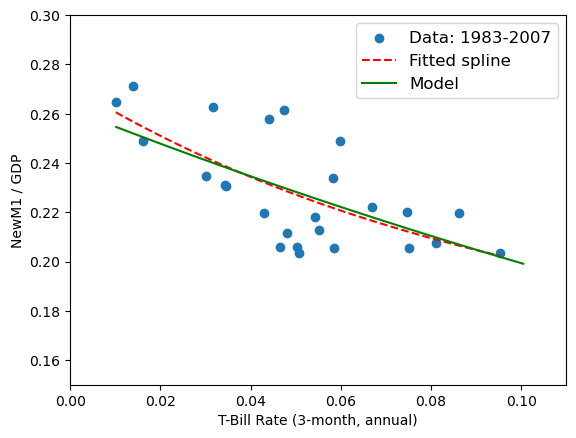

In [38]:
plt.style.use(style='default')
plt.scatter(x_data, y_data, label="Data: 1983-2007")
plt.plot(i_set, money_fitted_func, '--', color='r', label='Fitted spline')
plt.plot(i_policy_grid, M1_GDP_star, '-', color='green', label="Model")
plt.xlabel('T-Bill Rate (3-month, annual)')
plt.ylabel('NewM1 / GDP')
plt.xlim(0.0, 0.11)
plt.ylim(0.15, 0.3)
plt.legend(fontsize=12)
plt.savefig("m1_gdp_model_fit.png", dpi=800)


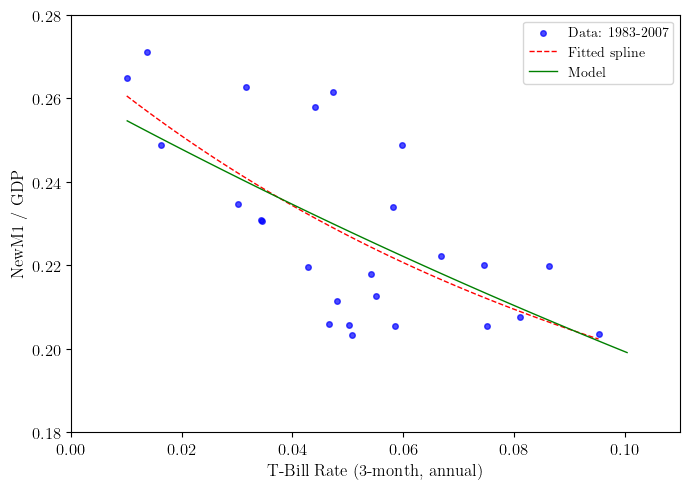

In [39]:
# Update matplotlib parameters for a similar style without using LaTeX
plt.rcParams.update({
    "text.usetex": True,  # Disable LaTeX as it's not available
    "font.family": "serif",
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "lines.linewidth": 1,
    "lines.markersize": 4,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

# Create the plot again
plt.figure(figsize=(7, 5))
plt.scatter(x_data, y_data, label="Data: 1983-2007", color="blue", alpha=0.7)
plt.plot(i_set, money_fitted_func, '--', color='red', label="Fitted spline")
plt.plot(i_policy_grid, M1_GDP_star, '-', color='green', label="Model")
plt.xlabel("T-Bill Rate (3-month, annual)")
plt.ylabel("NewM1 / GDP")
plt.xlim(0.0, 0.11)
plt.ylim(0.18, 0.28)
plt.legend(loc='upper right', fontsize=10, frameon=True)
#plt.title("Calibration and money demand data")

# Save and display the plot
plt.tight_layout()
output_path = "m1_gdp_model_fit.png"
plt.savefig(output_path, dpi=800)
plt.show()